## Drawing to Learn

In this notebook I clean and analyze the data of an experiment conducted to study whether drawing benefits understanding of a scientific passage. Participants were randomly assigned to complete four different tasks while reading a passage about the change of the seasons. Some were asked to study a provided illustration, others were asked to copy that illustration onto a new sheet of paper, others were asked to complete a scaffolded illustrative worksheet, and others were asked to draw to make sense of the lesson. Let's see what we find. 

This work is for a research project at the Learning In Multimedia Environments (LIME) Lab at the University of California, San Diego. 

In [1]:
# Related third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols
from wordcloud import STOPWORDS, WordCloud

# Local application/library-specific imports
from utilities import *

# Jupyter notebook specific imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# The seaborn library makes plots look nicer
sns.set_context("talk")

# Round decimals when displaying DataFrames
pd.set_option("precision", 2)

# Set matplotlib preferences
font = {"family": "Bitstream Vera Sans", "weight": "regular", "size": 13}

# set standard fig size
figure = {"figsize": (10, 8)}

plt.rc("font", **font)
plt.rc("figure", **figure)

# Importing data 

In [103]:
# Import raw data
df_seasons = pd.read_csv("./Seasons/Official_Seasons_Data.csv")
df_seasons_rsub = pd.read_excel("./Seasons/R lowest.xlsx")

In [104]:
df_seasons.head(3)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q137,Q139,Q141,Q143,Q145,Q147,Q149,SC0,Test Order,Unnamed: 134
0,11/19/19 15:00,11/19/19 15:32,0,132.239.182.138,100,1942,1,11/19/19 15:32,R_2QnF3ItZVmQyNR6,NaN,...,1,1,1,1,1,1,0,108,BA,0
1,11/19/19 14:58,11/19/19 15:32,0,132.239.182.140,100,2057,1,11/19/19 15:32,R_yKilGBsdGhEWum5,NaN,...,0,1,1,0,1,0,1,58,BA,2
2,11/19/19 15:53,11/19/19 16:32,0,132.239.182.140,100,2340,1,11/19/19 16:32,R_1mr2uZ8p1hgwemE,NaN,...,1,1,1,1,1,0,1,84,BA,1


In [105]:
df_seasons_rsub.head(3)

,R1 - lowest,R2 - lowest,R3 - lowest
0,0,0,0
1,2,0,0
2,1,0,0


In [6]:
df_seasons = pd.concat([df_seasons, df_seasons_rsub], axis=1)

In [106]:
df_seasons.head(3)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q137,Q139,Q141,Q143,Q145,Q147,Q149,SC0,Test Order,Unnamed: 134
0,11/19/19 15:00,11/19/19 15:32,0,132.239.182.138,100,1942,1,11/19/19 15:32,R_2QnF3ItZVmQyNR6,NaN,...,1,1,1,1,1,1,0,108,BA,0
1,11/19/19 14:58,11/19/19 15:32,0,132.239.182.140,100,2057,1,11/19/19 15:32,R_yKilGBsdGhEWum5,NaN,...,0,1,1,0,1,0,1,58,BA,2
2,11/19/19 15:53,11/19/19 16:32,0,132.239.182.140,100,2340,1,11/19/19 16:32,R_1mr2uZ8p1hgwemE,NaN,...,1,1,1,1,1,0,1,84,BA,1


In [107]:
# Remove rows with more than 5 missing values.
df_seasons.dropna(axis=0, thresh=4, inplace=True)

In [108]:
# rename attention check questions
df_seasons["attn1"] = df_seasons["Attn1"]
df_seasons["attn2"] = df_seasons["Attn2"]
df_seasons["attn3"] = df_seasons["CL_5"]

df_seasons["retention"] = df_seasons["Unnamed: 134"]

In [109]:
df_seasons.loc[df_seasons.attn1 == 0]["SubID"]

30     B37
68     Y47
90     Y58
134    O73
138    G76
158    Y69
205    O93
218    O97
Name: SubID, dtype: object

In [110]:
df_seasons.loc[df_seasons.attn2 == 0]["SubID"]

30     B37
205    O93
Name: SubID, dtype: object

In [111]:
df_seasons.loc[df_seasons.attn3 != 7]["SubID"]

31      G42
93      G59
219    O100
Name: SubID, dtype: object

In [112]:
df_seasons = df_seasons[df_seasons.attn1 != 0]
df_seasons = df_seasons[df_seasons.attn2 != 0]
df_seasons = df_seasons[df_seasons.attn3 == 7]

# Checking that participants were removed
assert len(df_seasons.loc[df_seasons["attn1"] == 0]) == 0
assert len(df_seasons.loc[df_seasons["attn2"] == 0]) == 0
assert len(df_seasons.loc[df_seasons["attn3"] != 7]) == 0

In [113]:
df_seasons.shape

(229, 139)

In [114]:
# Qualtrics exports lots of extra columns that we wont use in analyses

# dropping extra columns
useless_cols = [
    "StartDate",
    "EndDate",
    "Status",
    "IPAddress",
    "ResponseId",
    "Progress",
    "Finished",
    "RecipientLastName",
    "RecipientEmail",
    "ExternalReference",
    "LocationLatitude",
    "LocationLongitude",
    "DistributionChannel",
    "Time Test B P1_First Click",
    "Time Test B P1_Last Click",
    "Time Test B P1_Click Count",
    "Time Test A P1_First Click",
    "Time Test A P1_Last Click",
    "Time Test A P1_Click Count",
    "Time reading inst.ST_First Click",
    "Time reading inst.ST_Last Click",
    "Time reading inst.ST_Page Submit",
    "Time reading inst.ST_Click Count",
    "Time Reading_First Click",
    "Time Reading_Last Click",
    "Time Reading_Click Count",
    "Time reading inst.CO_First Click",
    "Time reading inst.CO_Last Click",
    "Time reading inst.CO_Page Submit",
    "Time reading inst.CO_Click Count",
    "Time reading inst.DR_First Click",
    "Time reading inst.DR_Last Click",
    "Time reading inst.DR_Page Submit",
    "Time reading inst.DR_Click Count",
    "Time CL_First Click",
    "Time CL_Last Click",
    "Time CL_Page Submit",
    "Time CL_Click Count",
    "SC0",
    "Attn1",
    "Attn2",
    "CL_5",
    "Q129_First Click",
    "Q129_Last Click",
    "Q129_Page Submit",
    "Q129_Click Count",
]

df_seasons.drop(useless_cols, axis=1, inplace=True)

In [115]:
df_seasons["paper_1"] = df_seasons["Q131"]
df_seasons["paper_2"] = df_seasons["Q133"]
df_seasons["paper_3"] = df_seasons["Q135"]
df_seasons["paper_4"] = df_seasons["Q137"]
df_seasons["paper_5"] = df_seasons["Q139"]
df_seasons["paper_6"] = df_seasons["Q141"]
df_seasons["paper_7"] = df_seasons["Q143"]
df_seasons["paper_8"] = df_seasons["Q145"]
df_seasons["paper_9"] = df_seasons["Q147"]
df_seasons["paper_10"] = df_seasons["Q149"]


to_drop = [
    "Q131",
    "Q133",
    "Q135",
    "Q137",
    "Q139",
    "Q141",
    "Q143",
    "Q145",
    "Q147",
    "Q149",
]

df_seasons.drop(to_drop, axis=1, inplace=True)

In [17]:
# Change the names of the columns

df_seasons["PK_1"] = df_seasons["Prior Knowledge_1"]
df_seasons["PK_2"] = df_seasons["Prior Knowledge_2"]
df_seasons["PK_1_conf"] = df_seasons["Confidence - Prior K_1"]
df_seasons["PK_2_conf"] = df_seasons["Confidence - Prior K_2"]

# Coursse_history
df_seasons["Course_history"] = df_seasons["Course history"]

# Perceived difficulty of visualization activity
df_seasons["complete_difficulty"] = df_seasons["Complete - difficult"]
df_seasons["copy_difficulty"] = df_seasons["Copy - difficulty"]
df_seasons["study_difficulty"] = df_seasons["Study - difficulty"]
df_seasons["drawing_difficulty"] = df_seasons["Drawing - difficulty"]

# Visualization activity enjoyment
df_seasons["complete_enjoyment"] = df_seasons["Complete - like"]
df_seasons["copy_enjoyment"] = df_seasons["Copy - Like"]
df_seasons["study_enjoyment"] = df_seasons["Study - like"]
df_seasons["drawing_enjoyment"] = df_seasons["Drawing - Like"]

# Time spent reading
df_seasons["time spent reading"] = df_seasons["Time Reading_Page Submit"]

# self reported prior knowledge specific to seasons
df_seasons["confidence_seasons_pre"] = df_seasons["Confidence - Seasons"]

df_seasons["CL"] = df_seasons["GL"]
df_seasons["GL"] = df_seasons["GL.1"]

to_drop = ["GL", "GL.1"]
df_seasons.drop(to_drop, axis=1, inplace=True)

In [18]:
# Change data type of 'Condition' and 'Gender' to allow for string manipulations
df_seasons["Condition"] = df_seasons["Condition"].astype(str)
df_seasons["Gender"] = df_seasons["Gender"].astype(str)

# Change entries in column 'day_of_week' to represent the day of the week in words
df_seasons["Condition"] = df_seasons["Condition"].replace("1", "study")
df_seasons["Condition"] = df_seasons["Condition"].replace("2", "copy")
df_seasons["Condition"] = df_seasons["Condition"].replace("3", "complete")
df_seasons["Condition"] = df_seasons["Condition"].replace("4", "draw")

# Change entries in column 'Gender' to represent reported gender in words
df_seasons["Gender"] = df_seasons["Gender"].replace("1", "female")
df_seasons["Gender"] = df_seasons["Gender"].replace("2", "male")
df_seasons["Gender"] = df_seasons["Gender"].replace("3", "non-binary")

# Change data type of 'Condition' and 'Gender' to allow for string manipulations
df_seasons["Condition"] = df_seasons["Condition"].astype(str)
df_seasons["Gender"] = df_seasons["Gender"].astype(str)

# Making everything lowercase
df_seasons["Major"] = df_seasons.Major.str.lower()
df_seasons["Course history"] = df_seasons.Course_history.str.lower()
df_seasons["SubID"] = df_seasons.SubID.str.lower()

# Remove extra white spaces
df_seasons["Major"] = df_seasons.Major.str.strip()
df_seasons["Course_history"] = df_seasons.Course_history.str.strip
df_seasons["SubID"] = df_seasons.SubID.str.strip()

continous_vars = [
    "paper_1",
    "paper_2",
    "paper_3",
    "paper_4",
    "paper_5",
    "paper_6",
    "paper_7",
    "paper_8",
    "paper_9",
    "paper_10",
    "A1",
    "A2",
    "A3",
    "A4",
    "A6",
    "A7",
    "A8",
    "A9",
    "A10",
    "A11",
    "A12",
    "A13",
    "A14",
    "B1",
    "B2",
    "B3",
    "B4",
    "B5",
    "B6",
    "B7",
    "B8",
    "B9",
    "B10",
    "B11",
    "B12",
    "B13",
    "B14",
    "CL_1",
    "CL_2",
    "CL_3",
    "CL_4",
    "CL_6",
    "CL_7",
    "CL_8",
    "PK_1",
    "PK_1_conf",
    "PK_2",
    "PK_2_conf",
]

df_cont = df_seasons[continous_vars].apply(pd.to_numeric)

In [19]:
df_cont = df_cont.fillna(0)

In [20]:
# Create a new PAPER total score column
df_seasons["paper_total"] = (
    df_cont["paper_1"]
    + df_cont["paper_2"]
    + df_cont["paper_3"]
    + df_cont["paper_4"]
    + df_cont["paper_5"]
    + df_cont["paper_6"]
    + df_cont["paper_7"]
    + df_cont["paper_8"]
    + df_cont["paper_9"]
    + df_cont["paper_10"]
)

# Create Test A, Test B multiple choice columns
df_seasons["Test_A_total"] = (
    df_cont["A1"]
    + df_cont["A2"]
    + df_cont["A3"]
    + df_cont["A4"]
    + df_cont["A6"]
    + df_cont["A7"]
    + df_cont["A8"]
    + df_cont["A9"]
    + df_cont["A10"]
    + df_cont["A11"]
    + df_cont["A12"]
    + df_cont["A13"]
    + df_cont["A14"]
)

df_seasons["Test_B_total"] = (
    df_cont["B1"]
    + df_cont["B2"]
    + df_cont["B3"]
    + df_cont["B4"]
    + df_cont["B6"]
    + df_cont["B7"]
    + df_cont["B8"]
    + df_cont["B9"]
    + df_cont["B10"]
    + df_cont["B11"]
    + df_cont["B12"]
    + df_cont["B13"]
    + df_cont["B14"]
)

# Create cognitive load and subcomponent columns
# Total cognitive load
df_seasons["Total_CL"] = (
    df_cont["CL_1"]
    + df_cont["CL_2"]
    + df_cont["CL_3"]
    + df_cont["CL_4"]
    + df_cont["CL_6"]
    + df_cont["CL_7"]
    + df_cont["CL_8"]
)

# Total intrinsic load
df_seasons["Total IL"] = df_cont["CL_1"] + df_cont["CL_2"]

# Total extraneous load
df_seasons["Total EL"] = df_cont["CL_3"] + df_cont["CL_4"] + df_cont["CL_6"]

# Total germane load
df_seasons["Total GL"] = df_cont["CL_7"] + df_cont["CL_8"]

# Compute participants'total prior knowledge score (self-reported)
# PK_1 refers to physics and PK_2 to astro
df_seasons["Cummulative_PK"] = (df_cont["PK_1"] * df_cont["PK_1_conf"]) + (
    df_cont["PK_2"] * df_cont["PK_2_conf"]
)

In [21]:
# Now that we have cummulative scores these columns are no longer useful
df_seasons.drop(continous_vars, axis=1, inplace=True)

In [22]:
# Add two empty columns to the dataframe
df_seasons["Pretest_score"] = np.nan
df_seasons["Posttest_score"] = np.nan

# Fill the empty columns with the appropriate pre and post test
for col, row in df_seasons.iterrows():

    if df_seasons.loc[col, "Test Order"] == "BA":

        df_seasons.loc[col, "Pretest_score"] = df_seasons.loc[col, "Test_B_total"]
        df_seasons.loc[col, "Posttest_score"] = df_seasons.loc[col, "Test_A_total"]

    elif df_seasons.loc[col, "Test Order"] == "AB":

        df_seasons.loc[col, "Pretest_score"] = df_seasons.loc[col, "Test_A_total"]
        df_seasons.loc[col, "Posttest_score"] = df_seasons.loc[col, "Test_B_total"]

# Create a multiple choice gain
df_seasons["MC Gain"] = df_seasons["Posttest_score"] - df_seasons["Pretest_score"]

In [23]:
# Median split
median = df_seasons.loc[:, "Cummulative_PK"].median()
df_seasons["PK Split"] = np.nan

for col, row in df_seasons.iterrows():

    if df_seasons.loc[col, "Cummulative_PK"] < median:

        df_seasons.loc[col, "PK Split"] = "Low"

    else:

        df_seasons.loc[col, "PK Split"] = "High"

In [24]:
df_seasons["complete_difficulty"].replace("", np.nan, inplace=True)
df_seasons["complete_difficulty"] = df_seasons["complete_difficulty"].fillna(0)

df_seasons["copy_difficulty"].replace("", np.nan, inplace=True)
df_seasons["copy_difficulty"] = df_seasons["copy_difficulty"].fillna(0)

df_seasons["study_difficulty"].replace("", np.nan, inplace=True)
df_seasons["study_difficulty"] = df_seasons["study_difficulty"].fillna(0)

df_seasons["drawing_difficulty"].replace("", np.nan, inplace=True)
df_seasons["drawing_difficulty"] = df_seasons["drawing_difficulty"].fillna(0)

df_seasons["complete_difficulty"] = df_seasons["complete_difficulty"].astype(int)
df_seasons["copy_difficulty"] = df_seasons["copy_difficulty"].astype(int)
df_seasons["study_difficulty"] = df_seasons["study_difficulty"].astype(int)
df_seasons["drawing_difficulty"] = df_seasons["drawing_difficulty"].astype(int)

lst = []

for index, row in df_seasons.iterrows():
    lst.append(
        row.complete_difficulty
        + row.copy_difficulty
        + row.study_difficulty
        + row.drawing_difficulty
    )

df_seasons["cond_difficulty"] = lst


to_drop = [
    "complete_difficulty",
    "copy_difficulty",
    "study_difficulty",
    "drawing_difficulty",
]
df_seasons.drop(to_drop, axis=1, inplace=True)

In [25]:
df_seasons["complete_enjoyment"].replace("", np.nan, inplace=True)
df_seasons["complete_enjoyment"] = df_seasons["complete_enjoyment"].fillna(0)

df_seasons["copy_enjoyment"].replace("", np.nan, inplace=True)
df_seasons["copy_enjoyment"] = df_seasons["copy_enjoyment"].fillna(0)

df_seasons["study_enjoyment"].replace("", np.nan, inplace=True)
df_seasons["study_enjoyment"] = df_seasons["study_enjoyment"].fillna(0)

df_seasons["drawing_enjoyment"].replace("", np.nan, inplace=True)
df_seasons["drawing_enjoyment"] = df_seasons["drawing_enjoyment"].fillna(0)

df_seasons["complete_enjoyment"] = df_seasons["complete_enjoyment"].astype(int)
df_seasons["copy_enjoyment"] = df_seasons["copy_enjoyment"].astype(int)
df_seasons["study_enjoyment"] = df_seasons["study_enjoyment"].astype(int)
df_seasons["drawing_enjoyment"] = df_seasons["drawing_enjoyment"].astype(int)

lst = []

for index, row in df_seasons.iterrows():
    lst.append(
        row.complete_enjoyment
        + row.copy_enjoyment
        + row.study_enjoyment
        + row.drawing_enjoyment
    )

df_seasons["cond_enjoyment"] = lst

to_drop = [
    "complete_enjoyment",
    "copy_enjoyment",
    "study_enjoyment",
    "drawing_enjoyment",
]
df_seasons.drop(to_drop, axis=1, inplace=True)

In [26]:
# Changing datatype and changing units sec -> min
df_seasons["Duration(s)"] = df_seasons["Duration (in seconds)"].astype(float)
df_seasons["Duration(min)"] = df_seasons["Duration(s)"].multiply(1 / 60)

df_seasons["Time_reading(s)"] = df_seasons["time spent reading"].astype(float)
df_seasons["time_reading(min)"] = df_seasons["Time_reading(s)"].multiply(1 / 60)

In [28]:
# Splitting date and time for RecordedDate
date_time = df_seasons["RecordedDate"].str.split(" ", n=1, expand=True)
df_seasons.drop(["RecordedDate"], axis=1, inplace=True)
df_seasons["date"] = date_time[0]
df_seasons["time"] = date_time[1]

df_seasons["date"] = df_seasons["date"].astype(str)
df_seasons["day_of_week"] = df_seasons["date"].apply(day_of_week)
df_seasons["time"] = df_seasons["time"].apply(time_of_day)

In [31]:
# Droping columns that are no longer needed
to_drop = [
    "RecipientFirstName",
    "UserLanguage",
    "Time Test B P1_Page Submit",
    "Time Test A P1_Page Submit",
    "Prior Knowledge_1",
    "Prior Knowledge_2",
    "Confidence - Prior K_1",
    "Confidence - Prior K_2",
    "Q255_First Click",
    "Q255_Last Click",
    "Q255_Page Submit",
    "Q255_Click Count",
    "Study - difficulty",
    "Study - like",
    "Complete - difficult",
    "Complete - like",
    "Copy - difficulty",
    "Copy - Like",
    "Drawing - difficulty",
    "Drawing - Like",
    "IL",
    "EL",
    "CL",
    "Duration(s)",
    "Time Reading_Page Submit",
    "R1",
    "R2",
    "R3",
    "T1",
    "T2",
    "T3",
    "T4",
    "attn1",
    "attn2",
    "attn3",
    "Last time - seasons",
    "1stlearned -seasons",
    "confidence_seasons_pre",
    "Duration (in seconds)",
    "Time_reading(s)",
]


df_seasons = df_seasons.drop(to_drop, axis=1)

In [32]:
small_df_seasons = df_seasons[
    [
        "SubID",
        "date",
        "time",
        "day_of_week",
        "Condition",
        "Age",
        "Gender",
        "Cummulative_PK",
        "PK Split",
        "Test Order",
        "Test_A_total",
        "Test_B_total",
        "Pretest_score",
        "Posttest_score",
        "MC Gain",
        "retention",
        "R1 - lowest",
        "R2 - lowest",
        "R3 - lowest",
        "time_reading(min)",
        "cond_difficulty",
        "cond_enjoyment",
        "Total_CL",
        "Total IL",
        "Total EL",
        "Total GL",
        "paper_total",
    ]
]

small_df_seasons.columns = [
    "SubID",
    "date",
    "time",
    "day_of_week",
    "condition",
    "age",
    "gender",
    "prior_knowledge",
    "pk_Split",
    "test_order",
    "test_A",
    "test_B",
    "pretest_score",
    "posttest_score",
    "mc_gain",
    "retention_lower",
    "R1 - lowest",
    "R2 - lowest",
    "R3 - lowest",
    "time_reading",
    "cond_difficulty",
    "cond_enjoyment",
    "CL",
    "IL",
    "EL",
    "GL",
    "paper_total",
]

In [33]:
small_df_seasons.head()

,SubID,date,time,day_of_week,condition,age,gender,prior_knowledge,pk_Split,test_order,...,R2 - lowest,R3 - lowest,time_reading,cond_difficulty,cond_enjoyment,CL,IL,EL,GL,paper_total
0,y38,11/19/19,3:00 PM,tuesday,draw,18,male,16,High,BA,...,0,0,5.08,4,1,37,16,6,15,9
1,y37,11/19/19,3:00 PM,tuesday,draw,19,female,10,Low,BA,...,0,0,5.55,4,5,18,12,6,0,6
2,o25,11/19/19,4:00 PM,tuesday,copy,20,female,10,Low,BA,...,0,0,11.36,2,2,38,15,14,9,7
3,o26,11/19/19,4:00 PM,tuesday,copy,19,male,10,Low,BA,...,2,6,8.74,1,3,4,2,0,2,8
4,o27,11/19/19,4:00 PM,tuesday,copy,19,female,16,High,BA,...,2,2,5.18,2,3,17,4,7,6,7


# Visualization

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


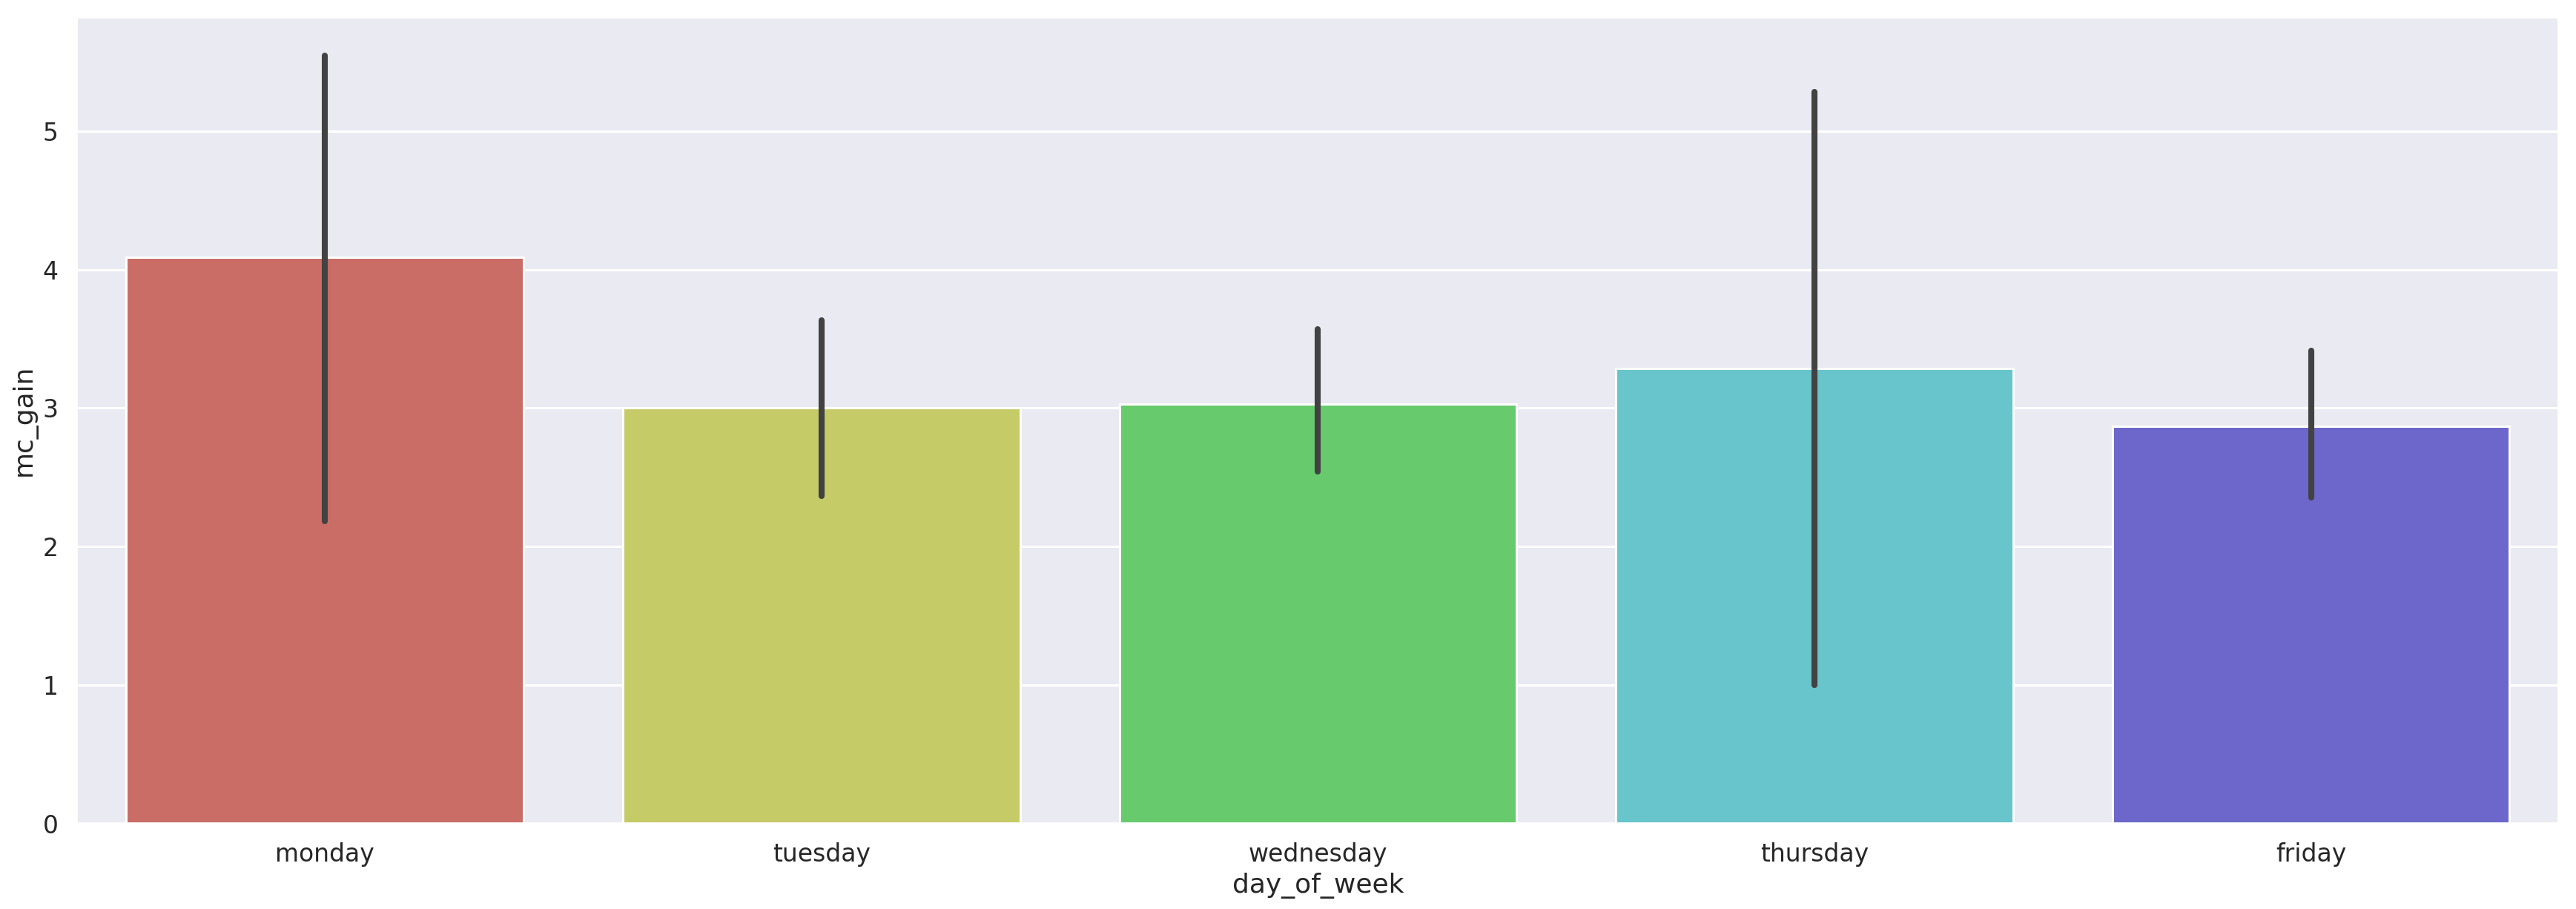

In [34]:
plt.figure(figsize=(30, 10))

sns.barplot(
    x="day_of_week",
    y="mc_gain",
    data=small_df_seasons,
    order=["monday", "tuesday", "wednesday", "thursday", "friday"],
)

In [35]:
anova_vviq = ols("mc_gain ~ C(day_of_week)", data=small_df_seasons).fit()
anova_vviq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mc_gain   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.6322
Date:                Thu, 09 Jul 2020   Prob (F-statistic):              0.640
Time:                        18:35:51   Log-Likelihood:                -529.22
No. Observations:                 229   AIC:                             1068.
Df Residuals:                     224   BIC:                             1086.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.8687      0.248     11.569      0.000       2.380       3.357
C(day_of_week)[T.monday]        1.2222      0.784      1.559      0.120      -0.323       2.767
C(day_of_week)[T.thursday]      0.4170      0.965      0.432      0.666      -1.484       2.319
C(day_of_week)[T.tuesday]       0.1313      0.431      0.305      0.761      -0.718       0.981
C(day_of_week)[T.wednesday]     0.1631      0.398      0.410      0.682      -0.621       0.947
==============================================================================
Omnibus:                        0.305   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.858   Jarque-Bera (JB):                0.113
Skew:                          -0.020   Prob(JB):                        0.945
Kurtosis:                       3.101   Cond. No.                         6.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

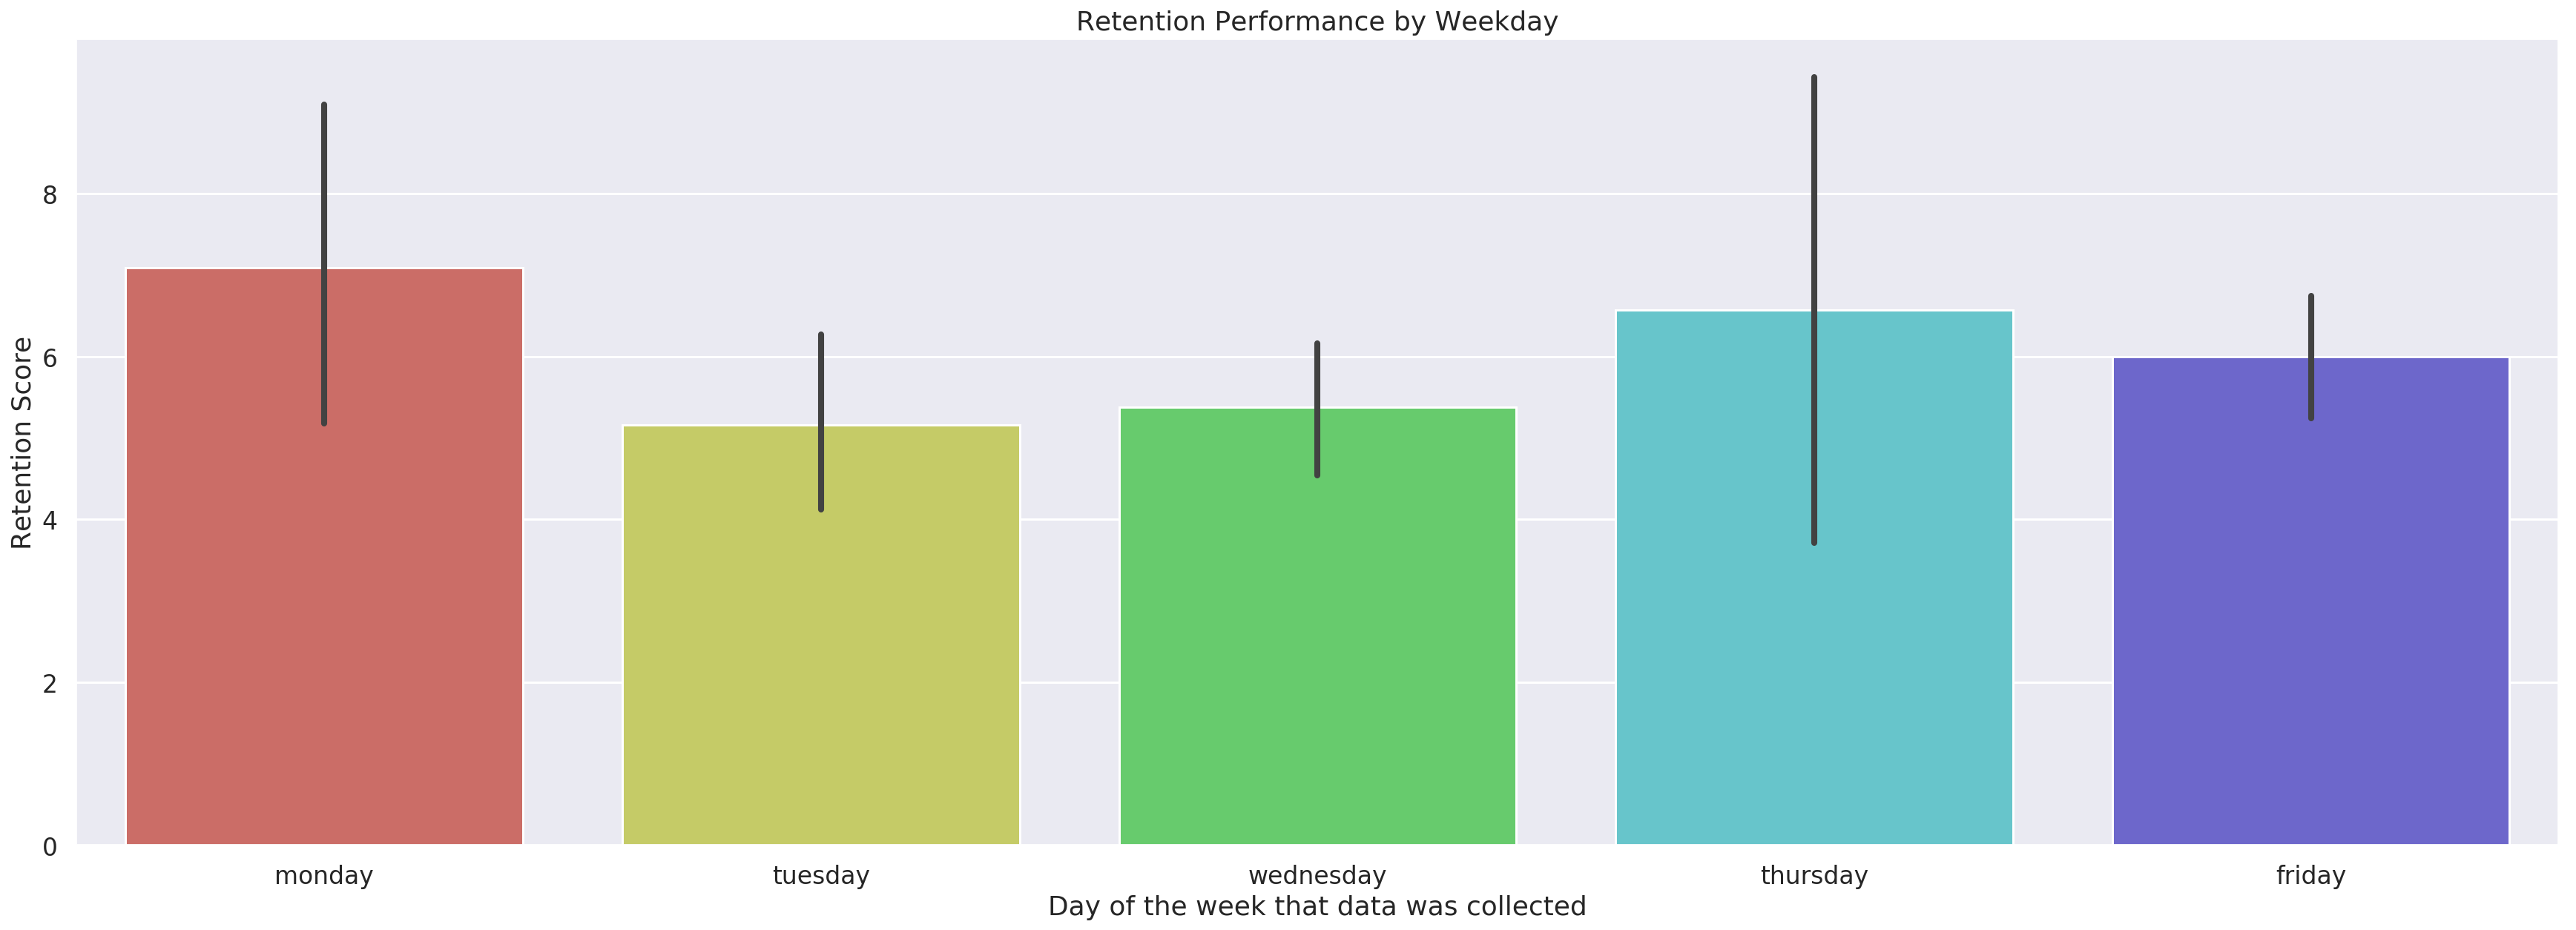

In [36]:
plt.figure(figsize=(30, 10))

sns.barplot(
    x="day_of_week",
    y="retention_lower",
    data=small_df_seasons,
    order=["monday", "tuesday", "wednesday", "thursday", "friday"],
)

plt.title("Retention Performance by Weekday")
plt.xlabel("Day of the week that data was collected")
plt.ylabel("Retention Score")

In [37]:
anova_vviq = ols("retention_lower ~ C(day_of_week)", data=small_df_seasons).fit()
anova_vviq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        retention_lower   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.034
Date:                Thu, 09 Jul 2020   Prob (F-statistic):              0.391
Time:                        18:35:52   Log-Likelihood:                -620.65
No. Observations:                 229   AIC:                             1251.
Df Residuals:                     224   BIC:                             1268.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       6.0000      0.370     16.232      0.000       5.272       6.728
C(day_of_week)[T.monday]        1.0909      1.169      0.933      0.352      -1.213       3.394
C(day_of_week)[T.thursday]      0.5714      1.438      0.397      0.692      -2.263       3.406
C(day_of_week)[T.tuesday]      -0.8367      0.642     -1.302      0.194      -2.103       0.429
C(day_of_week)[T.wednesday]    -0.6190      0.593     -1.044      0.297      -1.787       0.549
==============================================================================
Omnibus:                       44.303   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.512
Skew:                           0.213   Prob(JB):                      0.00316
Kurtosis:                       1.988   Cond. No.                         6.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

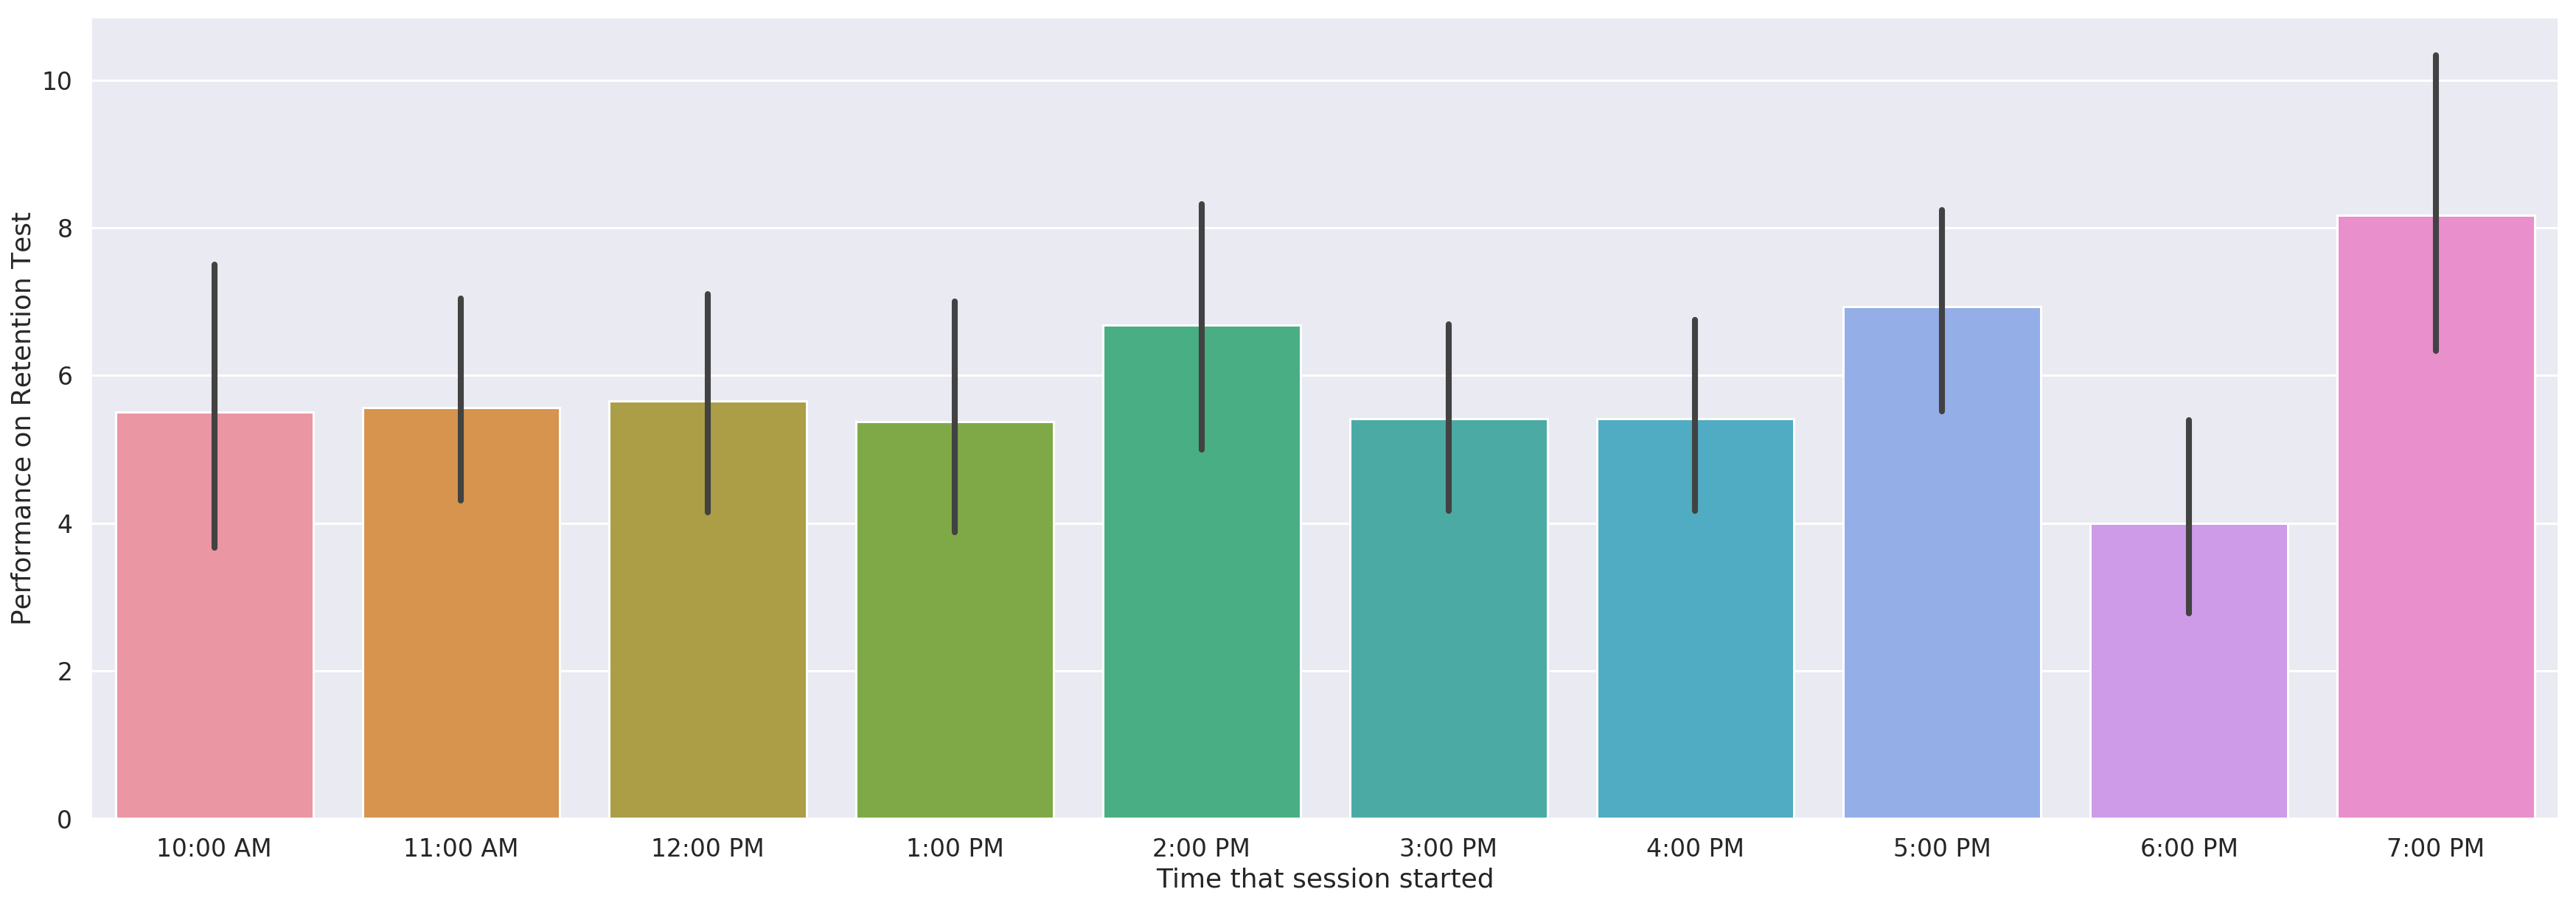

In [38]:
plt.figure(figsize=(30, 10))

sns.barplot(
    x="time",
    y="retention_lower",
    data=small_df_seasons,
    order=[
        "10:00 AM",
        "11:00 AM",
        "12:00 PM",
        "1:00 PM",
        "2:00 PM",
        "3:00 PM",
        "4:00 PM",
        "5:00 PM",
        "6:00 PM",
        "7:00 PM",
    ],
)
plt.xlabel("Time that session started")
plt.ylabel("Performance on Retention Test")

In [39]:
anova_vviq = ols("retention_lower ~ C(time)", data=small_df_seasons).fit()
anova_vviq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        retention_lower   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.447
Date:                Thu, 09 Jul 2020   Prob (F-statistic):              0.170
Time:                        18:35:53   Log-Likelihood:                -594.93
No. Observations:                 221   AIC:                             1210.
Df Residuals:                     211   BIC:                             1244.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.5000      1.055      5.212      0.000       3.420       7.580
C(time)[T.11:00 AM]     0.0652      1.302      0.050      0.960      -2.501       2.631
C(time)[T.12:00 PM]     0.1500      1.335      0.112      0.911      -2.481       2.781
C(time)[T.1:00 PM]     -0.1250      1.292     -0.097      0.923      -2.673       2.423
C(time)[T.2:00 PM]      1.1842      1.348      0.879      0.381      -1.473       3.841
C(time)[T.3:00 PM]     -0.0862      1.255     -0.069      0.945      -2.560       2.387
C(time)[T.4:00 PM]     -0.0833      1.218     -0.068      0.946      -2.485       2.319
C(time)[T.5:00 PM]      1.4310      1.255      1.141      0.255      -1.042       3.904
C(time)[T.6:00 PM]     -1.5000      1.302     -1.152      0.250      -4.066       1.066
C(time)[T.7:00 PM]      2.6667      1.828      1.459      0.146      -0.936       6.270
==============================================================================
Omnibus:                       23.860   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.294
Skew:                           0.249   Prob(JB):                      0.00959
Kurtosis:                       2.128   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

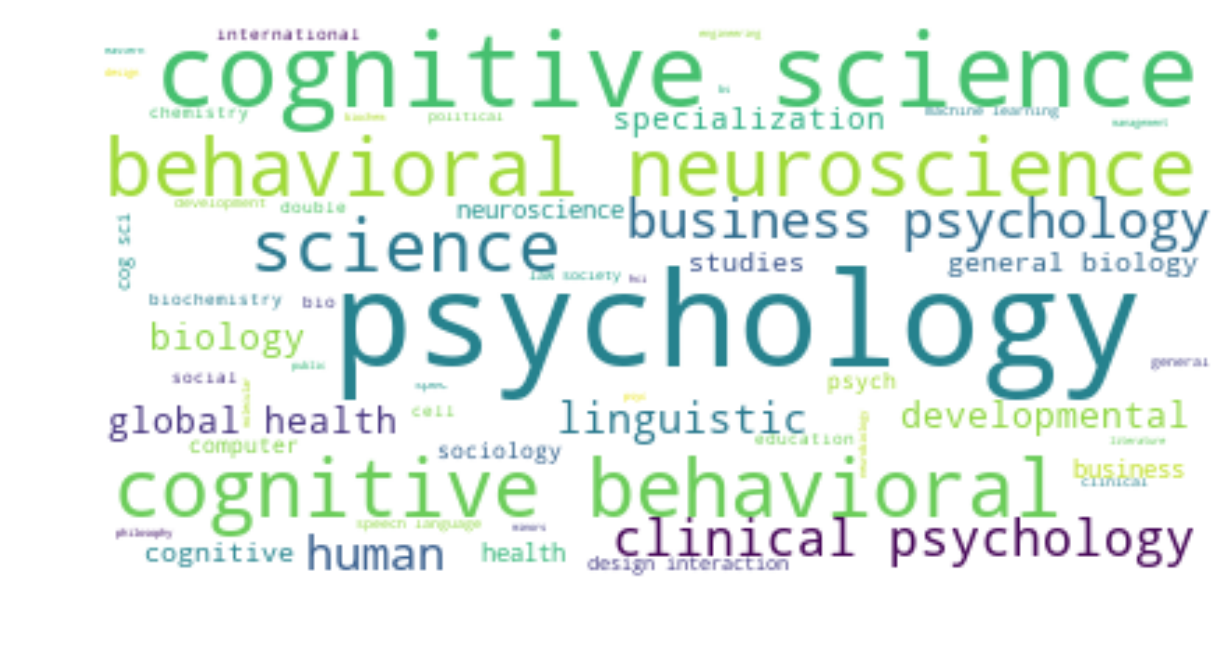

In [40]:
text = " ".join(major for major in df_seasons.Major)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update([";", ":", "(", ")", "minor", "major"])
# df_seasons.Major[0]

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Self-reported Prior Knowledge 

Mean: 15.576 	Standard dev: 6.424

Min: 8 	Median: 16.0 	Max: 50


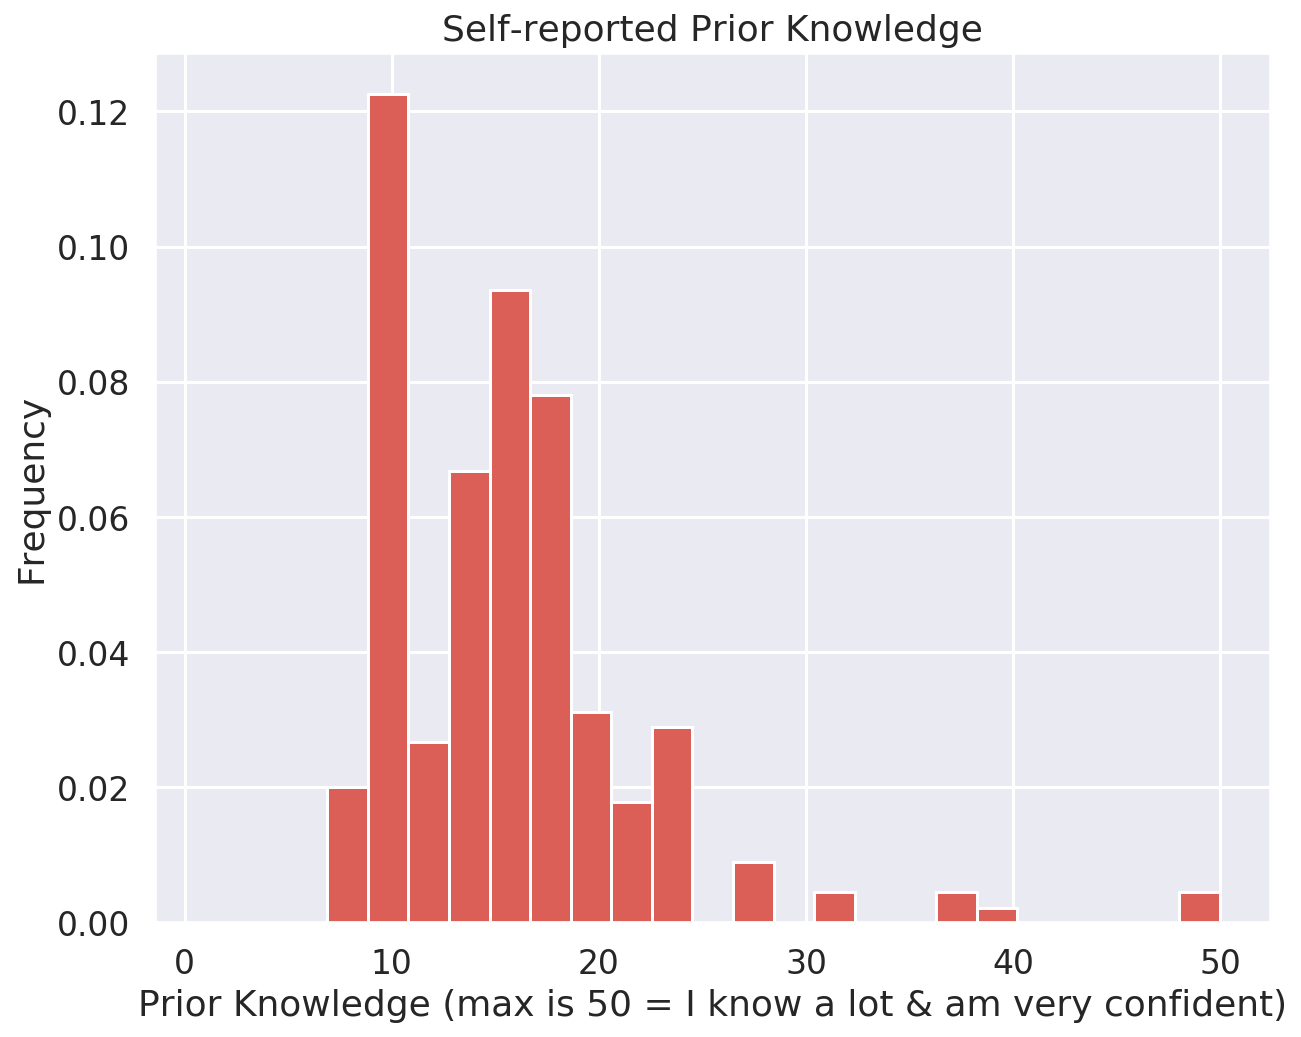

In [41]:
plt.hist(small_df_seasons["prior_knowledge"], bins=25, range=(1, 50), density=True)

plt.title("Self-reported Prior Knowledge")
plt.xlabel("Prior Knowledge (max is 50 = I know a lot & am very confident)")
plt.ylabel("Frequency")

f2 = plt.gcf()  # get current figure

pk_min = round(small_df_seasons["prior_knowledge"].min(), 3)
pk_max = round(small_df_seasons["prior_knowledge"].max(), 3)
pk_mean = round(small_df_seasons["prior_knowledge"].mean(), 3)
pk_std = round(small_df_seasons["prior_knowledge"].std(), 3)
pk_med = round(small_df_seasons["prior_knowledge"].median(), 3)

print(
    "Self-reported Prior Knowledge \n\nMean: " + str(pk_mean),
    "\tStandard dev: " + str(pk_std),
)

print("\nMin: " + str(pk_min), "\tMedian: " + str(pk_med), "\tMax: " + str(pk_max))

Text(0, 0.5, 'Prior Knowledge')

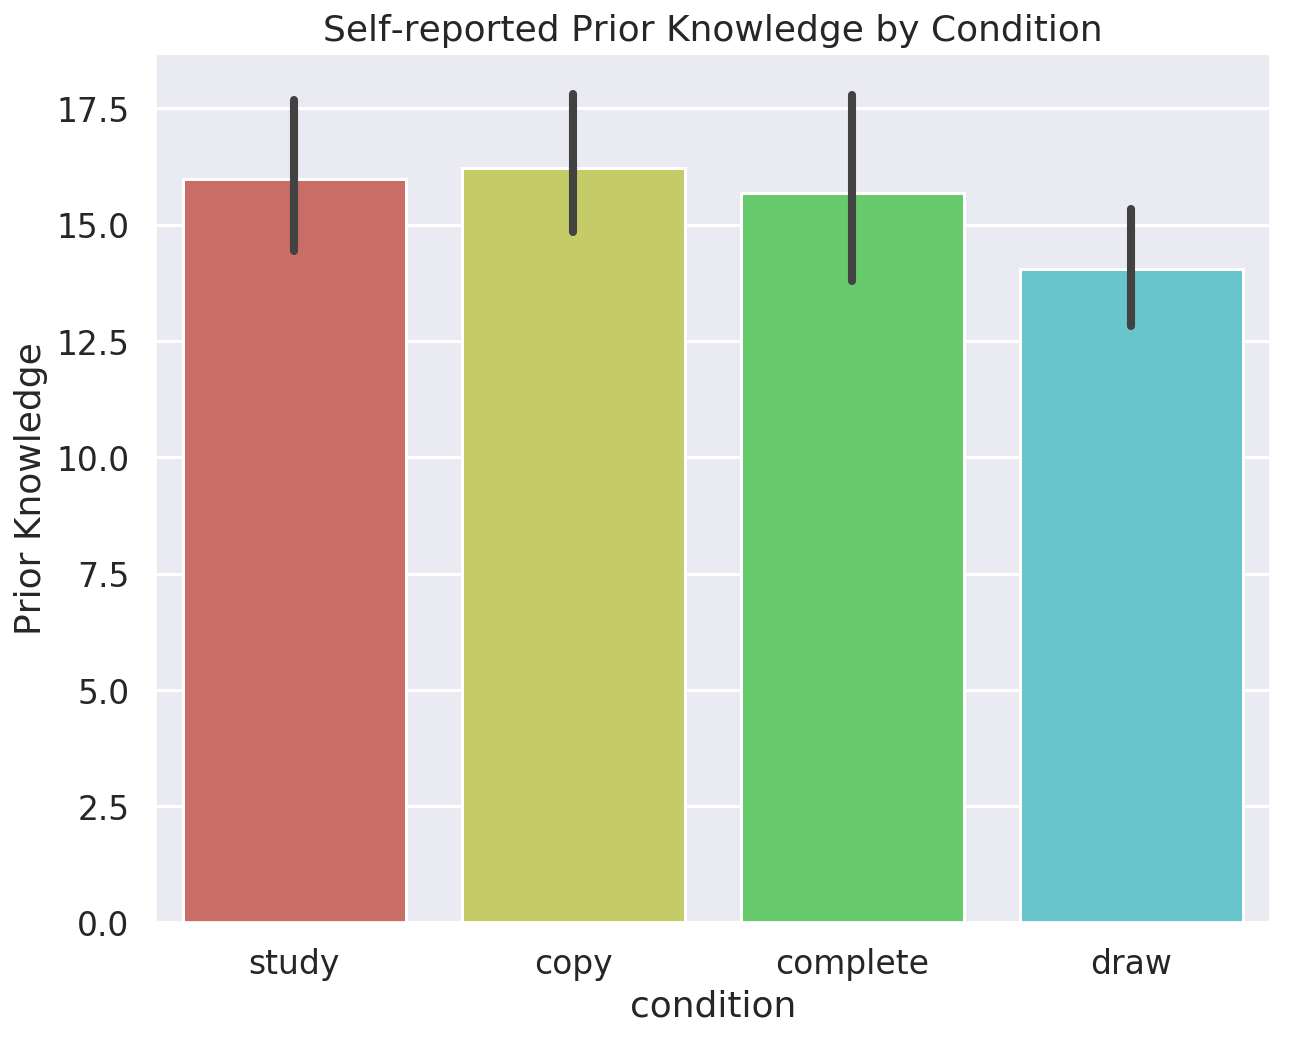

In [42]:
sns.barplot(
    y="prior_knowledge",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Self-reported Prior Knowledge by Condition")
plt.xlabel("condition")
plt.ylabel("Prior Knowledge")

Time reading 

Mean: 9.378 	Standard dev: 4.745

Min: 5.025 	Median: 8.057 	Max: 35.418


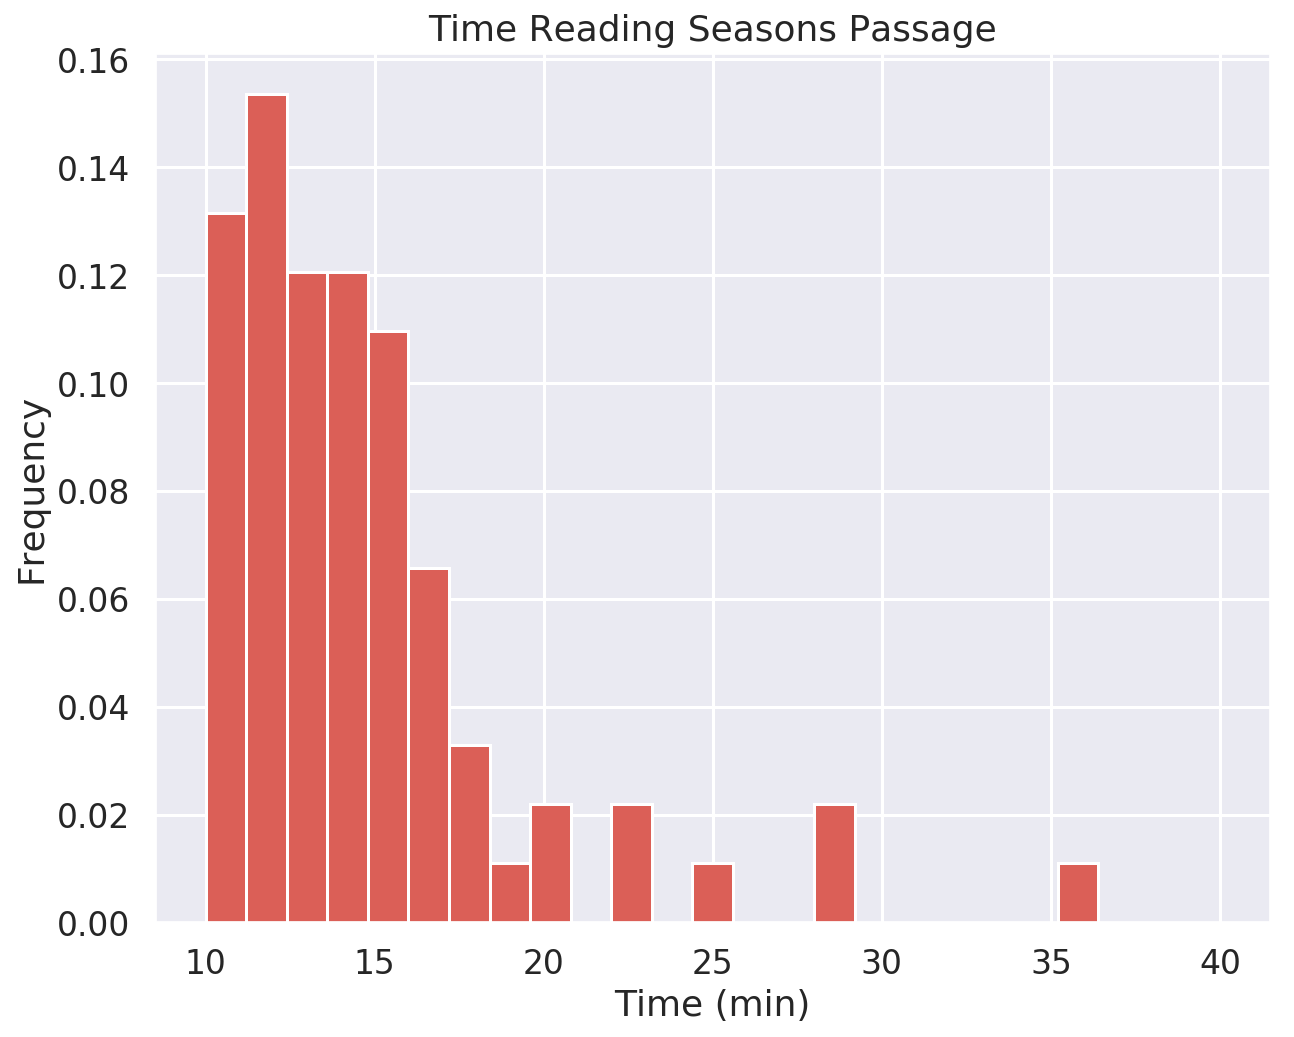

In [44]:
plt.hist(small_df_seasons["time_reading"], bins=25, range=(10, 40), density=True)

plt.title("Time Reading Seasons Passage")
plt.xlabel("Time (min)")
plt.ylabel("Frequency")

f2 = plt.gcf()  # get current figure

read_min = round(small_df_seasons["time_reading"].min(), 3)
read_max = round(small_df_seasons["time_reading"].max(), 3)
read_mean = round(small_df_seasons["time_reading"].mean(), 3)
read_std = round(small_df_seasons["time_reading"].std(), 3)
read_med = round(small_df_seasons["time_reading"].median(), 3)

print("Time reading \n\nMean: " + str(read_mean), "\tStandard dev: " + str(read_std))

print(
    "\nMin: " + str(read_min), "\tMedian: " + str(read_med), "\tMax: " + str(read_max)
)

Text(0, 0.5, 'time (min)')

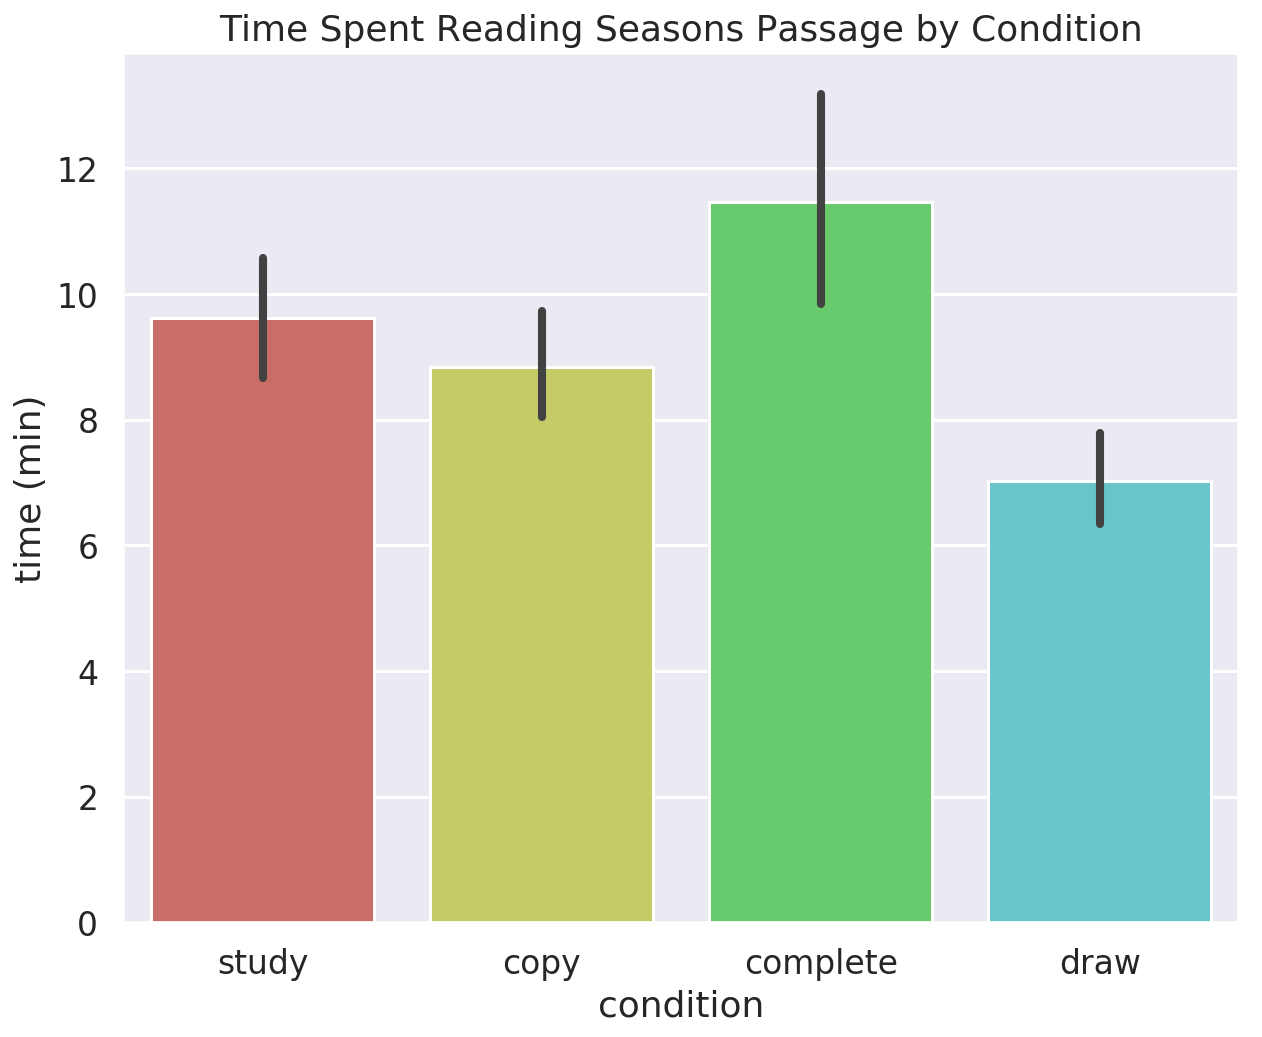

In [45]:
sns.barplot(
    y="time_reading",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Time Spent Reading Seasons Passage by Condition")
plt.xlabel("condition")
plt.ylabel("time (min)")

In [96]:
anova_time_read = ols("time_reading ~ C(condition)", data=small_df_seasons).fit()
anova_time_read.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           time_reading   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     8.821
Date:                Thu, 09 Jul 2020   Prob (F-statistic):           1.49e-05
Time:                        18:36:15   Log-Likelihood:                -668.30
No. Observations:                 229   AIC:                             1345.
Df Residuals:                     225   BIC:                             1358.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                11.4588      0.579     19.806      0.000      10.319      12.599
C(condition)[T.copy]     -2.6173      0.818     -3.199      0.002      -4.230      -1.005
C(condition)[T.draw]     -4.4369      0.882     -5.028      0.000      -6.176      -2.698
C(condition)[T.study]    -1.8480      0.818     -2.259      0.025      -3.460      -0.236
==============================================================================
Omnibus:                       85.264   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.180
Skew:                           1.577   Prob(JB):                     2.90e-60
Kurtosis:                       7.334   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Retention test score')

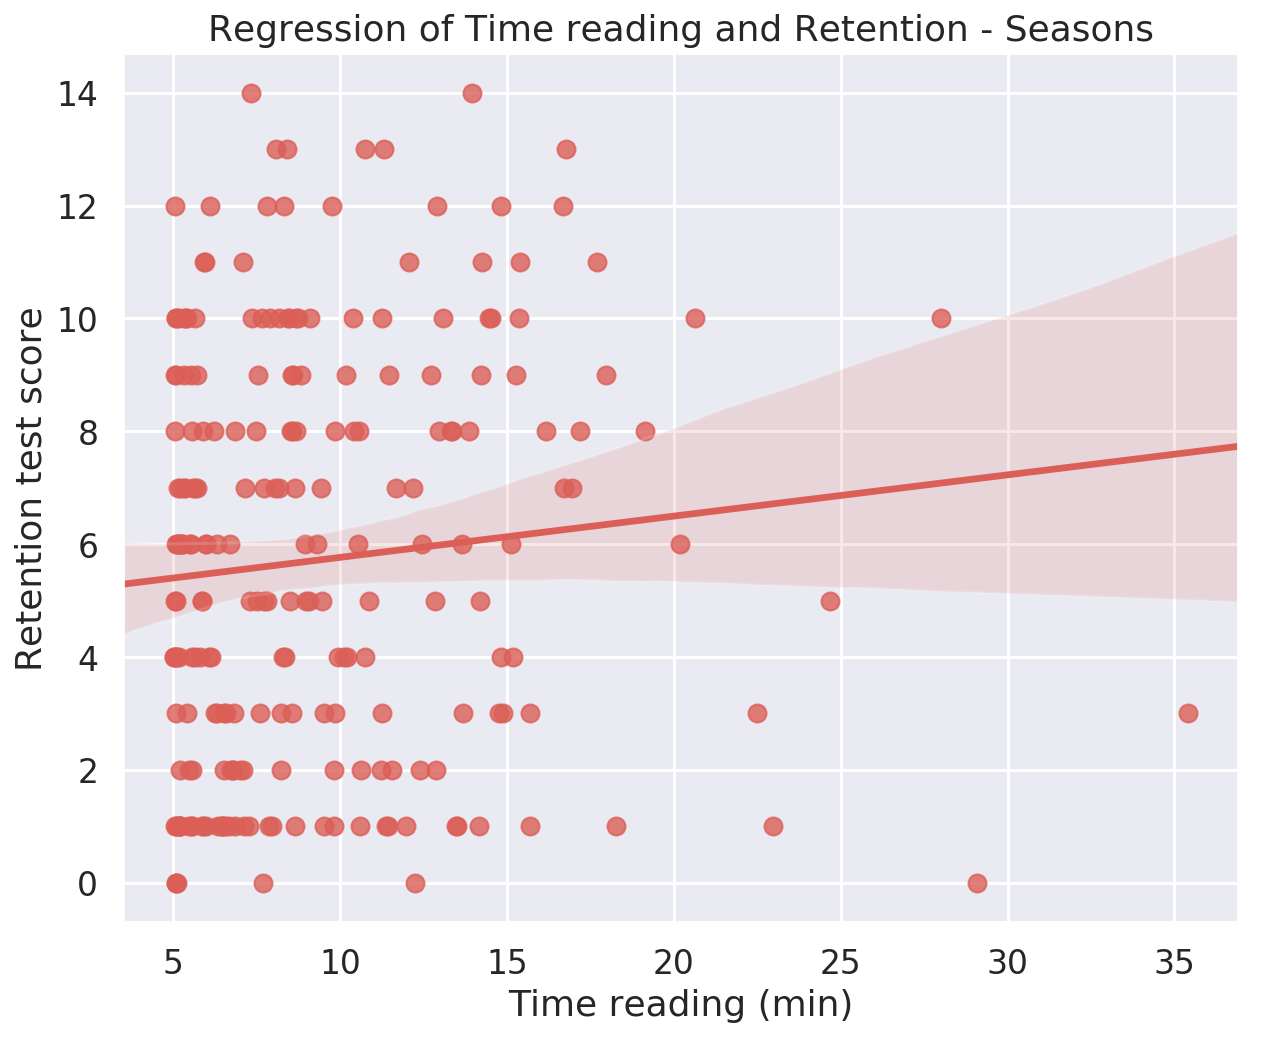

In [46]:
sns.regplot(
    x=small_df_seasons["time_reading"],
    y=small_df_seasons["retention_lower"],
)

plt.title("Regression of Time reading and Retention - Seasons")
plt.xlabel("Time reading (min)")
plt.ylabel("Retention test score")

Multiple choice pre-test Score Summary 

Mean: 6.175 	Standard_dev: 2.507

Min: 1.0 	Median: 6.0 	Max: 12.0


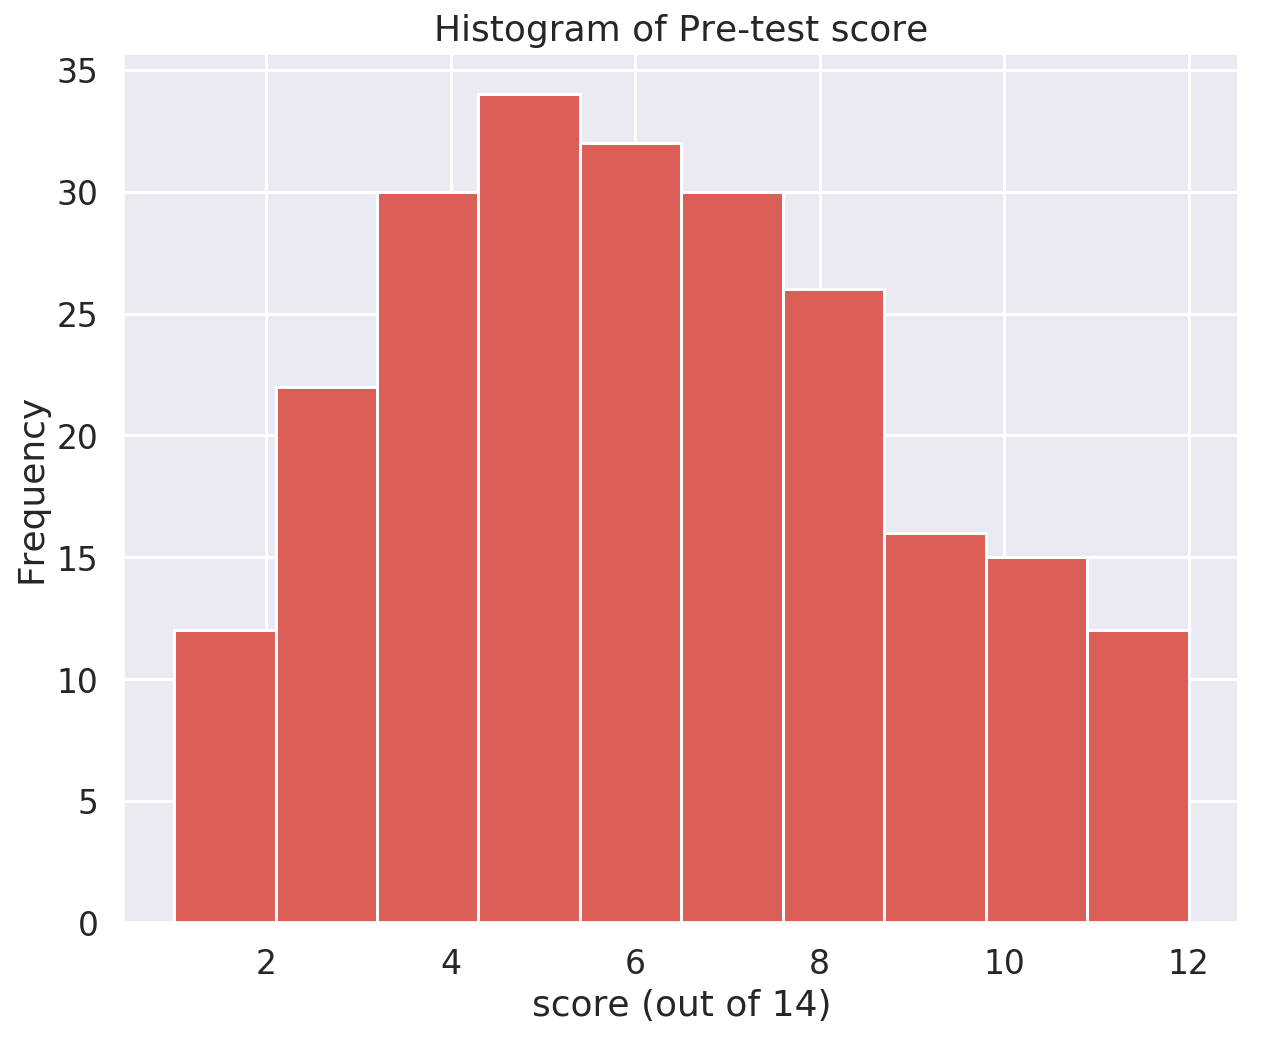

In [47]:
# Pre-test
plt.hist(small_df_seasons["pretest_score"], bins=10, label="pretest score")

plt.title("Histogram of Pre-test score")
plt.xlabel("score (out of 14)")
plt.ylabel("Frequency")


pretest_min = round(small_df_seasons["pretest_score"].min(), 3)
pretest_max = round(small_df_seasons["pretest_score"].max(), 3)
pretest_mean = round(small_df_seasons["pretest_score"].mean(), 3)
pretest_std = round(small_df_seasons["pretest_score"].std(), 3)
pretest_med = round(small_df_seasons["pretest_score"].median(), 3)


print(
    "Multiple choice pre-test Score Summary \n\nMean: " + str(pretest_mean),
    "\tStandard_dev: " + str(pretest_std),
)
print(
    "\nMin: " + str(pretest_min),
    "\tMedian: " + str(pretest_med),
    "\tMax: " + str(pretest_max),
)

Text(0, 0.5, 'Score (out of 14)')

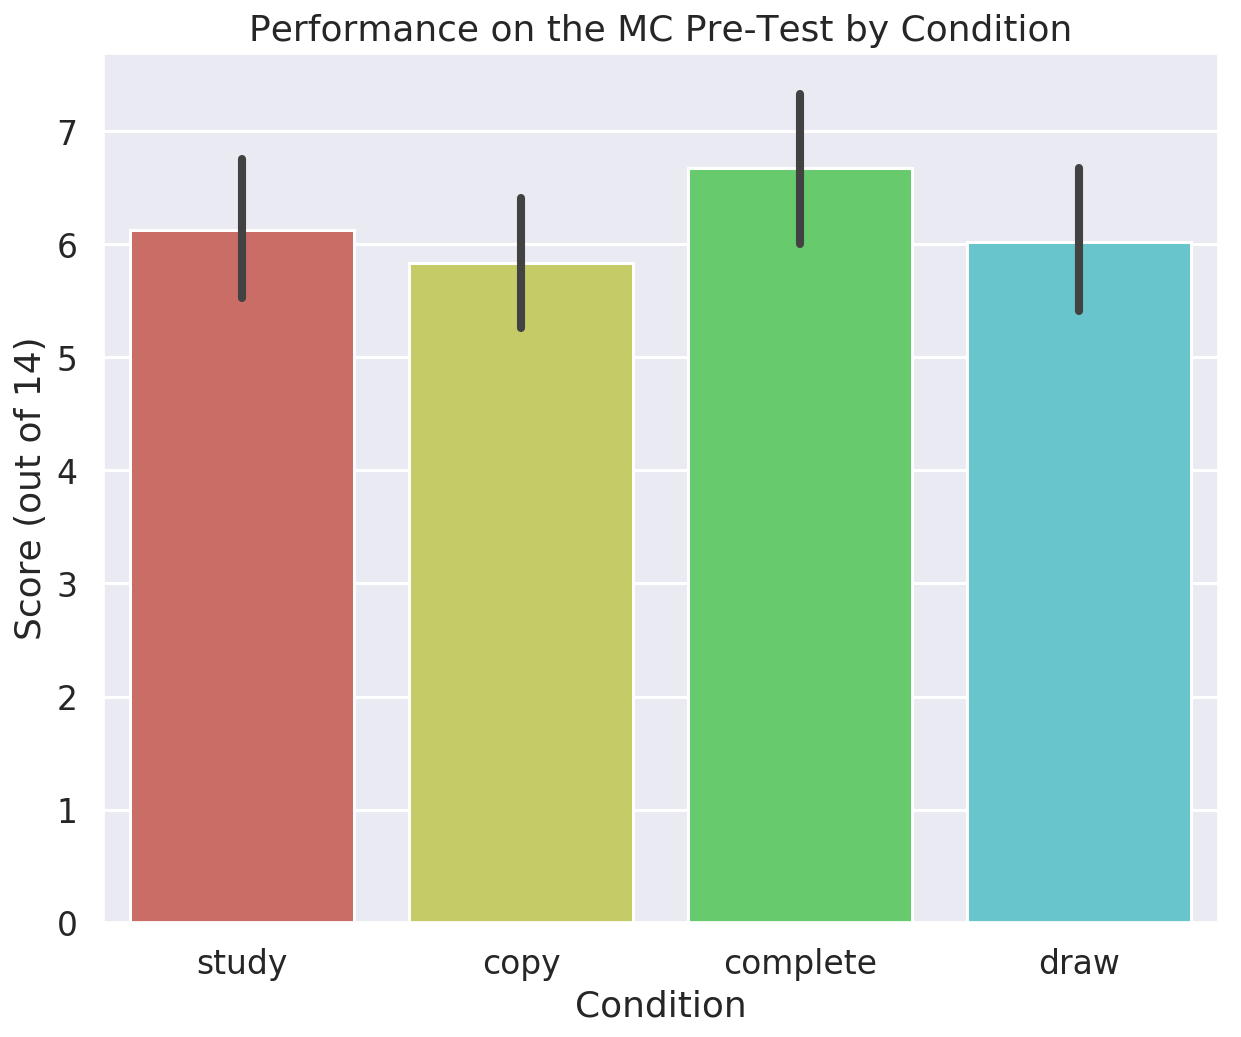

In [48]:
sns.barplot(
    y="pretest_score",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Performance on the MC Pre-Test by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (out of 14)")

Multiple choice posttest Score 

Mean: 9.188 	Standard_dev: 2.569

Min: 1.0 	Median: 10.0 	Max: 13.0


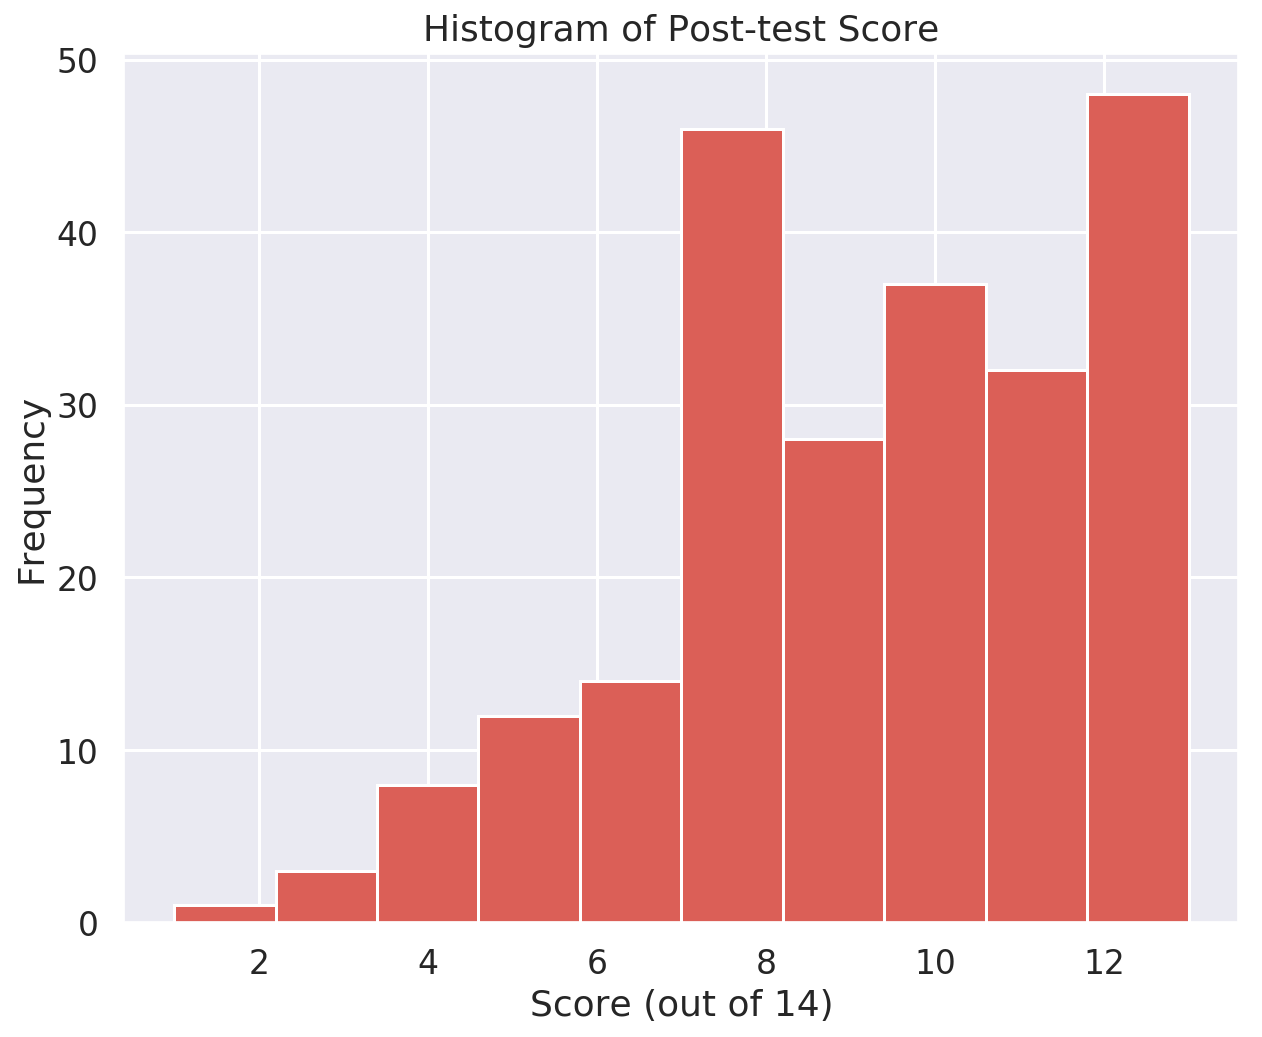

In [50]:
# Post-test

plt.hist(small_df_seasons["posttest_score"], bins=10, label="posttest_score")

plt.title("Histogram of Post-test Score")
plt.xlabel("Score (out of 14)")
plt.ylabel("Frequency")


posttest_min = round(small_df_seasons["posttest_score"].min(), 3)
posttest_max = round(small_df_seasons["posttest_score"].max(), 3)
posttest_mean = round(small_df_seasons["posttest_score"].mean(), 3)
posttest_std = round(small_df_seasons["posttest_score"].std(), 3)
posttest_med = round(small_df_seasons["posttest_score"].median(), 3)


print(
    "Multiple choice posttest Score \n\nMean: " + str(posttest_mean),
    "\tStandard_dev: " + str(posttest_std),
)
print(
    "\nMin: " + str(posttest_min),
    "\tMedian: " + str(posttest_med),
    "\tMax: " + str(posttest_max),
)

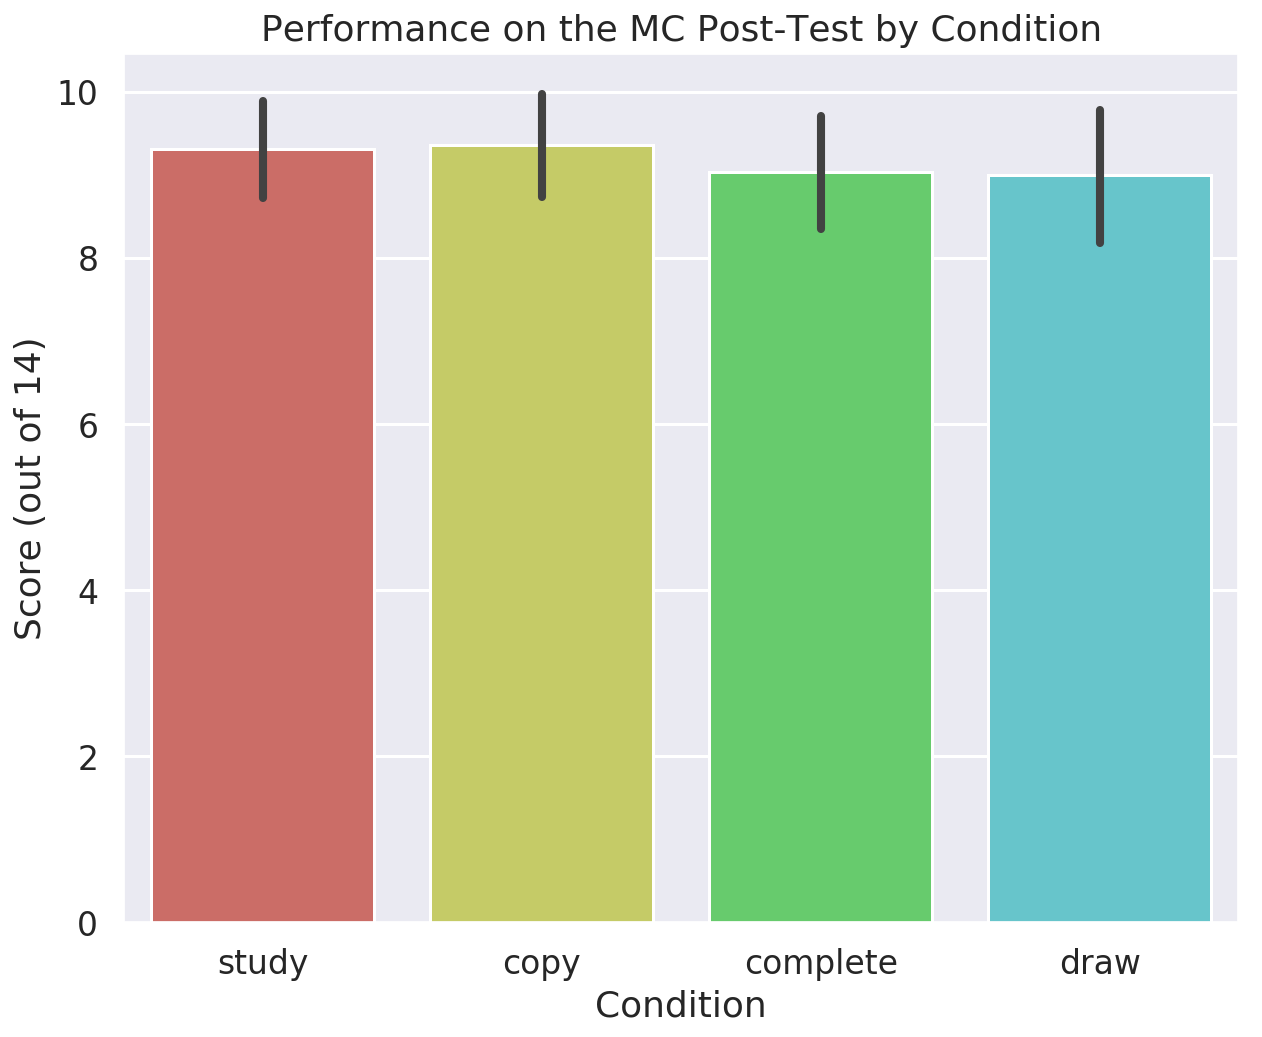

In [51]:
sns.barplot(
    y="posttest_score",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Performance on the MC Post-Test by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (out of 14)")

Multiple choice gain 

Mean: 3.013 	Standard_dev: 2.459

Min: -3.0 	Median: 3.0 	Max: 11.0


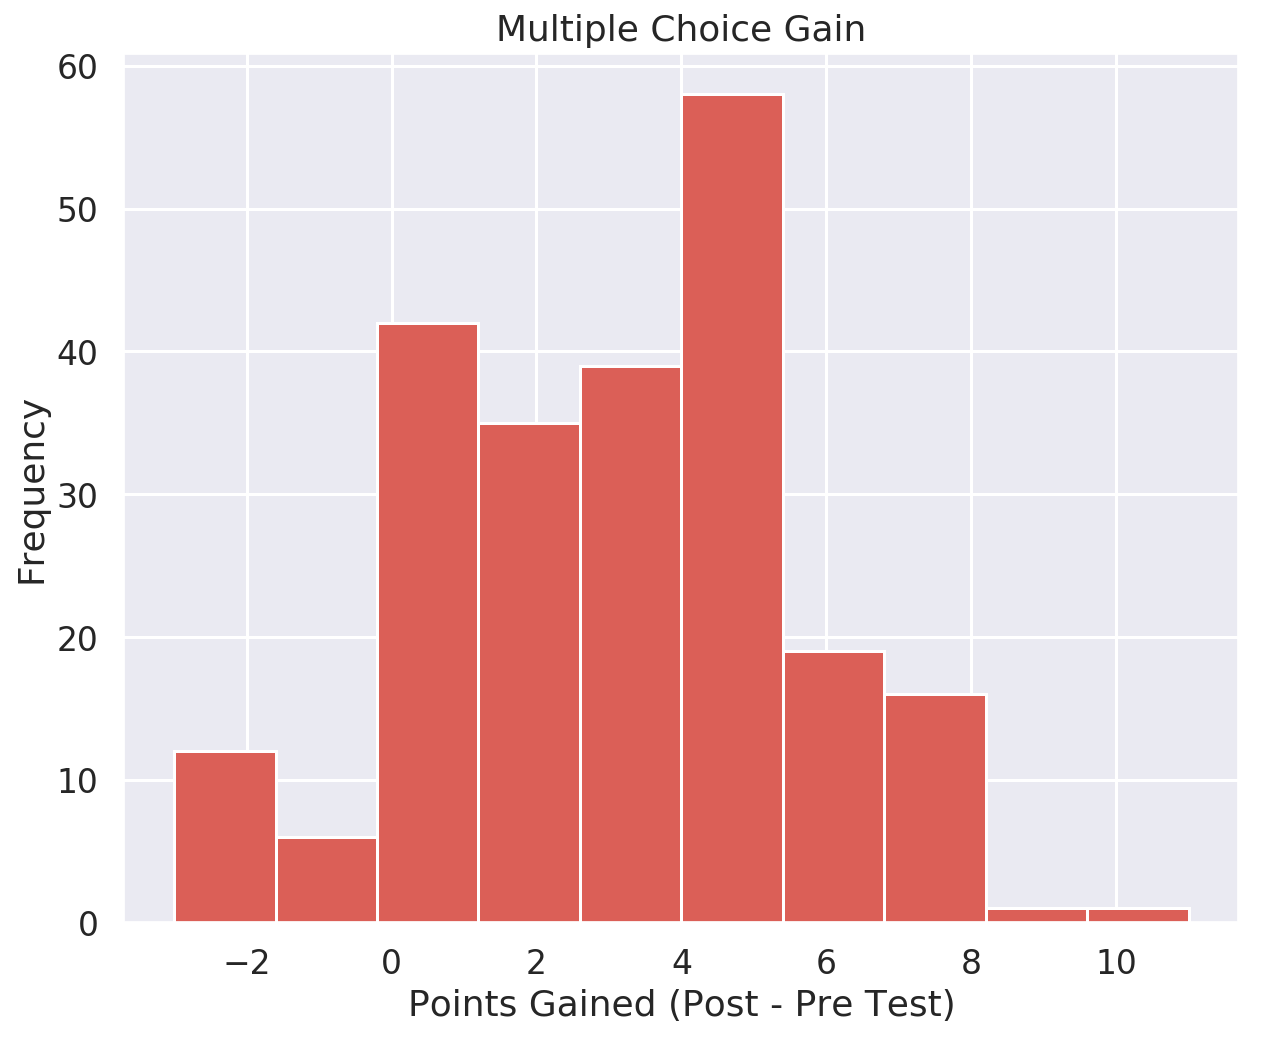

In [52]:
# MC-Gain

plt.hist(small_df_seasons["mc_gain"], bins=10, label="mc_gain")

plt.title("Multiple Choice Gain")
plt.xlabel("Points Gained (Post - Pre Test)")
plt.ylabel("Frequency")


mc_gain_min = round(small_df_seasons["mc_gain"].min(), 3)
mc_gain_max = round(small_df_seasons["mc_gain"].max(), 3)
mc_gain_mean = round(small_df_seasons["mc_gain"].mean(), 3)
mc_gain_std = round(small_df_seasons["mc_gain"].std(), 3)
mc_gain_med = round(small_df_seasons["mc_gain"].median(), 3)


print(
    "Multiple choice gain \n\nMean: " + str(mc_gain_mean),
    "\tStandard_dev: " + str(mc_gain_std),
)
print(
    "\nMin: " + str(mc_gain_min),
    "\tMedian: " + str(mc_gain_med),
    "\tMax: " + str(mc_gain_max),
)

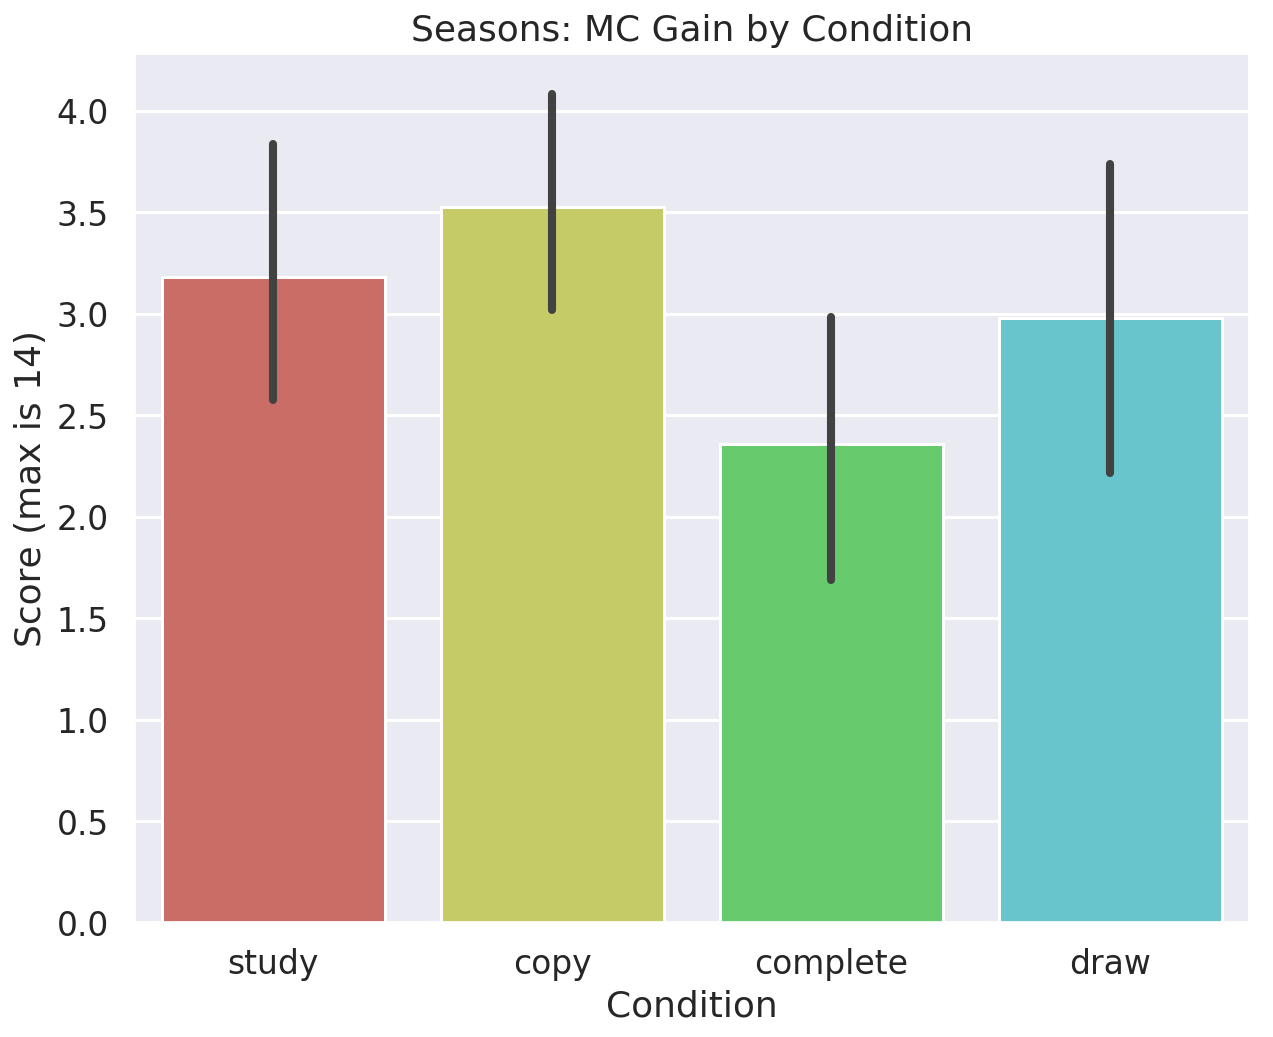

In [53]:
sns.barplot(
    y="mc_gain",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Seasons: MC Gain by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (max is 14)")

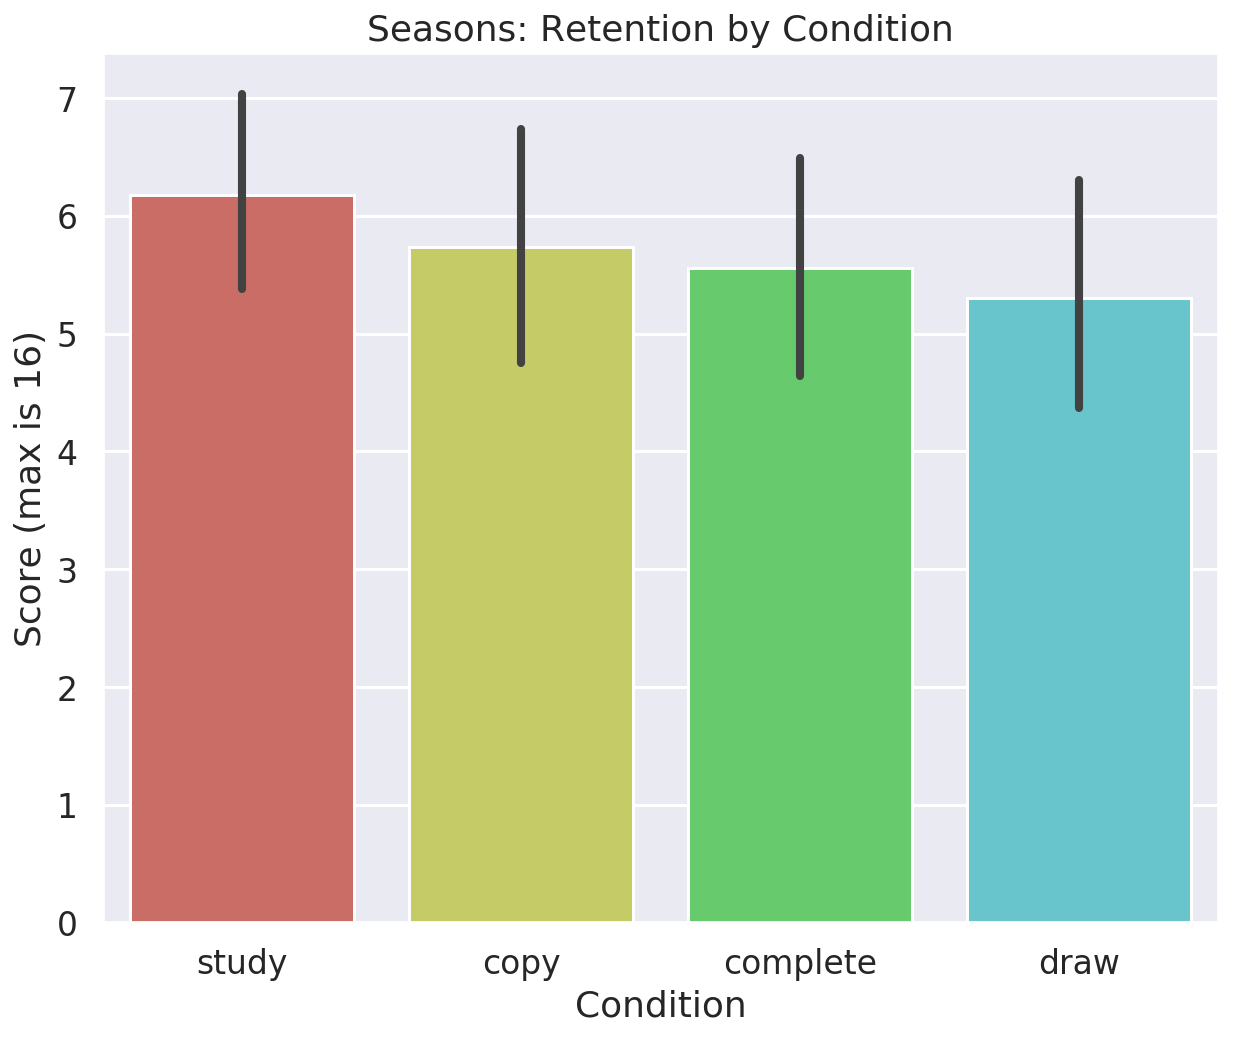

In [55]:
sns.barplot(
    y="retention_lower",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Seasons: Retention by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (max is 16)")

Retention 

Mean: 5.721 	Standard_dev: 3.679

Min: 0 	Median: 6.0 	Max: 14


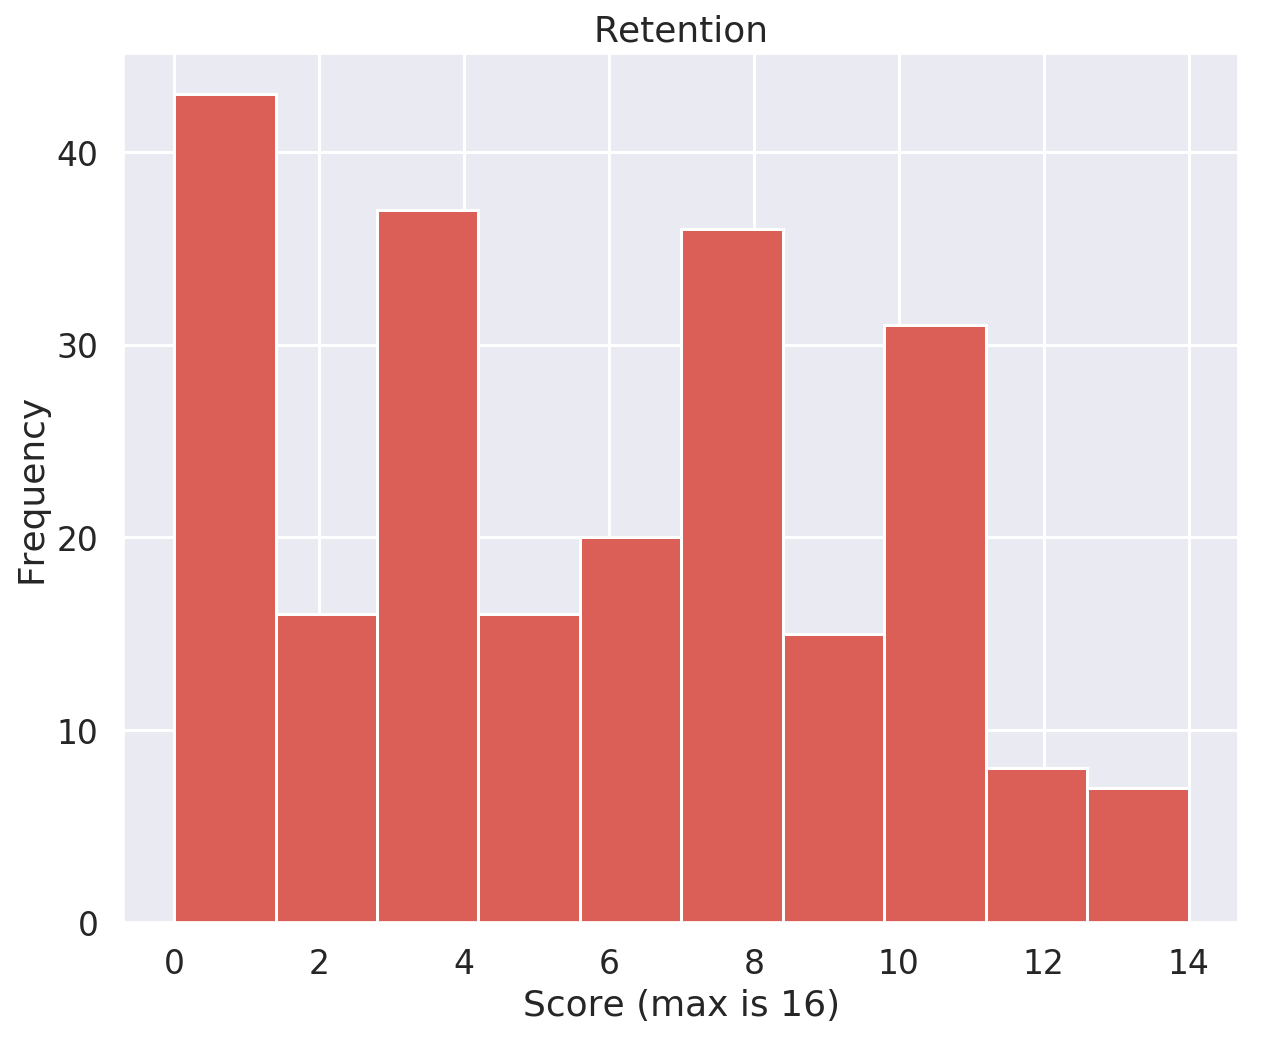

In [56]:
# Retention

plt.hist(small_df_seasons["retention_lower"], bins=10, label="retention")

plt.title("Retention")
plt.xlabel("Score (max is 16)")
plt.ylabel("Frequency")


ret_min = round(small_df_seasons["retention_lower"].min(), 3)
ret_max = round(small_df_seasons["retention_lower"].max(), 3)
ret_mean = round(small_df_seasons["retention_lower"].mean(), 3)
ret_std = round(small_df_seasons["retention_lower"].std(), 3)
ret_med = round(small_df_seasons["retention_lower"].median(), 3)


print("Retention \n\nMean: " + str(ret_mean), "\tStandard_dev: " + str(ret_std))
print("\nMin: " + str(ret_min), "\tMedian: " + str(ret_med), "\tMax: " + str(ret_max))

Test A

Mean: 9.188 	Min: 1.0 	Standard dev: 2.569

Median: 10.0 	Min: 1.0 	Max: 13.0


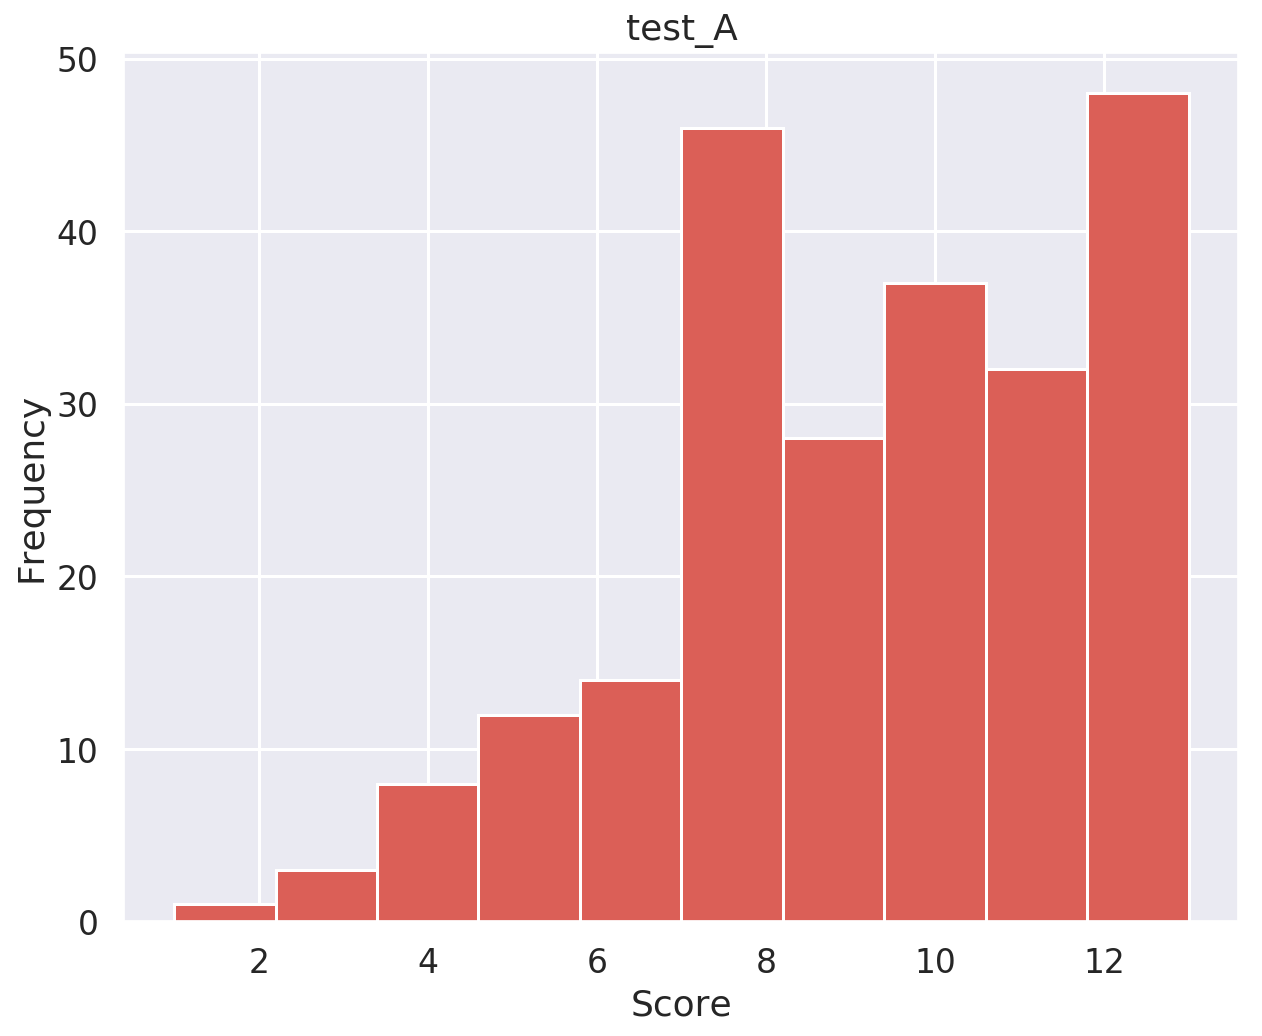

In [63]:
test_a = plt.hist(small_df_seasons["test_A"], bins=10)

plt.title("test_A")
plt.xlabel("Score")
plt.ylabel("Frequency")

f3 = plt.gcf()

tA_min = round(small_df_seasons["test_A"].min(), 3)
tA_max = round(small_df_seasons["test_A"].max(), 3)
tA_mean = round(small_df_seasons["test_A"].mean(), 3)
tA_std = round(small_df_seasons["test_A"].std(), 3)
tA_med = round(small_df_seasons["test_A"].median(), 3)

print(
    "Test A\n\nMean: " + str(tA_mean),
    "\tMin: " + str(tA_min),
    "\tStandard dev: " + str(tA_std),
)
print("\nMedian: " + str(tA_med), "\tMin: " + str(tA_min), "\tMax: " + str(tA_max))

In [95]:
anova_enjoyment = ols("cond_enjoyment ~ C(condition)", data=small_df_seasons).fit()
anova_enjoyment.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         cond_enjoyment   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     6.329
Date:                Thu, 09 Jul 2020   Prob (F-statistic):           0.000387
Time:                        18:36:15   Log-Likelihood:                -331.77
No. Observations:                 229   AIC:                             671.5
Df Residuals:                     225   BIC:                             685.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.8361      0.133     21.311      0.000       2.574       3.098
C(condition)[T.copy]     -0.5410      0.188     -2.874      0.004      -0.912      -0.170
C(condition)[T.draw]     -0.8578      0.203     -4.226      0.000      -1.258      -0.458
C(condition)[T.study]    -0.3934      0.188     -2.091      0.038      -0.764      -0.023
==============================================================================
Omnibus:                       12.733   Durbin-Watson:                   2.237
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.523
Skew:                           0.593   Prob(JB):                      0.00116
Kurtosis:                       3.114   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

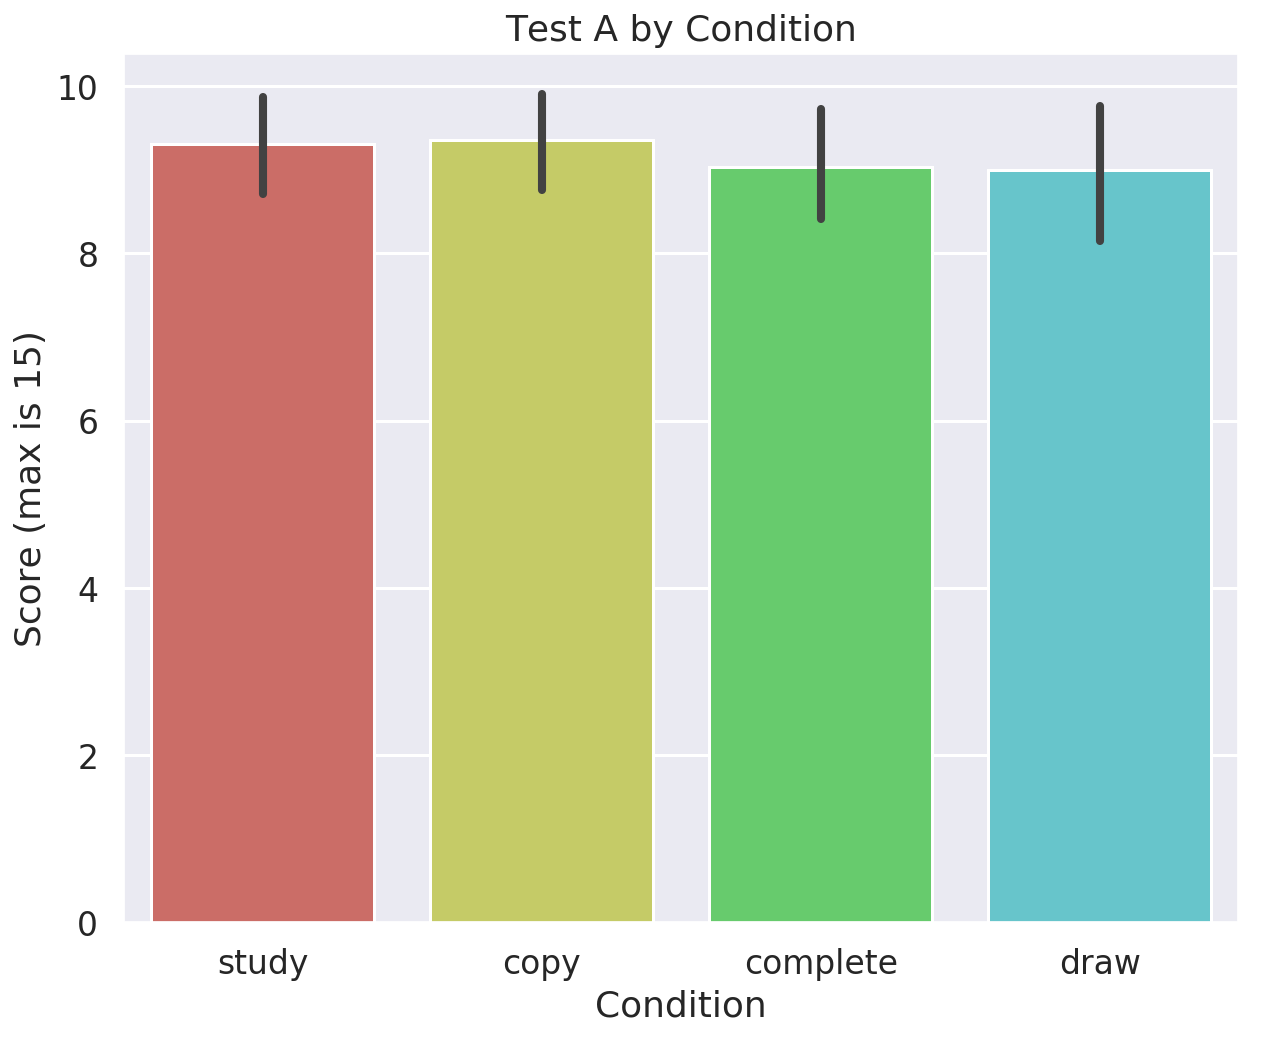

In [64]:
sns.barplot(
    y="test_A",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Test A by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (max is 15)")

Test B

Mean: 6.175 	Min: 1.0 	Standard dev: 2.507

Median: 6.0 	Min: 1.0 	Max: 12.0


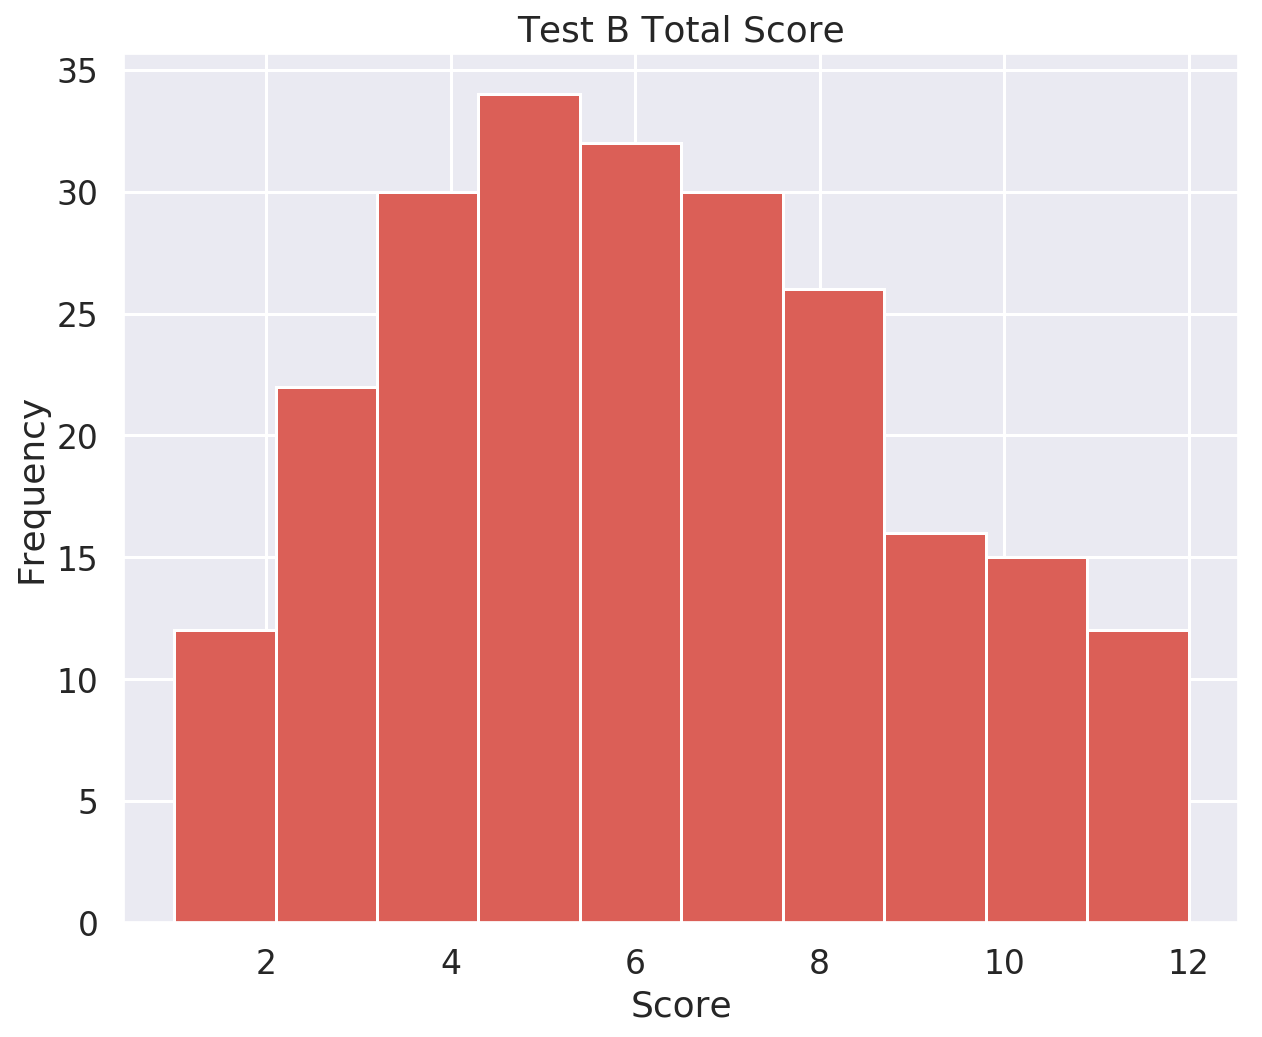

In [65]:
test_b = plt.hist(small_df_seasons["test_B"], bins=10)

plt.title("Test B Total Score")
plt.xlabel("Score")
plt.ylabel("Frequency")

f4 = plt.gcf()

tB_min = round(small_df_seasons["test_B"].min(), 3)
tB_max = round(small_df_seasons["test_B"].max(), 3)
tB_mean = round(small_df_seasons["test_B"].mean(), 3)
tB_std = round(small_df_seasons["test_B"].std(), 3)
tB_med = round(small_df_seasons["test_B"].median(), 3)

print(
    "Test B\n\nMean: " + str(tB_mean),
    "\tMin: " + str(tB_min),
    "\tStandard dev: " + str(tB_std),
)
print("\nMedian: " + str(tB_med), "\tMin: " + str(tB_min), "\tMax: " + str(tB_max))

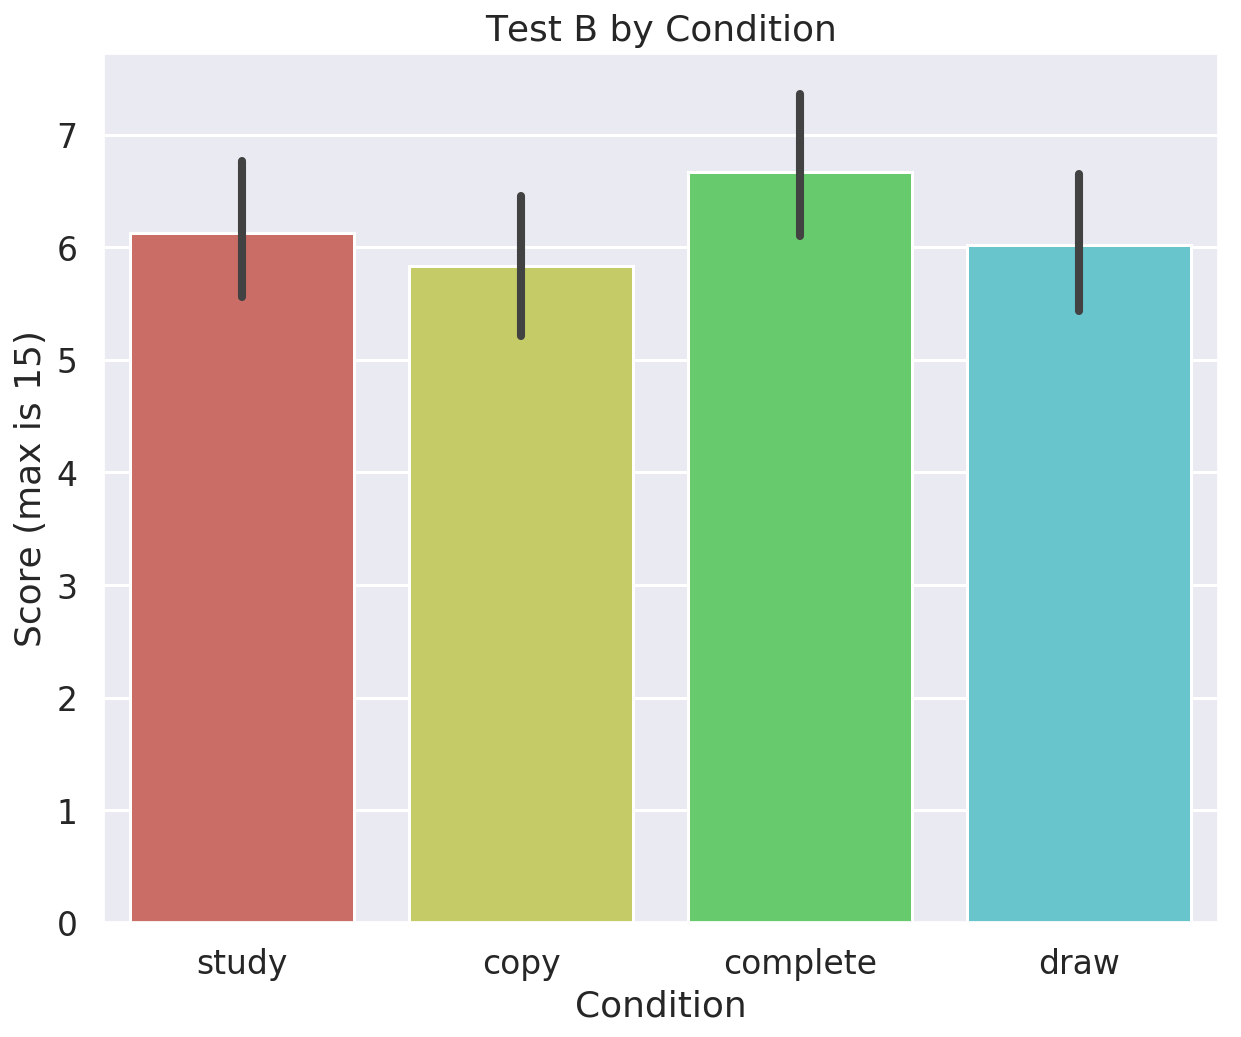

In [66]:
sns.barplot(
    y="test_B",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Test B by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (max is 15)")

Paper Folding Test 

Mean: 7.175 	Standard dev: 2.126

Min: 1 	Median: 8.0 	Max: 10


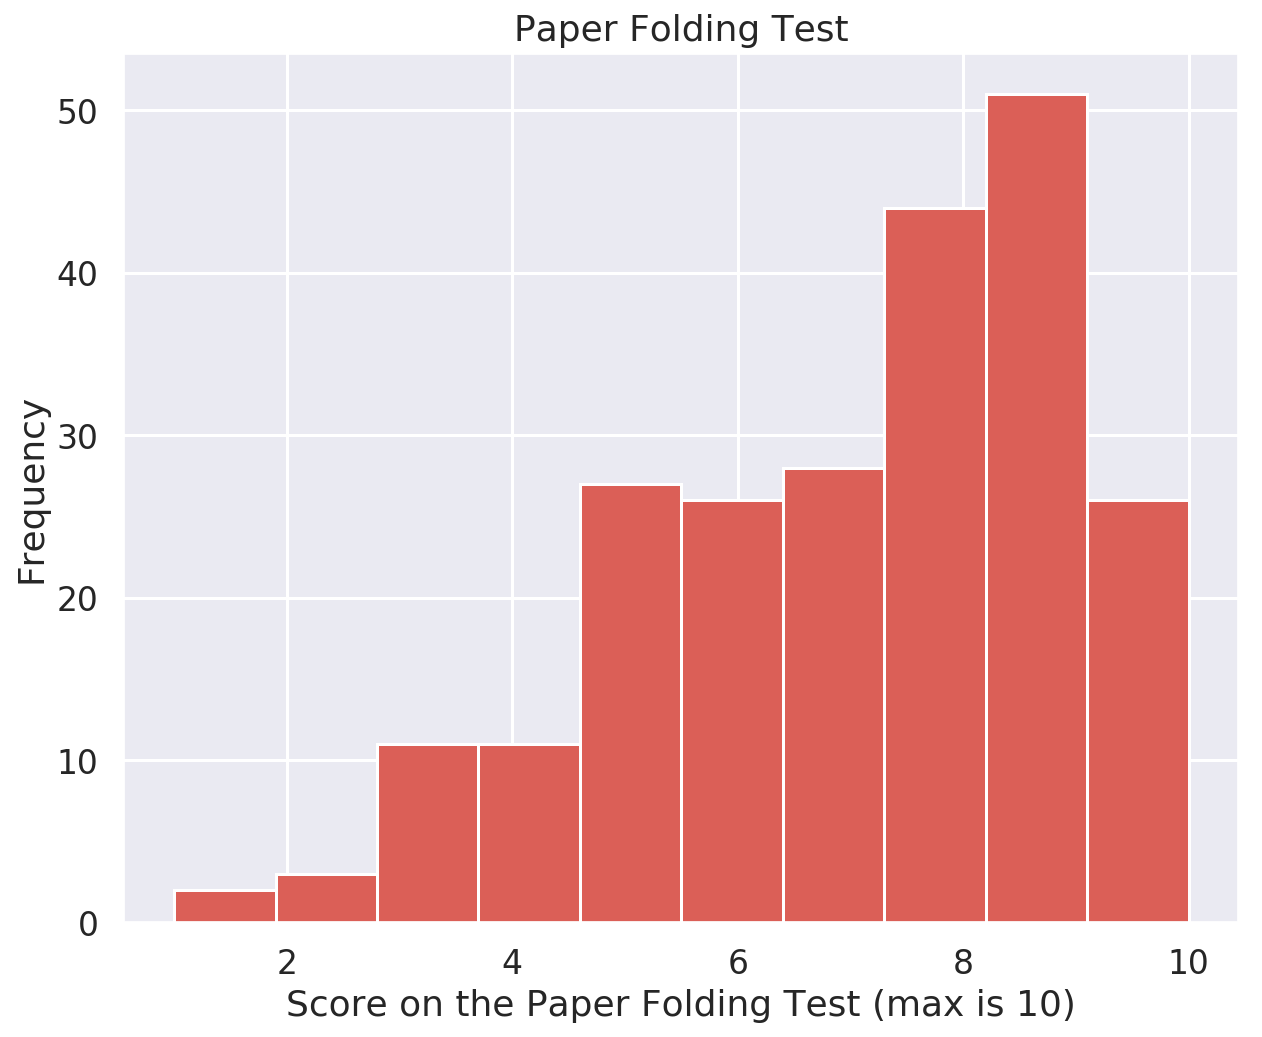

In [67]:
# Histogram of paper total
vviq = plt.hist(small_df_seasons["paper_total"], bins=10, label="Paper Folding Test")

plt.title("Paper Folding Test")
plt.xlabel("Score on the Paper Folding Test (max is 10)")
plt.ylabel("Frequency")


pft_min = round(small_df_seasons["paper_total"].min(), 3)
pft_max = round(small_df_seasons["paper_total"].max(), 3)
pft_mean = round(small_df_seasons["paper_total"].mean(), 3)
pft_std = round(small_df_seasons["paper_total"].std(), 3)
pft_med = round(small_df_seasons["paper_total"].median(), 3)


print(
    "Paper Folding Test \n\nMean: " + str(pft_mean), "\tStandard dev: " + str(pft_std)
)
print("\nMin: " + str(pft_min), "\tMedian: " + str(pft_med), "\tMax: " + str(pft_max))

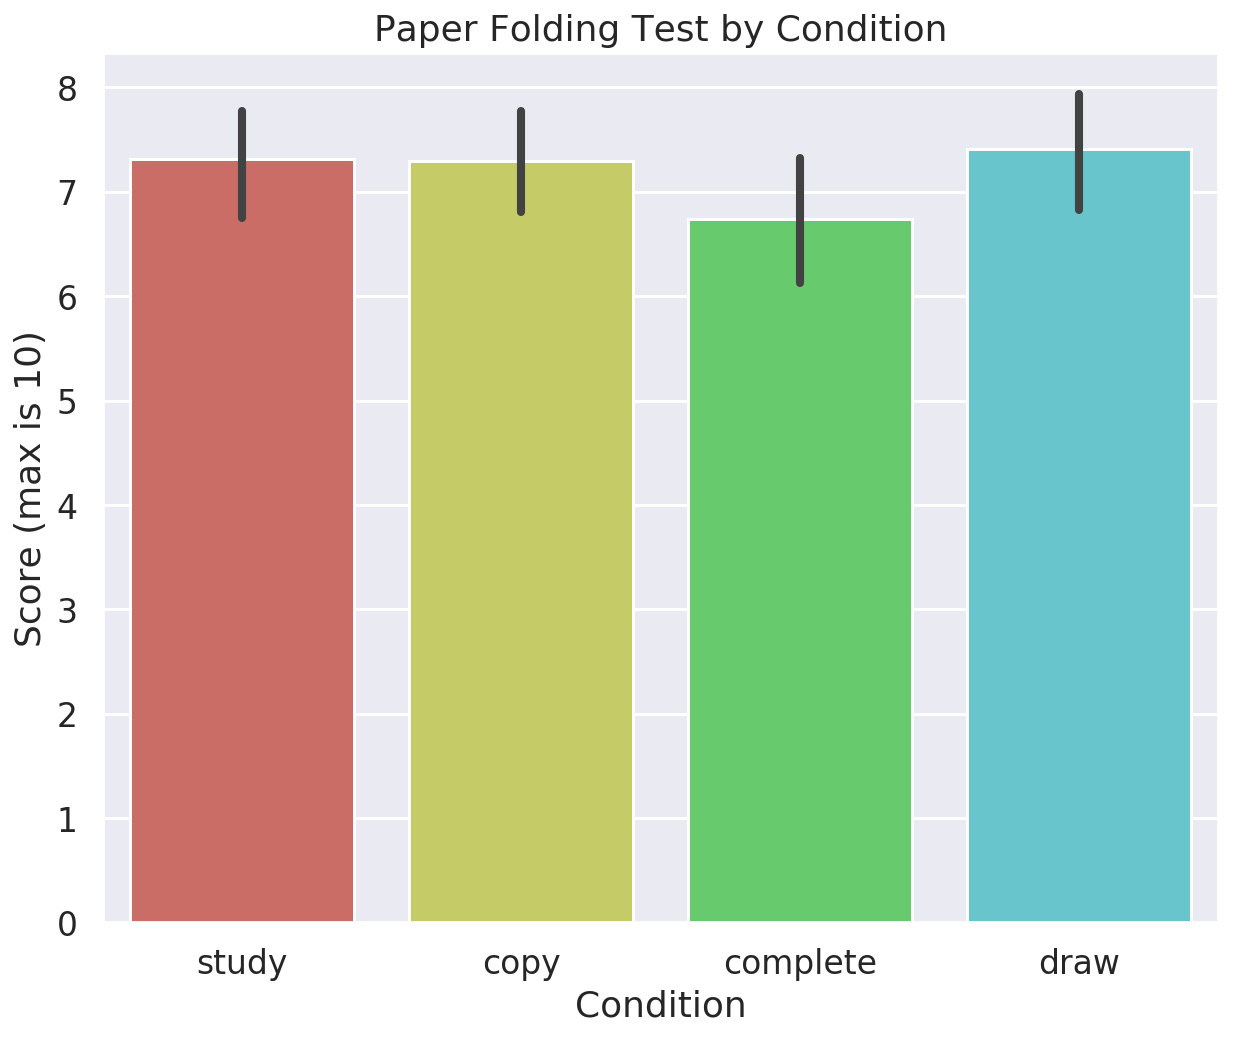

In [68]:
sns.barplot(
    y="paper_total",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Paper Folding Test by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (max is 10)")

In [69]:
anova_vviq = ols("paper_total ~ C(condition)", data=small_df_seasons).fit()
anova_vviq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            paper_total   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.204
Date:                Thu, 09 Jul 2020   Prob (F-statistic):              0.309
Time:                        18:36:05   Log-Likelihood:                -495.39
No. Observations:                 229   AIC:                             998.8
Df Residuals:                     225   BIC:                             1013.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 6.7377      0.272     24.780      0.000       6.202       7.274
C(condition)[T.copy]      0.5574      0.385      1.449      0.149      -0.200       1.315
C(condition)[T.draw]      0.6753      0.415      1.629      0.105      -0.142       1.493
C(condition)[T.study]     0.5738      0.385      1.492      0.137      -0.184       1.332
==============================================================================
Omnibus:                       14.014   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.853
Skew:                          -0.595   Prob(JB):                     0.000595
Kurtosis:                       2.626   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


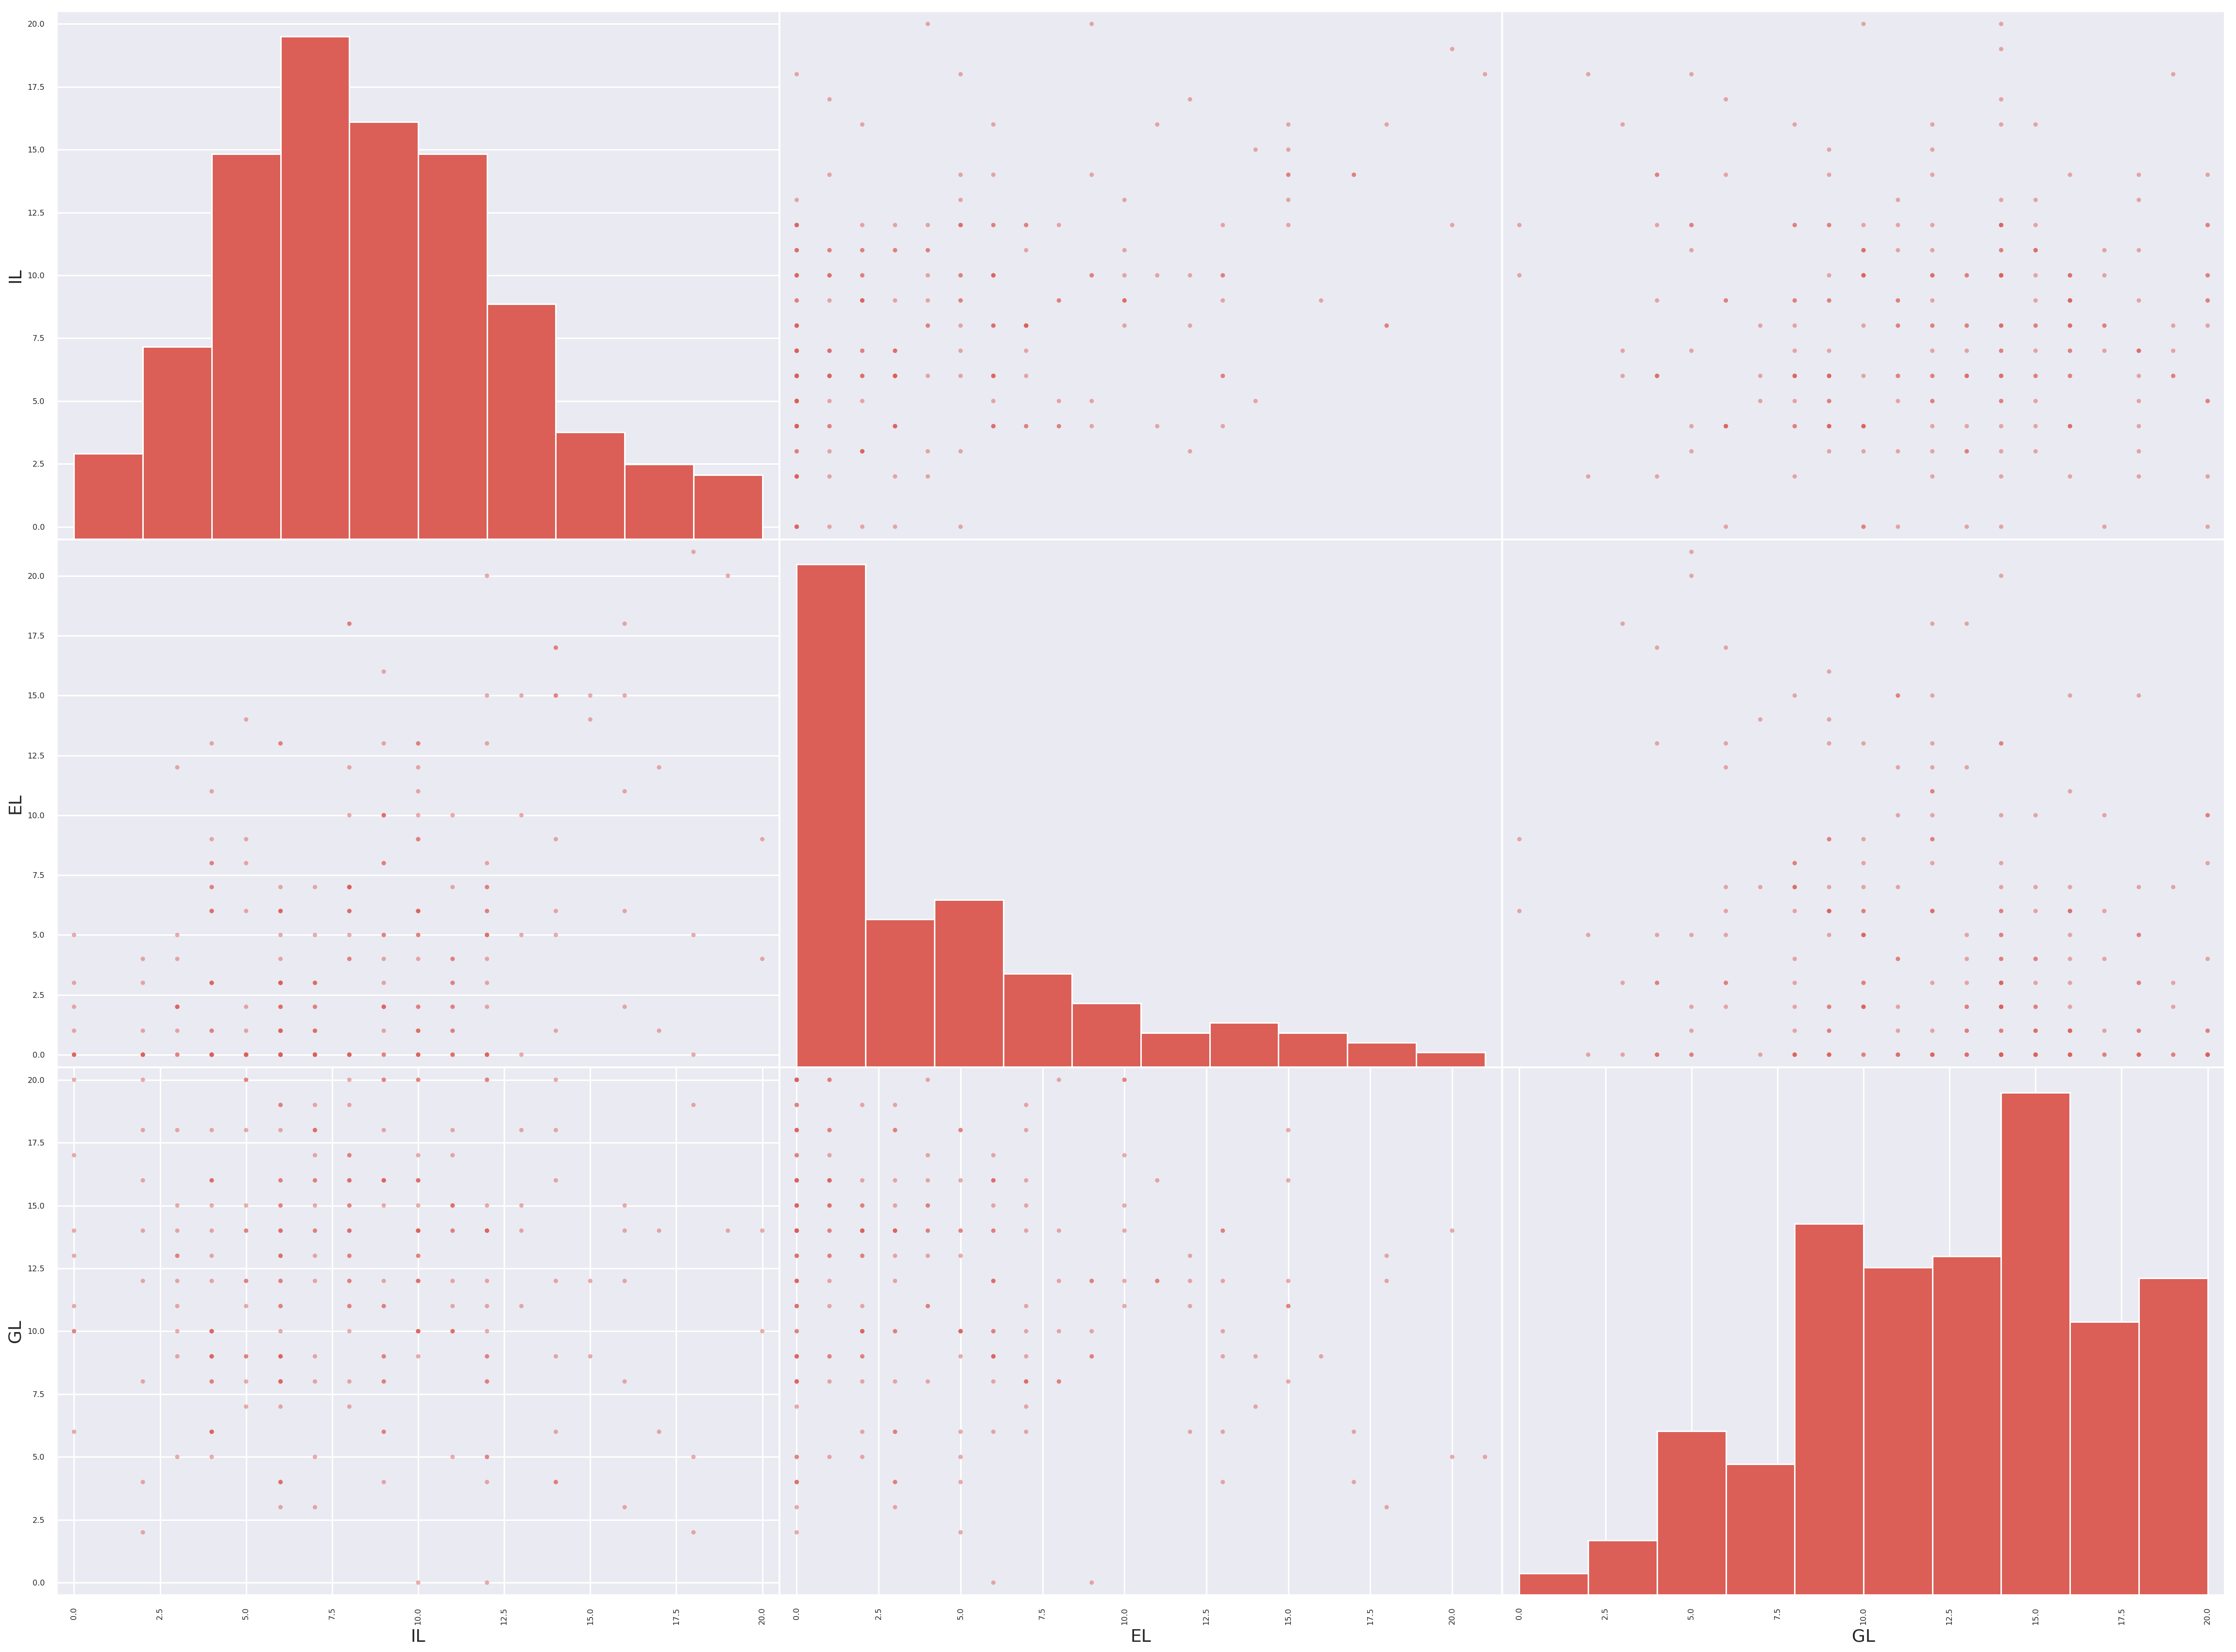

In [71]:
cols = ["IL", "EL", "GL"]

pd.scatter_matrix(small_df_seasons[cols], figsize=(40, 30), diagonal="hist")

f5 = plt.gcf()

Cognitive Load 

Mean: 24.769 	Max: 8.251

Min: 4 	Median: 24.0 	Max: 53


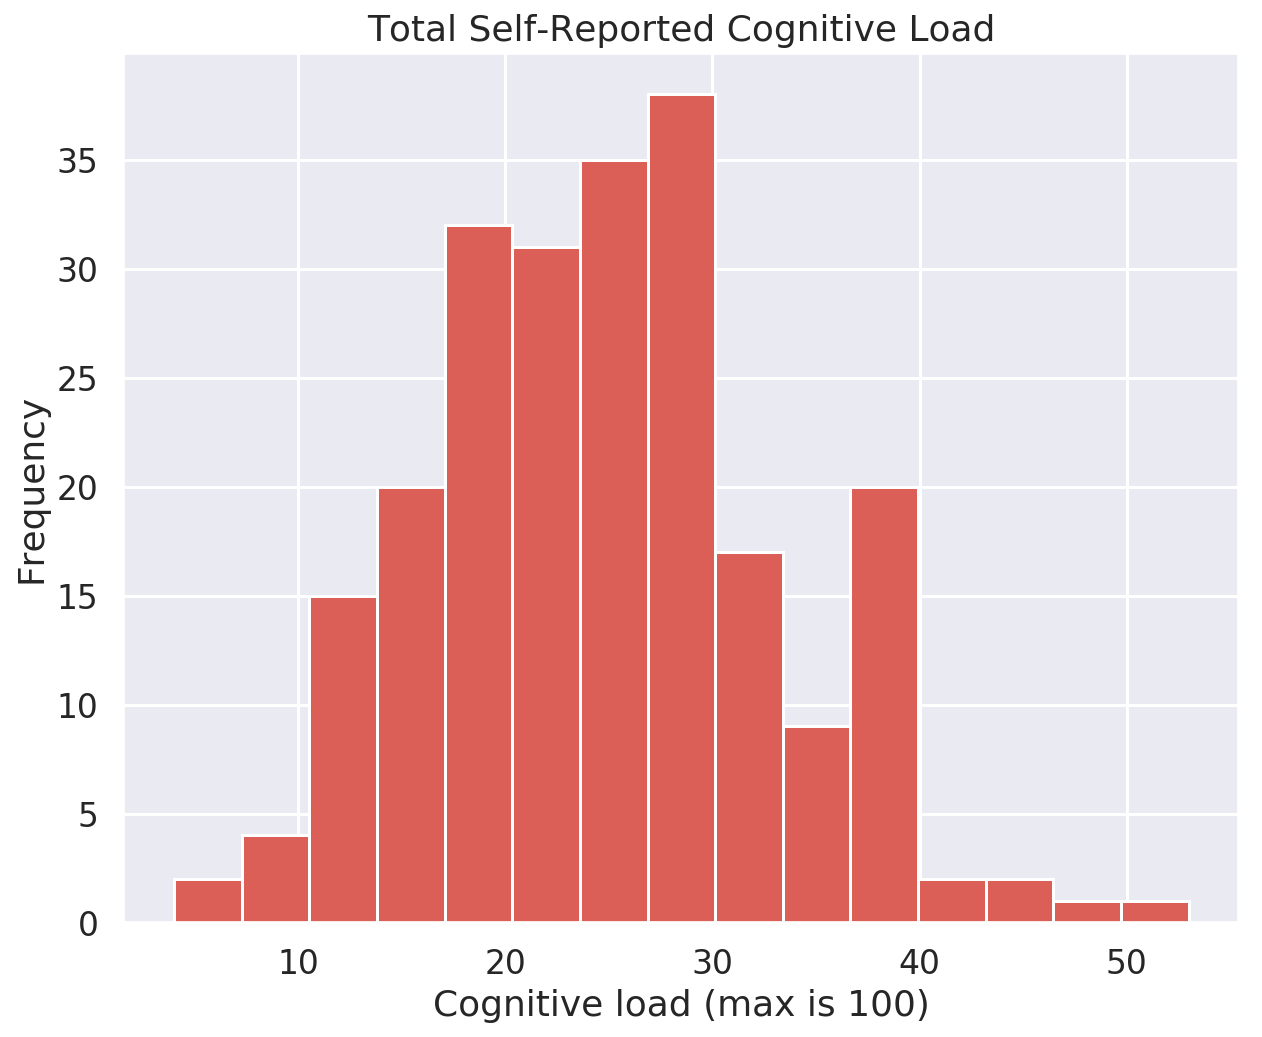

In [72]:
# Histogram total cognitive load
tot_cl = plt.hist(small_df_seasons["CL"], bins=15, label="Total CL")

plt.title("Total Self-Reported Cognitive Load")
plt.xlabel("Cognitive load (max is 100)")
plt.ylabel("Frequency")

cl_min = round(small_df_seasons["CL"].min(), 3)
cl_max = round(small_df_seasons["CL"].max(), 3)
cl_mean = round(small_df_seasons["CL"].mean(), 3)
cl_std = round(small_df_seasons["CL"].std(), 3)
cl_med = round(small_df_seasons["CL"].median(), 3)

print("Cognitive Load \n\nMean: " + str(cl_mean), "\tMax: " + str(cl_std))
print("\nMin: " + str(cl_min), "\tMedian: " + str(cl_med), "\tMax: " + str(cl_max))

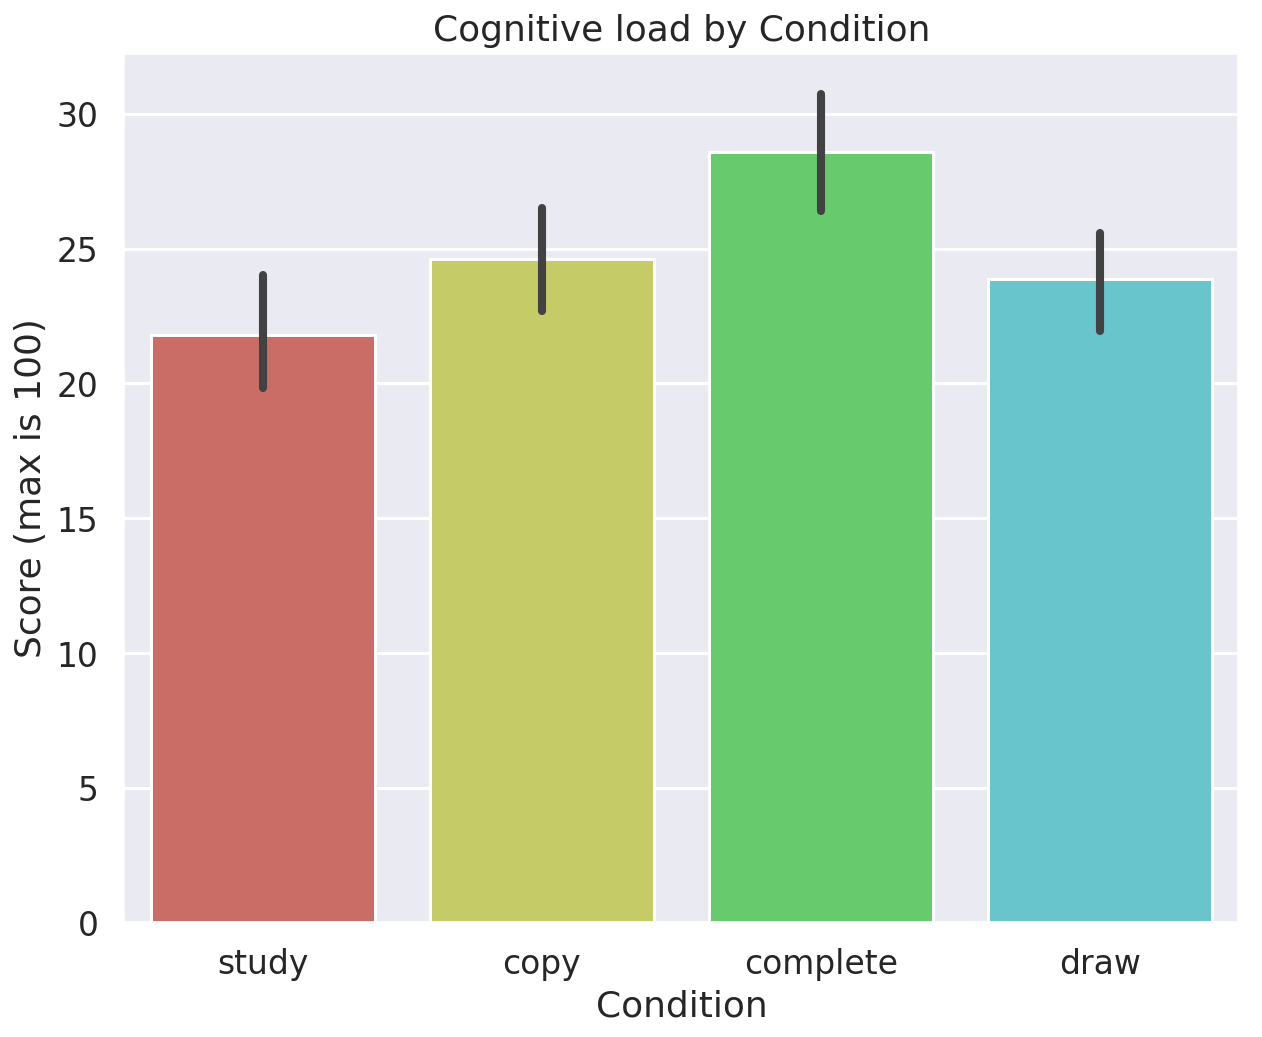

In [73]:
sns.barplot(
    y="CL",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Cognitive load by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (max is 100)")

In [74]:
anova_cl = ols("CL ~ C(condition)", data=small_df_seasons).fit()
anova_cl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     CL   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     7.778
Date:                Thu, 09 Jul 2020   Prob (F-statistic):           5.78e-05
Time:                        18:36:09   Log-Likelihood:                -796.39
No. Observations:                 229   AIC:                             1601.
Df Residuals:                     225   BIC:                             1615.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                28.5738      1.012     28.229      0.000      26.579      30.568
C(condition)[T.copy]     -3.9672      1.431     -2.771      0.006      -6.788      -1.146
C(condition)[T.draw]     -4.7042      1.544     -3.047      0.003      -7.746      -1.662
C(condition)[T.study]    -6.7705      1.431     -4.730      0.000      -9.591      -3.950
==============================================================================
Omnibus:                        3.176   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.204   Jarque-Bera (JB):                2.795
Skew:                           0.241   Prob(JB):                        0.247
Kurtosis:                       3.246   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Retention test score')

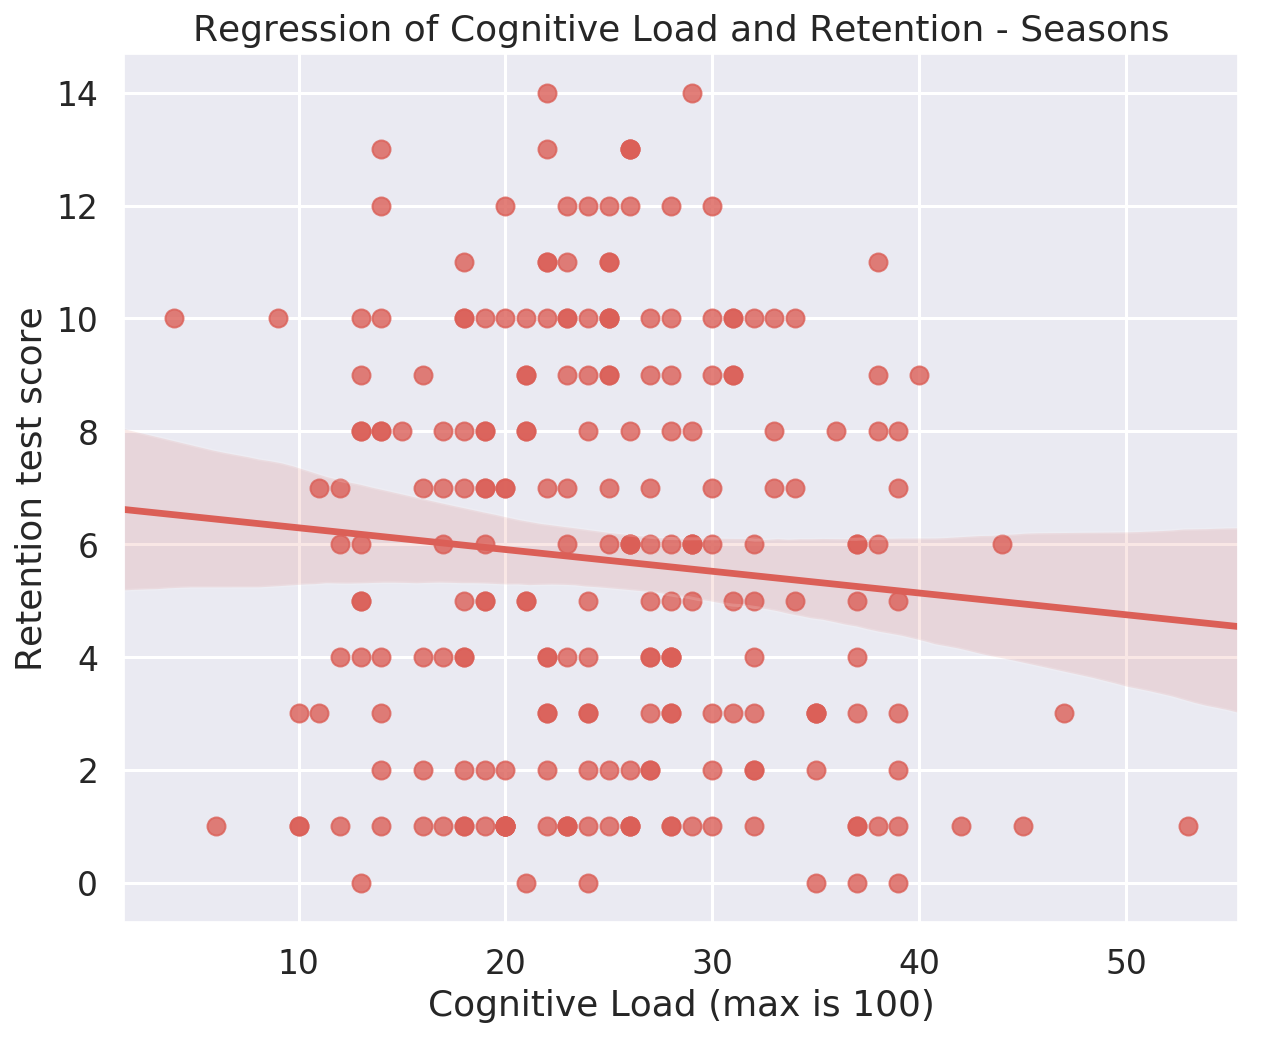

In [75]:
sns.regplot(x="CL", y="retention_lower", data=small_df_seasons)

plt.title("Regression of Cognitive Load and Retention - Seasons")
plt.xlabel("Cognitive Load (max is 100)")
plt.ylabel("Retention test score")

Intrinsic Load 

Mean: 8.039 	Standard_dev: 4.118

Min: 0 	Median: 8.0 	Max: 20


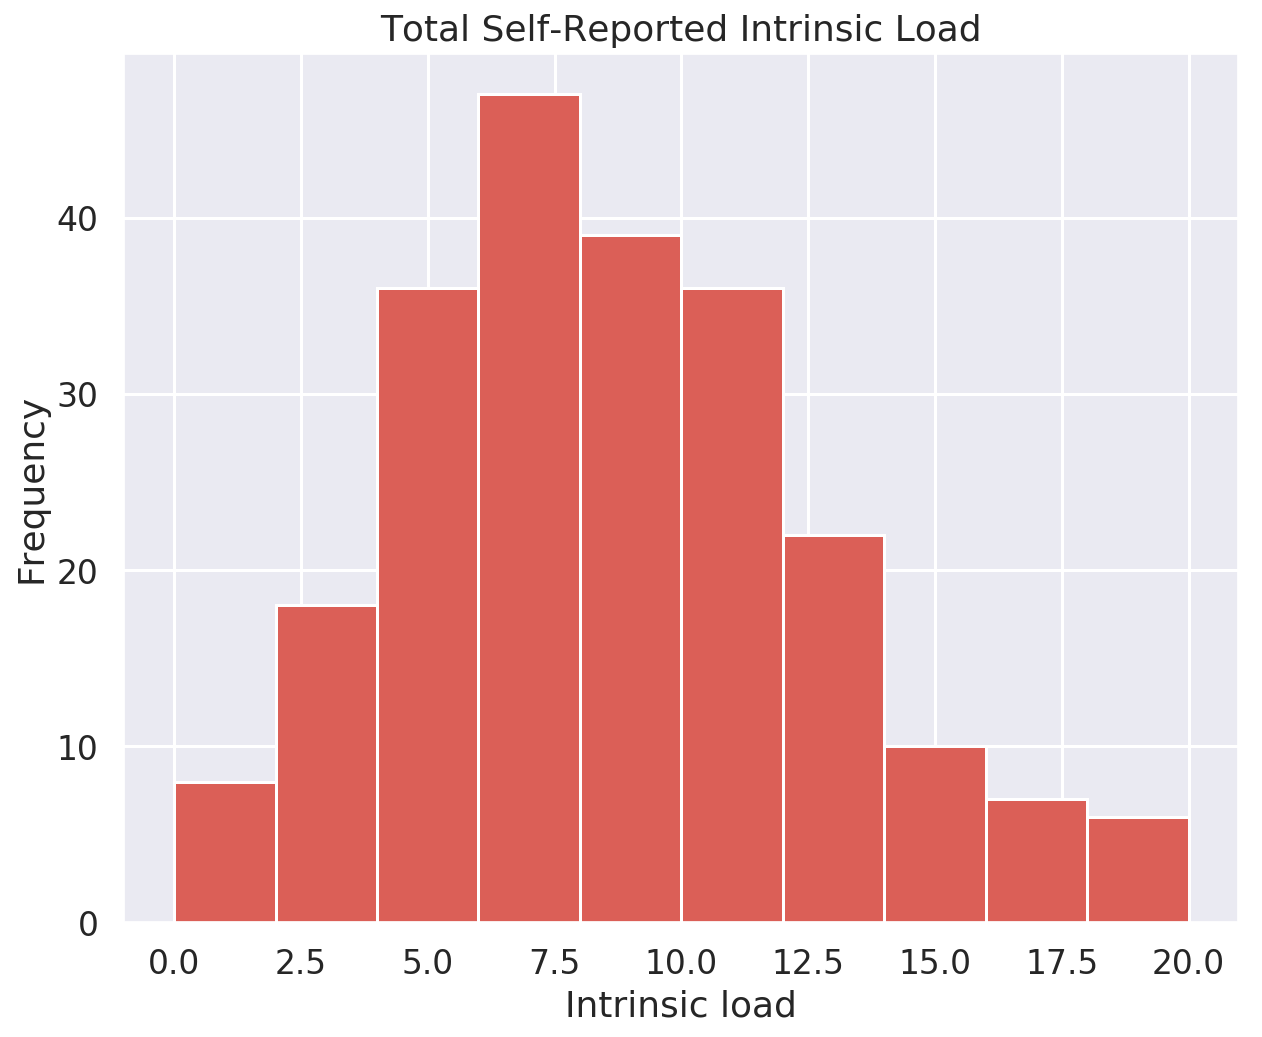

In [76]:
plt.hist(small_df_seasons["IL"], bins=10, label="IL")


plt.title("Total Self-Reported Intrinsic Load")
plt.xlabel("Intrinsic load")
plt.ylabel("Frequency")


il_min = round(small_df_seasons["IL"].min(), 3)
il_max = round(small_df_seasons["IL"].max(), 3)
il_mean = round(small_df_seasons["IL"].mean(), 3)
il_std = round(small_df_seasons["IL"].std(), 3)
il_med = round(small_df_seasons["IL"].median(), 3)


print("Intrinsic Load \n\nMean: " + str(il_mean), "\tStandard_dev: " + str(il_std))
print("\nMin: " + str(il_min), "\tMedian: " + str(il_med), "\tMax: " + str(il_max))

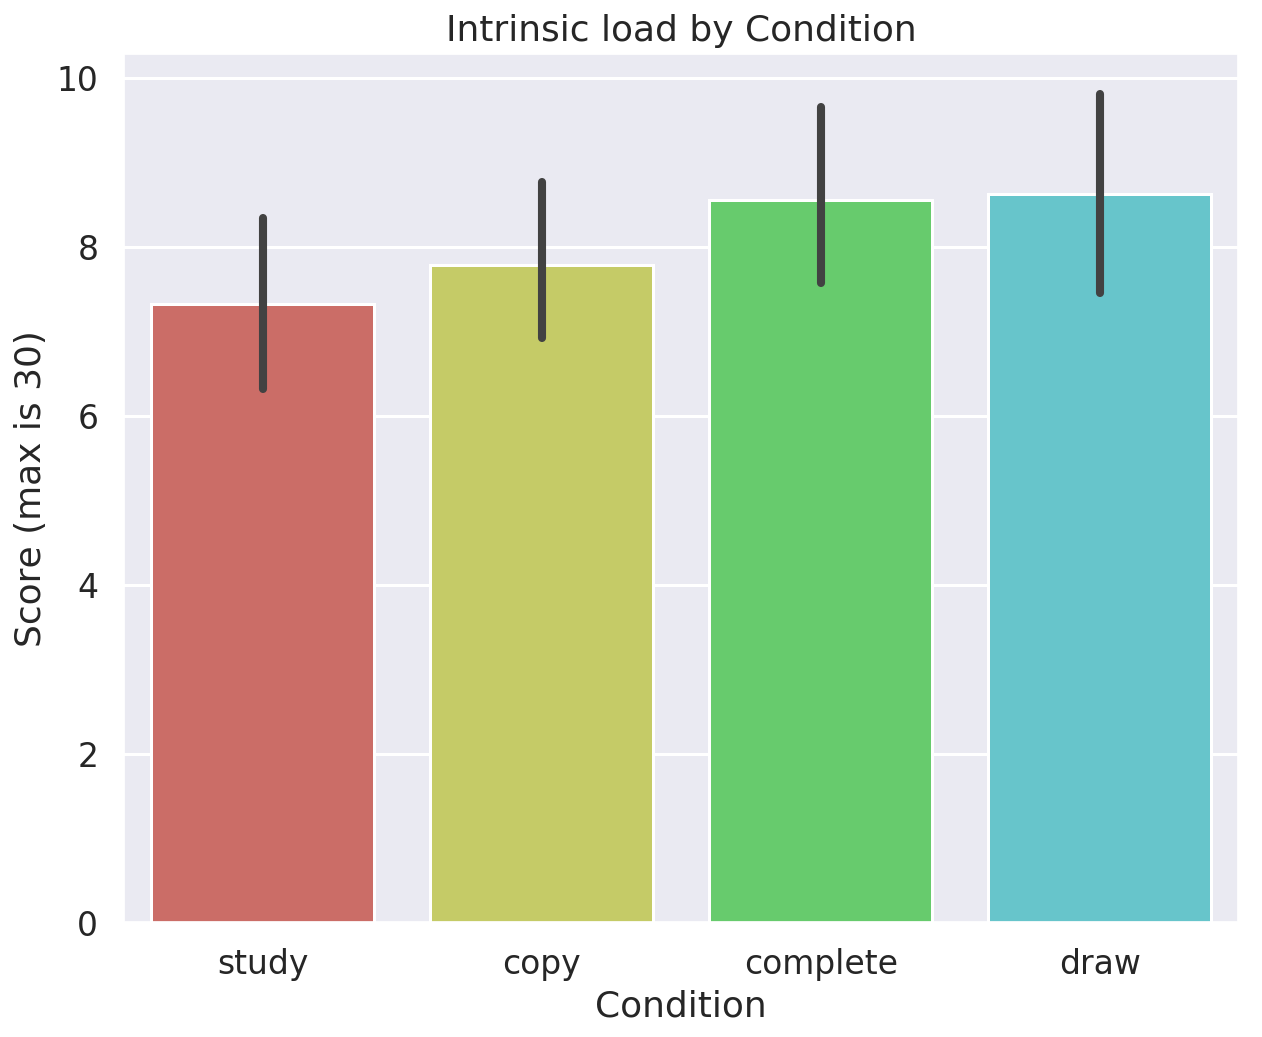

In [77]:
sns.barplot(
    y="IL",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Intrinsic load by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (max is 30)")

In [78]:
anova_il = ols("IL ~ C(condition)", data=small_df_seasons).fit()
anova_il.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     IL   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.327
Date:                Thu, 09 Jul 2020   Prob (F-statistic):              0.266
Time:                        18:36:10   Log-Likelihood:                -646.55
No. Observations:                 229   AIC:                             1301.
Df Residuals:                     225   BIC:                             1315.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.5574      0.526     16.264      0.000       7.521       9.594
C(condition)[T.copy]     -0.7705      0.744     -1.035      0.302      -2.237       0.696
C(condition)[T.draw]      0.0731      0.802      0.091      0.928      -1.508       1.654
C(condition)[T.study]    -1.2295      0.744     -1.652      0.100      -2.696       0.237
==============================================================================
Omnibus:                        7.347   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.362
Skew:                           0.438   Prob(JB):                       0.0252
Kurtosis:                       3.055   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Germane Load 

Mean: 12.048 	Standard dev: 4.518

Min: 0 	Median: 12.0 	Max: 20


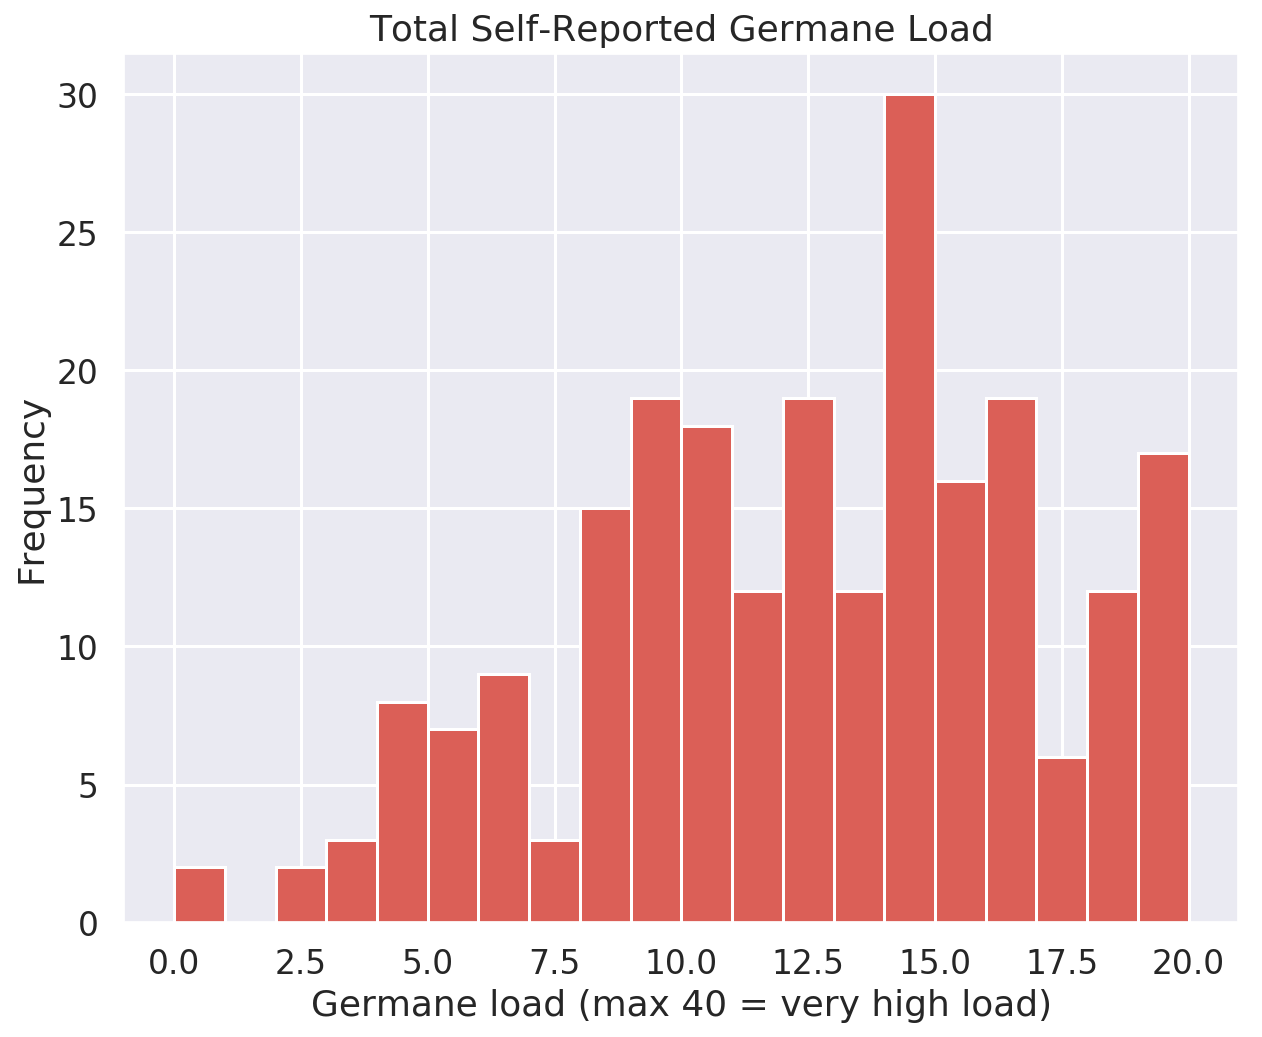

In [80]:
plt.hist(small_df_seasons["GL"], bins=20, label="GL")


plt.title("Total Self-Reported Germane Load")
plt.xlabel("Germane load (max 40 = very high load)")
plt.ylabel("Frequency")


gl_min = round(small_df_seasons["GL"].min(), 3)
gl_max = round(small_df_seasons["GL"].max(), 3)
gl_mean = round(small_df_seasons["GL"].mean(), 3)
gl_std = round(small_df_seasons["GL"].std(), 3)
gl_med = round(small_df_seasons["GL"].median(), 3)


print("Germane Load \n\nMean: " + str(gl_mean), "\tStandard dev: " + str(gl_std))
print("\nMin: " + str(gl_min), "\tMedian: " + str(gl_med), "\tMax: " + str(gl_max))

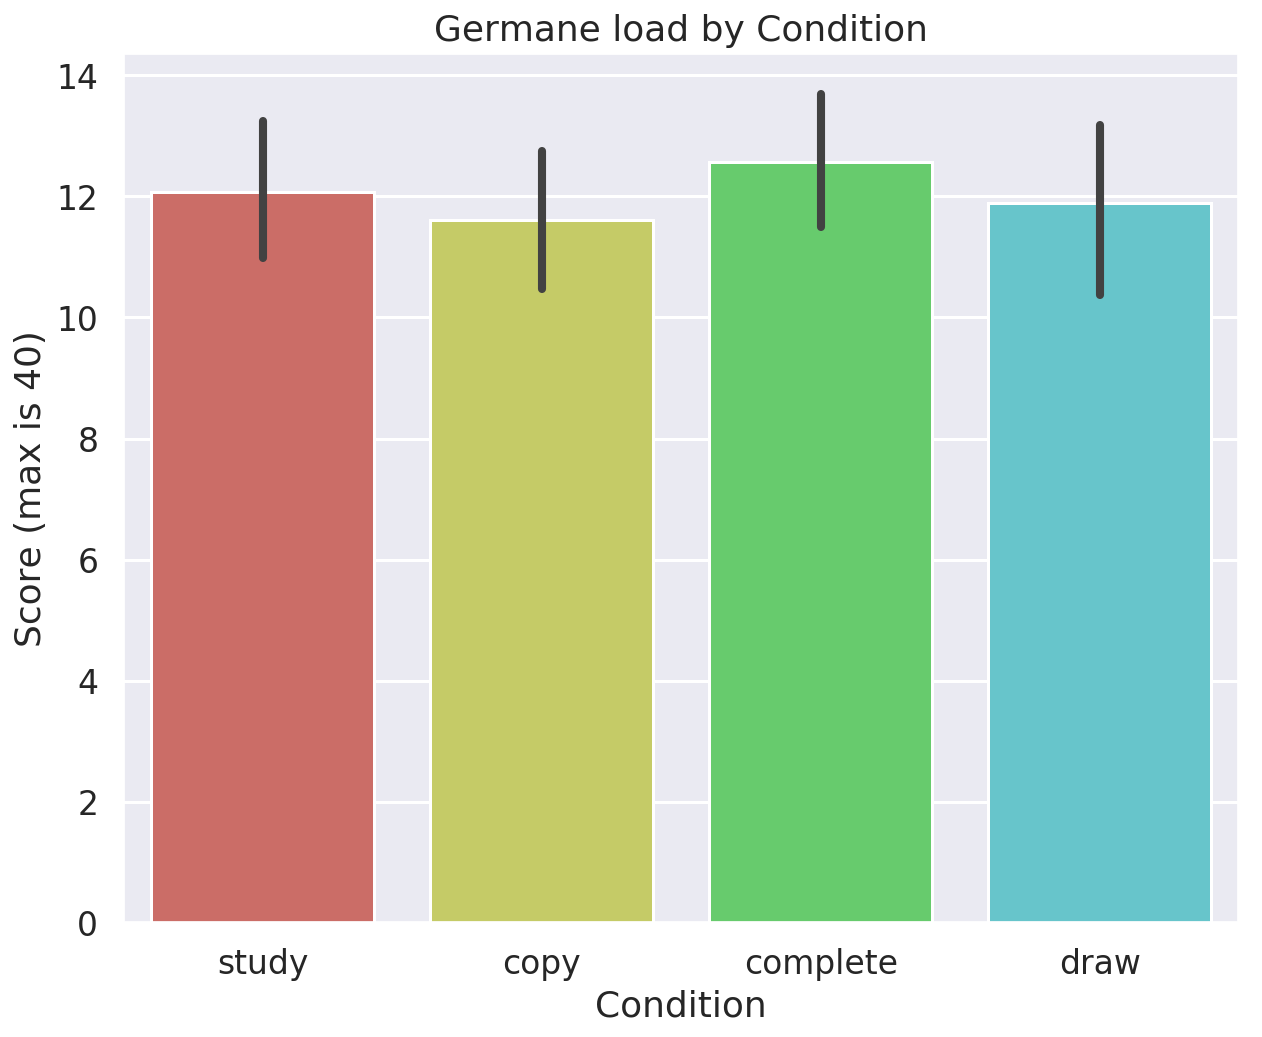

In [81]:
sns.barplot(
    y="GL",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Germane load by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (max is 40)")

In [82]:
anova_gl = ols("GL ~ C(condition)", data=small_df_seasons).fit()
anova_gl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GL   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.4857
Date:                Thu, 09 Jul 2020   Prob (F-statistic):              0.693
Time:                        18:36:12   Log-Likelihood:                -669.06
No. Observations:                 229   AIC:                             1346.
Df Residuals:                     225   BIC:                             1360.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.5738      0.580     21.661      0.000      11.430      13.718
C(condition)[T.copy]     -0.9672      0.821     -1.178      0.240      -2.585       0.650
C(condition)[T.draw]     -0.6825      0.885     -0.771      0.442      -2.427       1.062
C(condition)[T.study]    -0.4918      0.821     -0.599      0.550      -2.109       1.126
==============================================================================
Omnibus:                        6.290   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                5.136
Skew:                          -0.272   Prob(JB):                       0.0767
Kurtosis:                       2.507   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Extraneous Load 

Mean: 4.681 	Standard dev: 4.961

Min: 0 	Median: 3.0 	Max: 21


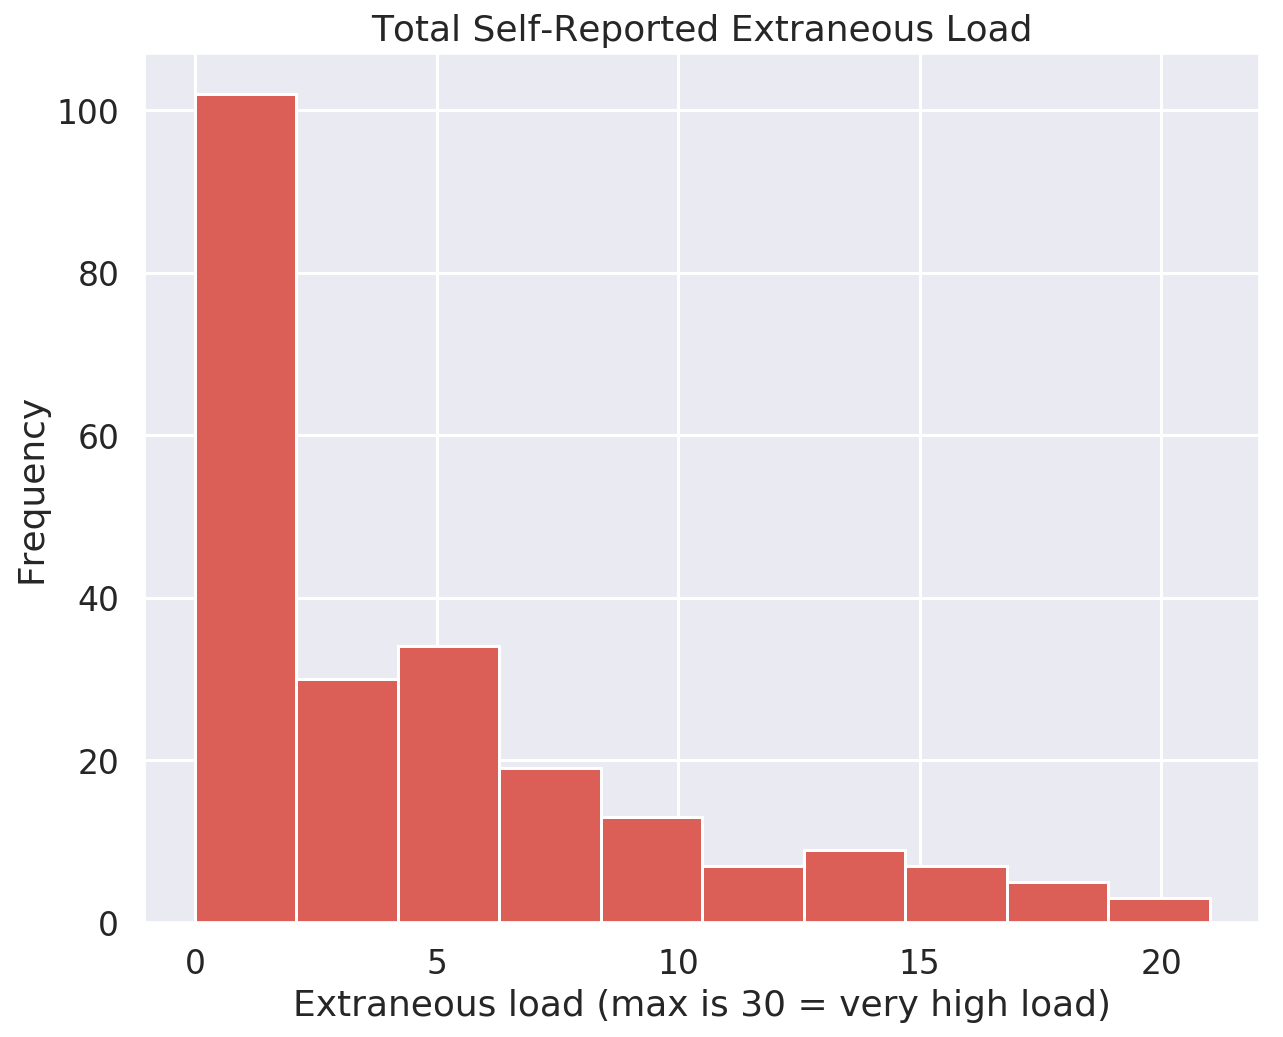

In [84]:
plt.hist(small_df_seasons["EL"], bins=10, label="EL")

plt.title("Total Self-Reported Extraneous Load")
plt.xlabel("Extraneous load (max is 30 = very high load)")
plt.ylabel("Frequency")


el_min = round(small_df_seasons["EL"].min(), 3)
el_max = round(small_df_seasons["EL"].max(), 3)
el_mean = round(small_df_seasons["EL"].mean(), 3)
el_std = round(small_df_seasons["EL"].std(), 3)
el_med = round(small_df_seasons["EL"].median(), 3)


print("Extraneous Load \n\nMean: " + str(el_mean), "\tStandard dev: " + str(el_std))
print("\nMin: " + str(el_min), "\tMedian: " + str(el_med), "\tMax: " + str(el_max))

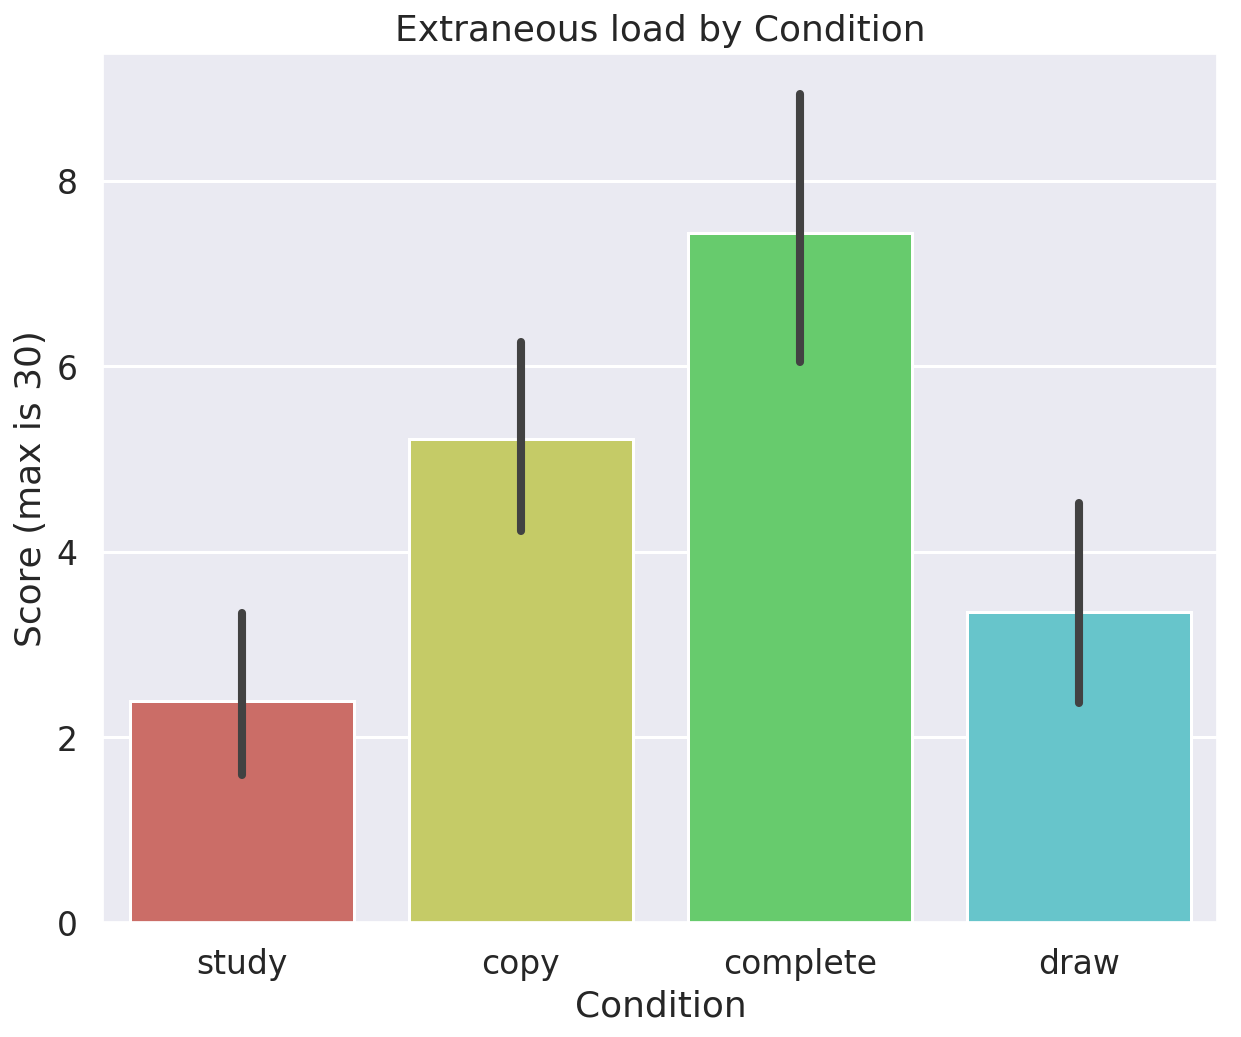

In [85]:
sns.barplot(
    y="EL",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Extraneous load by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (max is 30)")

In [86]:
anova_el = ols("EL ~ C(condition)", data=small_df_seasons).fit()
anova_el.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EL   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     14.01
Date:                Thu, 09 Jul 2020   Prob (F-statistic):           2.08e-08
Time:                        18:36:13   Log-Likelihood:                -671.60
No. Observations:                 229   AIC:                             1351.
Df Residuals:                     225   BIC:                             1365.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.4426      0.587     12.680      0.000       6.286       8.599
C(condition)[T.copy]     -2.2295      0.830     -2.686      0.008      -3.865      -0.594
C(condition)[T.draw]     -4.0948      0.895     -4.574      0.000      -5.859      -2.331
C(condition)[T.study]    -5.0492      0.830     -6.083      0.000      -6.685      -3.413
==============================================================================
Omnibus:                       30.628   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.013
Skew:                           0.911   Prob(JB):                     3.38e-09
Kurtosis:                       3.877   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
anova_mc = ols("mc_gain ~ C(condition)", data=small_df_seasons).fit()
anova_mc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mc_gain   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.454
Date:                Thu, 09 Jul 2020   Prob (F-statistic):             0.0641
Time:                        18:36:15   Log-Likelihood:                -526.82
No. Observations:                 229   AIC:                             1062.
Df Residuals:                     225   BIC:                             1075.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.3607      0.312      7.568      0.000       1.746       2.975
C(condition)[T.copy]      1.1639      0.441      2.639      0.009       0.295       2.033
C(condition)[T.draw]      0.6176      0.476      1.298      0.196      -0.320       1.555
C(condition)[T.study]     0.8197      0.441      1.858      0.064      -0.050       1.689
==============================================================================
Omnibus:                        0.213   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.899   Jarque-Bera (JB):                0.120
Skew:                           0.055   Prob(JB):                        0.942
Kurtosis:                       3.024   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Condition Enjoyment 

Mean: 2.415 	standard dev: 1.075

Min: 1 	Median: 2.0 	Max: 5


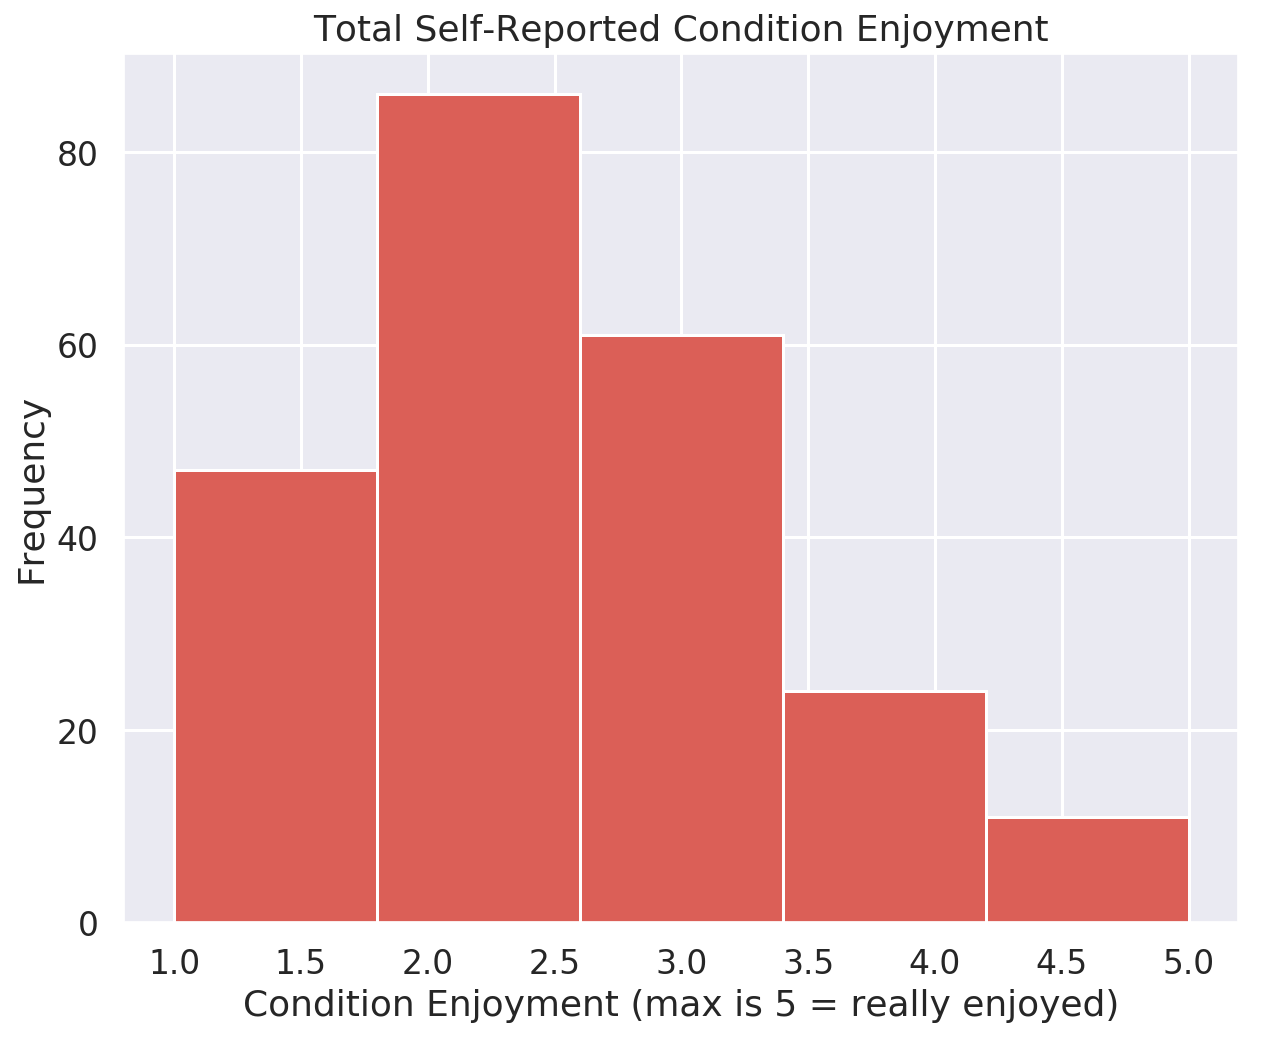

In [88]:
plt.hist(small_df_seasons["cond_enjoyment"], bins=5, label="cond_enjoyment")

plt.title("Total Self-Reported Condition Enjoyment")
plt.xlabel("Condition Enjoyment (max is 5 = really enjoyed)")
plt.ylabel("Frequency")


ce_min = round(small_df_seasons["cond_enjoyment"].min(), 3)
ce_max = round(small_df_seasons["cond_enjoyment"].max(), 3)
ce_mean = round(small_df_seasons["cond_enjoyment"].mean(), 3)
ce_std = round(small_df_seasons["cond_enjoyment"].std(), 3)
ce_med = round(small_df_seasons["cond_enjoyment"].median(), 3)


print("Condition Enjoyment \n\nMean: " + str(ce_mean), "\tstandard dev: " + str(ce_std))
print("\nMin: " + str(ce_min), "\tMedian: " + str(ce_med), "\tMax: " + str(ce_max))

In [94]:
anova_mc = ols("retention_lower ~ C(condition)", data=small_df_seasons).fit()
anova_mc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        retention_lower   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5510
Date:                Thu, 09 Jul 2020   Prob (F-statistic):              0.648
Time:                        18:36:15   Log-Likelihood:                -621.91
No. Observations:                 229   AIC:                             1252.
Df Residuals:                     225   BIC:                             1266.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.5574      0.472     11.763      0.000       4.626       6.488
C(condition)[T.copy]      0.1803      0.668      0.270      0.787      -1.136       1.497
C(condition)[T.draw]     -0.2530      0.721     -0.351      0.726      -1.673       1.167
C(condition)[T.study]     0.6230      0.668      0.932      0.352      -0.694       1.940
==============================================================================
Omnibus:                       52.258   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.321
Skew:                           0.220   Prob(JB):                      0.00211
Kurtosis:                       1.952   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

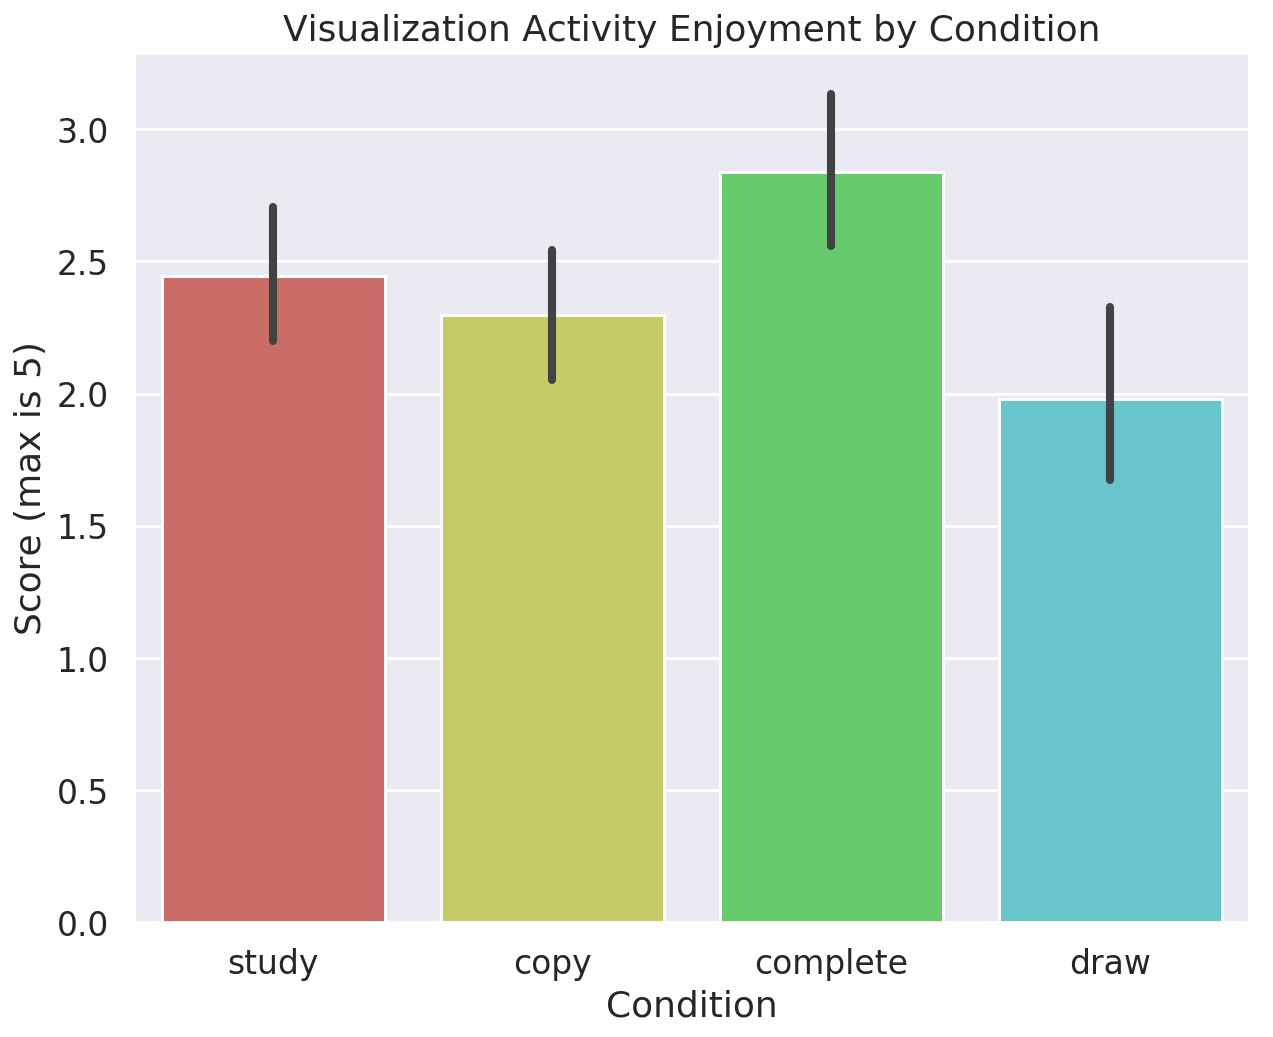

In [89]:
sns.barplot(
    y="cond_enjoyment",
    x="condition",
    data=small_df_seasons,
    order=["study", "copy", "complete", "draw"],
)

plt.title("Visualization Activity Enjoyment by Condition")
plt.xlabel("Condition")
plt.ylabel("Score (max is 5)")

Text(0, 0.5, 'Frequency')

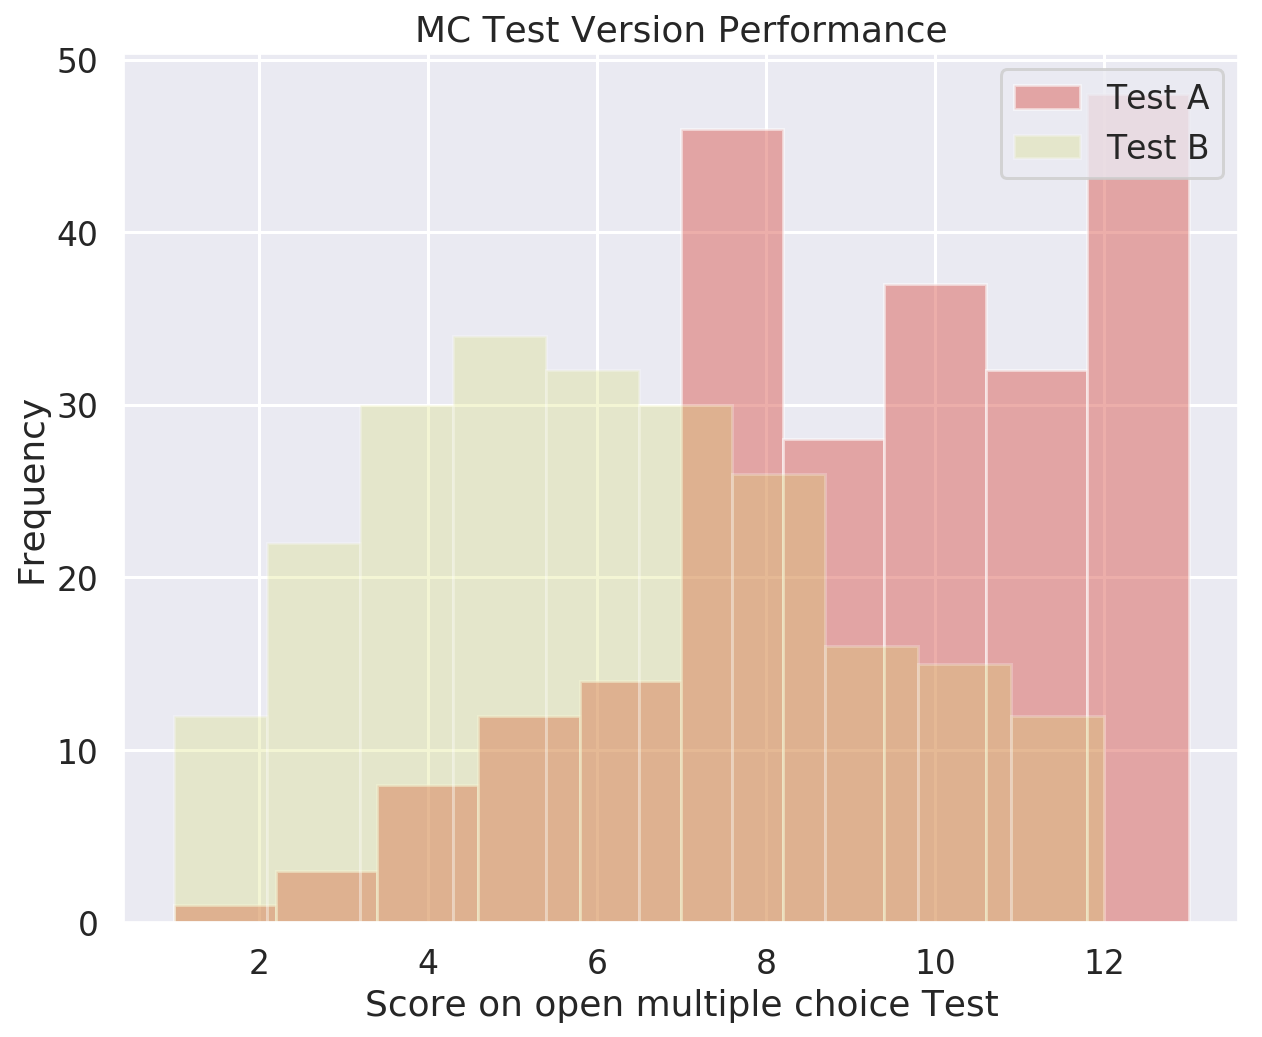

In [90]:
# Overlaying histograms of Test A and Test B performance
test_a = plt.hist(small_df_seasons["test_A"], bins=10, alpha=0.5, label="Test A")
test_b = plt.hist(small_df_seasons["test_B"], bins=10, alpha=0.25, label="Test B")

# customize plot
plt.title("MC Test Version Performance")
plt.legend(loc="upper right")
plt.xlabel("Score on open multiple choice Test")
plt.ylabel("Frequency")

In [97]:
anova_pre_mc = ols("pretest_score ~ C(condition)", data=small_df_seasons).fit()
anova_pre_mc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pretest_score   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.239
Date:                Thu, 09 Jul 2020   Prob (F-statistic):              0.297
Time:                        18:36:15   Log-Likelihood:                -533.03
No. Observations:                 229   AIC:                             1074.
Df Residuals:                     225   BIC:                             1088.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 6.6721      0.320     20.819      0.000       6.041       7.304
C(condition)[T.copy]     -0.8361      0.453     -1.845      0.066      -1.729       0.057
C(condition)[T.draw]     -0.6504      0.489     -1.331      0.185      -1.614       0.313
C(condition)[T.study]    -0.5410      0.453     -1.194      0.234      -1.434       0.352
==============================================================================
Omnibus:                        7.737   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                4.707
Skew:                           0.173   Prob(JB):                       0.0951
Kurtosis:                       2.388   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
anova_post_mc = ols("posttest_score ~ C(condition)", data=small_df_seasons).fit()
anova_post_mc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         posttest_score   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.2924
Date:                Thu, 09 Jul 2020   Prob (F-statistic):              0.831
Time:                        18:36:15   Log-Likelihood:                -540.07
No. Observations:                 229   AIC:                             1088.
Df Residuals:                     225   BIC:                             1102.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.0328      0.330     27.332      0.000       8.382       9.684
C(condition)[T.copy]      0.3279      0.467      0.702      0.484      -0.593       1.249
C(condition)[T.draw]     -0.0328      0.504     -0.065      0.948      -1.026       0.960
C(condition)[T.study]     0.2787      0.467      0.596      0.552      -0.642       1.200
==============================================================================
Omnibus:                       11.066   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.415
Skew:                          -0.516   Prob(JB):                      0.00332
Kurtosis:                       2.639   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
anova_pk = ols("prior_knowledge ~ C(condition)", data=small_df_seasons).fit()
anova_pk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        prior_knowledge   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.163
Date:                Thu, 09 Jul 2020   Prob (F-statistic):              0.325
Time:                        18:36:15   Log-Likelihood:                -748.61
No. Observations:                 229   AIC:                             1505.
Df Residuals:                     225   BIC:                             1519.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.6885      0.822     19.096      0.000      14.070      17.307
C(condition)[T.copy]      0.5246      1.162      0.451      0.652      -1.765       2.814
C(condition)[T.draw]     -1.6450      1.253     -1.313      0.191      -4.114       0.824
C(condition)[T.study]     0.2951      1.162      0.254      0.800      -1.994       2.585
==============================================================================
Omnibus:                      119.729   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              662.790
Skew:                           2.048   Prob(JB):                    1.19e-144
Kurtosis:                      10.259   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""